In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# TODO SOBRE DATASET AUDIO
#https://github.com/karolpiczak/ESC-50
#https://labs.freesound.org/datasets/
#https://zenodo.org/record/2552860#.Y21fVHaZOUk
#https://github.com/DCASE-REPO/dcase2018_baseline/tree/master/task2
#https://zenodo.org/record/3665275#.Y21fNnaZOUk
#https://arxiv.org/pdf/2010.00475.pdf


#USADA
#https://zenodo.org/record/3519845#.Y3QXLXaZOUl


In [ ]:
# Se obtienen las diferentes rutas de los datos, tanto audios como metadata y path para obtener las muestras
file_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio'
explosions_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-explosions/explosions'
urbansound8k = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/metadata/UrbanSound8K.csv')
file_viz = glob.glob('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/*')

In [ ]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
#Se organiza dataset para seleccionar la clase gun shot de interes y las otras renombrarse como no gunshot
urbansound8k.loc[urbansound8k["class"] != "gun_shot", "class"] = "non_gun_shot"

In [ ]:
#Se cambian los valores de la columna classID para identificar unicamente las dos clases de interes
urbansound8k.loc[urbansound8k["classID"] != 6, "classID"] = 1
urbansound8k.loc[urbansound8k["classID"] == 6, "classID"] = 0

In [ ]:
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,1,non_gun_shot
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,1,non_gun_shot
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,1,non_gun_shot
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,1,non_gun_shot
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,1,non_gun_shot


In [ ]:
#se cuenta el numero total de muestras de la clase de interes 
totalSamplesGunshot =  urbansound8k.loc[((urbansound8k["class"]=="gun_shot"))].count()[0]
totalSamplesGunshot

374

In [ ]:
#se carga el numero total de muestras de la clase a agregar al dataset - explosions
totalSamplesExplosions = 0
lastNameFilesExplosions=[]
for file in os.listdir(explosions_path):
    if file.endswith('.wav'):
        lastNameFilesExplosions.append(file)
        totalSamplesExplosions+=1
print(totalSamplesExplosions)

209


In [ ]:
#Se crea dataframe con los datos de los audios de sonidos de la clase a agregar - explosions
dfExplosion = pd.DataFrame(lastNameFilesExplosions, columns=['slice_file_name'])
dfExplosion['classID'] = 1
dfExplosion['class'] = 'non_gun_shot'
dfExplosion['fold'] = 0

In [ ]:
dfExplosion

,slice_file_name,classID,class,fold
0,explosion_083.wav,1,non_gun_shot,0
1,explosion_084.wav,1,non_gun_shot,0
2,explosion_081.wav,1,non_gun_shot,0
3,explosion_080.wav,1,non_gun_shot,0
4,explosion_077.wav,1,non_gun_shot,0
...,...,...,...,...
204,explosion_059.wav,1,non_gun_shot,0
205,explosion_010.wav,1,non_gun_shot,0
206,explosion_043.wav,1,non_gun_shot,0
207,explosion_019.wav,1,non_gun_shot,0


In [ ]:
#Agregar en un dataset todos los sonidos de interes con la clase nueva agregada - explosions
print(urbansound8k.count()[0])
dfUrbansound8kV2 = urbansound8k.append(dfExplosion)
dfUrbansound8kV2.count()[0]

8732


8941

In [ ]:
#se toma una muestra aleatoria del tamaño de las muestras de la clase de interes para que quede balanceado
urbansound8k[urbansound8k['class'] == "non_gun_shot"].sample(n=totalSamplesGunshot).head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
6918,58005-4-0-32.wav,58005,21.065261,25.065261,1,6,1,non_gun_shot
2859,161129-4-0-20.wav,161129,18.275687,22.275687,1,8,1,non_gun_shot
6534,46669-4-0-54.wav,46669,27.000000,31.000000,1,1,1,non_gun_shot
5311,203929-7-1-7.wav,203929,38.362871,42.362871,2,2,1,non_gun_shot
7392,71079-4-1-0.wav,71079,2.730519,3.261020,1,6,1,non_gun_shot


In [ ]:
#se toma una muestra aleatoria del tamaño de las muestras de la clase de interes para que quede balanceado 
dfNonGunShot = urbansound8k[urbansound8k['class'] == "non_gun_shot"].sample(n=totalSamplesGunshot)
dfGunShot= urbansound8k[urbansound8k['class'] == "gun_shot"]

In [ ]:
#se unen en un solo dataset las clases de interes con muestras balanceadas
dfComplete = dfNonGunShot.append(dfGunShot)
dfComplete.count()[0]

748

In [ ]:
dfComplete[dfComplete['class'] == "gun_shot"].count()[0]

374

In [ ]:
#Se cambia el dataset para unicamente tomar las clases de interés para el trabajo
dfComplete.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
4757,189982-0-0-27.wav,189982,13.500000,17.500000,1,10,1,non_gun_shot
328,104998-7-16-5.wav,104998,424.655994,428.655994,1,5,1,non_gun_shot
6626,50629-4-1-4.wav,50629,17.513354,21.513354,1,7,1,non_gun_shot
47,100852-0-0-4.wav,100852,2.000000,6.000000,1,5,1,non_gun_shot
3408,169466-4-2-21.wav,169466,167.640268,171.640268,2,4,1,non_gun_shot


In [ ]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
#Se crea el mapa de las clases a utilizar
class_map = {'6' : 'gun_shot', '4' : 'non_gun_shot',}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,4,non_gun_shot
1,6,gun_shot


In [ ]:
#Se toman muestras del dataset para ser previsualizadas
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [ ]:
#Funcion para obtener los datos del sonido muestreados a una tasa de 22050 por defecto.
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('gun_shot', (57551,)), ('non_gun_shot', (88200,))]

In [ ]:
#Se despliegan las muestras de los datos para ser reproducidas.
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

gun_shot :


non_gun_shot :


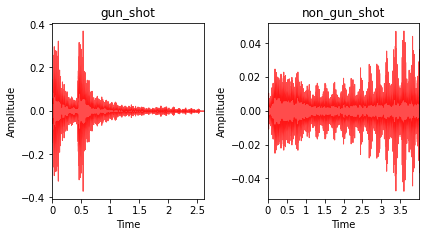

In [ ]:
#Se despliega la forma de onda para las muestras tomadas
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    plt.ylabel("Amplitude")
    i += 1
plt.tight_layout()

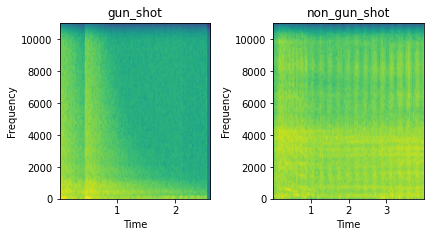

In [ ]:
#Se muestran los espectogramas correspondeintes a las muestras tomadas.
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    i += 1
plt.tight_layout()

Extracting features using Librosa

In [ ]:
#Se define funcion para extrar las caracteristicas con la librería librosa, obetiendo los coeficientes ceptrales de frecuencia de Mel
#Se realiza un pading en el tamaño para que concuerden los tamaños de las caracteristicas de entrada al modelo.

def extract_features(file_name, Nmfcc):
    max_pad_len = 174
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=Nmfcc)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    #print(mfccs.shape)
    return mfccs

In [ ]:
#Se realiza la extracción de caracteristicas, teniendo en cuenta la clase, si el sonido es de la carpeta agregada de la clase explosions va y busca este sonido en la carpeta requerida

def get_features(Nmfcc):
  features = []
  # Iterate through each sound file and extract the features 
  for index, row in dfComplete.iterrows():
      if(row["fold"]!=0):
          file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
          #file_name = ""
      elif(row["fold"]==0):
          file_name = os.path.join(os.path.abspath(explosions_path),str(row["slice_file_name"]))
          #file_name = ""
      #print(file_name)
      class_label = row["classID"]
      data = extract_features(file_name, Nmfcc)
      
      features.append([data, class_label])

  # Convert into a Panda dataframe 
  featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
  return featuresdf

In [ ]:
def splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels):
  X = np.array(featuresdf.feature.tolist())
  y = np.array(featuresdf.class_label.tolist())

  # Encode the classification labels
  le = LabelEncoder()
  yy = to_categorical(le.fit_transform(y)) 

  # split the dataset 
  from sklearn.model_selection import train_test_split 

  x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

  x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
  x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
  num_labels = yy.shape[1]
  return x_train, x_test, y_train, y_test, num_labels

#Creating the Model

In [ ]:
# Constructing model with RELu and SoftMax activation functions:
# Constructing model with RELu and SoftMax activation functions:
def getModel(num_rows, num_columns, num_channels, num_labels):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

#Evaluation Metrics

In [ ]:

#Model and History container
models = []
histories = []
reports = []
cmatrixs = []

for Nmfcc in range(1, 52, 2):
  num_rows = Nmfcc
  num_columns = 174
  num_channels = 1
  featuresdf = get_features(Nmfcc)
  x_train, x_test, y_train, y_test, num_labels = splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels)
  
  model = getModel(num_rows, num_columns, num_channels, num_labels)
  #Se compila el modelo con la función de perdida de crosentrpía categorica 
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for N_MFCC =  {Nmfcc} ...')

  #Entrenamiento del modelo 
  num_epochs = 40
  num_batch_size = 256

  checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check', 
                                verbose=1, save_best_only=True)
  start = datetime.now()

  history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

  duration = datetime.now() - start
  print("Training completed in time: ", duration)

  # Evaluating the model on the training and testing set
  score = model.evaluate(x_train, y_train, verbose=0)
  print("Training Accuracy: ", score[1])

  score = model.evaluate(x_test, y_test, verbose=0)
  print("Testing Accuracy: ", score[1])

  y_true = np.argmax(y_test,axis=1)
  y_pred = np.argmax(model.predict(x_test),axis=1)
  print('\nConfusion Matrix :\n\n')
  print(confusion_matrix(y_true,y_pred))
  print('\n\nClassification Report : \n\n',classification_report(y_true,y_pred))

  # Add trained model, histoy, and reports to container
  models.append(model)
  histories.append(history)
  reports.append(classification_report(y_true,y_pred))
  cmatrixs.append(confusion_matrix(y_true,y_pred))



------------------------------------------------------------------------
Training for N_MFCC =  1 ...
Epoch 1/40
2/3 [===================>..........] - ETA: 0s - loss: 2.2737 - accuracy: 0.5332
Epoch 1: val_loss improved from inf to 0.88903, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 2.1324 - accuracy: 0.5217 - val_loss: 0.8890 - val_accuracy: 0.5333
Epoch 2/40
2/3 [===================>..........] - ETA: 0s - loss: 1.6049 - accuracy: 0.5273
Epoch 2: val_loss did not improve from 0.88903
3/3 [==============================] - 0s 104ms/step - loss: 1.6786 - accuracy: 0.5201 - val_loss: 0.8941 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.0469 - accuracy: 0.5870
Epoch 3: val_loss improved from 0.88903 to 0.69426, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 969ms/step - loss: 1.0469 - accuracy: 0.5870 - val_loss: 0.6943 - val_accuracy: 0.4933
Epoch 4/40
2/3 [===================>..........] - ETA: 0s - loss: 1.3676 - accuracy: 0.4941
Epoch 4: val_loss improved from 0.69426 to 0.57820, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 1.3277 - accuracy: 0.4916 - val_loss: 0.5782 - val_accuracy: 0.7933
Epoch 5/40
2/3 [===================>..........] - ETA: 0s - loss: 0.6964 - accuracy: 0.6602
Epoch 5: val_loss did not improve from 0.57820
3/3 [==============================] - 0s 103ms/step - loss: 0.7172 - accuracy: 0.6605 - val_loss: 0.6667 - val_accuracy: 0.6467
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.9730 - accuracy: 0.6171
Epoch 6: val_loss did not improve from 0.57820
3/3 [==============================] - 0s 111ms/step - loss: 0.9730 - accuracy: 0.6171 - val_loss: 0.5979 - val_accuracy: 0.7467
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7007
Epoch 7: val_loss improved from 0.57820 to 0.55134, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 997ms/step - loss: 0.7260 - accuracy: 0.7007 - val_loss: 0.5513 - val_accuracy: 0.8333
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.6823
Epoch 8: val_loss did not improve from 0.55134
3/3 [==============================] - 0s 110ms/step - loss: 0.6424 - accuracy: 0.6823 - val_loss: 0.5856 - val_accuracy: 0.8267
Epoch 9/40
2/3 [===================>..........] - ETA: 0s - loss: 0.6327 - accuracy: 0.6484
Epoch 9: val_loss improved from 0.55134 to 0.54552, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 971ms/step - loss: 0.6249 - accuracy: 0.6656 - val_loss: 0.5455 - val_accuracy: 0.8467
Epoch 10/40
2/3 [===================>..........] - ETA: 0s - loss: 0.5744 - accuracy: 0.7754
Epoch 10: val_loss improved from 0.54552 to 0.53235, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.5774 - accuracy: 0.7726 - val_loss: 0.5323 - val_accuracy: 0.8267
Epoch 11/40
2/3 [===================>..........] - ETA: 0s - loss: 0.5475 - accuracy: 0.7949
Epoch 11: val_loss did not improve from 0.53235
3/3 [==============================] - 0s 99ms/step - loss: 0.5591 - accuracy: 0.7843 - val_loss: 0.5415 - val_accuracy: 0.8533
Epoch 12/40
2/3 [===================>..........] - ETA: 0s - loss: 0.5382 - accuracy: 0.7988
Epoch 12: val_loss did not improve from 0.53235
3/3 [==============================] - 0s 102ms/step - loss: 0.5169 - accuracy: 0.8077 - val_loss: 0.6051 - val_accuracy: 0.8333
Epoch 13/40
2/3 [===================>..........] - ETA: 0s - loss: 0.4853 - accuracy: 0.8164
Epoch 13: val_loss did not improve from 0.53235
3/3 [==============================] - 0s 93ms/step - loss: 0.4994 - accuracy: 0.8161 - val_loss: 0.6582 - val_accuracy: 0.8333
Epoch 14/40
2/3 [===================>..........] - ETA: 0s - loss:

3/3 [==============================] - 2s 1s/step - loss: 0.3089 - accuracy: 0.9114 - val_loss: 0.5224 - val_accuracy: 0.8533
Epoch 36/40
2/3 [===================>..........] - ETA: 0s - loss: 0.3024 - accuracy: 0.9082
Epoch 36: val_loss improved from 0.52244 to 0.51293, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 996ms/step - loss: 0.3109 - accuracy: 0.8980 - val_loss: 0.5129 - val_accuracy: 0.8600
Epoch 37/40
2/3 [===================>..........] - ETA: 0s - loss: 0.3312 - accuracy: 0.8984
Epoch 37: val_loss improved from 0.51293 to 0.47834, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 975ms/step - loss: 0.3313 - accuracy: 0.8946 - val_loss: 0.4783 - val_accuracy: 0.8667
Epoch 38/40
2/3 [===================>..........] - ETA: 0s - loss: 0.2799 - accuracy: 0.9082
Epoch 38: val_loss improved from 0.47834 to 0.45222, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.3059 - accuracy: 0.9013 - val_loss: 0.4522 - val_accuracy: 0.8667
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.9114
Epoch 39: val_loss did not improve from 0.45222
3/3 [==============================] - 1s 172ms/step - loss: 0.2938 - accuracy: 0.9114 - val_loss: 0.4745 - val_accuracy: 0.8667
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8913
Epoch 40: val_loss did not improve from 0.45222
3/3 [==============================] - 0s 156ms/step - loss: 0.3515 - accuracy: 0.8913 - val_loss: 0.4804 - val_accuracy: 0.8667
Training completed in time:  0:00:42.050889
Training Accuracy:  0.9214046597480774
Testing Accuracy:  0.8666666746139526
5/5 [==============================] - 0s 6ms/step

Confusion Matrix :


[[70  0]
 [20 60]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.78      1.00    

3/3 [==============================] - 3s 1s/step - loss: 3.4826 - accuracy: 0.5251 - val_loss: 0.9832 - val_accuracy: 0.5400
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.1218 - accuracy: 0.5251
Epoch 2: val_loss did not improve from 0.98322
3/3 [==============================] - 0s 133ms/step - loss: 2.1218 - accuracy: 0.5251 - val_loss: 1.0264 - val_accuracy: 0.5467
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.2621 - accuracy: 0.5987
Epoch 3: val_loss improved from 0.98322 to 0.70025, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 983ms/step - loss: 1.2621 - accuracy: 0.5987 - val_loss: 0.7002 - val_accuracy: 0.6133
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.8884 - accuracy: 0.5452
Epoch 4: val_loss improved from 0.70025 to 0.54912, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 1.8884 - accuracy: 0.5452 - val_loss: 0.5491 - val_accuracy: 0.6867
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.6338
Epoch 5: val_loss did not improve from 0.54912
3/3 [==============================] - 0s 139ms/step - loss: 0.8618 - accuracy: 0.6338 - val_loss: 0.8256 - val_accuracy: 0.6200
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 1.1174 - accuracy: 0.5870
Epoch 6: val_loss did not improve from 0.54912
3/3 [==============================] - 0s 129ms/step - loss: 1.1174 - accuracy: 0.5870 - val_loss: 0.6201 - val_accuracy: 0.6467
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.6756
Epoch 7: val_loss improved from 0.54912 to 0.45957, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.7130 - accuracy: 0.6756 - val_loss: 0.4596 - val_accuracy: 0.7533
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.7688 - accuracy: 0.6890
Epoch 8: val_loss improved from 0.45957 to 0.45941, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.7688 - accuracy: 0.6890 - val_loss: 0.4594 - val_accuracy: 0.7400
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.7508
Epoch 9: val_loss did not improve from 0.45941
3/3 [==============================] - 1s 239ms/step - loss: 0.5593 - accuracy: 0.7508 - val_loss: 0.5402 - val_accuracy: 0.6733
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.6906
Epoch 10: val_loss did not improve from 0.45941
3/3 [==============================] - 1s 229ms/step - loss: 0.6980 - accuracy: 0.6906 - val_loss: 0.5319 - val_accuracy: 0.6800
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.7458
Epoch 11: val_loss improved from 0.45941 to 0.44885, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.5313 - accuracy: 0.7458 - val_loss: 0.4488 - val_accuracy: 0.7467
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7575
Epoch 12: val_loss improved from 0.44885 to 0.42550, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.5333 - accuracy: 0.7575 - val_loss: 0.4255 - val_accuracy: 0.7667
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.7860
Epoch 13: val_loss did not improve from 0.42550
3/3 [==============================] - 0s 145ms/step - loss: 0.5272 - accuracy: 0.7860 - val_loss: 0.4346 - val_accuracy: 0.7733
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.7809
Epoch 14: val_loss did not improve from 0.42550
3/3 [==============================] - 0s 140ms/step - loss: 0.4868 - accuracy: 0.7809 - val_loss: 0.4588 - val_accuracy: 0.7733
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.8043
Epoch 15: val_loss did not improve from 0.42550
3/3 [==============================] - 0s 141ms/step - loss: 0.4575 - accuracy: 0.8043 - val_loss: 0.4515 - val_accuracy: 0.7800
Epoch 16/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 2s 996ms/step - loss: 0.4549 - accuracy: 0.8278 - val_loss: 0.4212 - val_accuracy: 0.8000
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8278
Epoch 20: val_loss improved from 0.42116 to 0.41467, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.4027 - accuracy: 0.8278 - val_loss: 0.4147 - val_accuracy: 0.8000
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8595
Epoch 21: val_loss did not improve from 0.41467
3/3 [==============================] - 0s 138ms/step - loss: 0.3637 - accuracy: 0.8595 - val_loss: 0.4180 - val_accuracy: 0.8000
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.8378
Epoch 22: val_loss did not improve from 0.41467
3/3 [==============================] - 0s 139ms/step - loss: 0.3921 - accuracy: 0.8378 - val_loss: 0.4203 - val_accuracy: 0.7933
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8645
Epoch 23: val_loss did not improve from 0.41467
3/3 [==============================] - 0s 139ms/step - loss: 0.3840 - accuracy: 0.8645 - val_loss: 0.4159 - val_accuracy: 0.8067
Epoch 24/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 2s 1s/step - loss: 0.3399 - accuracy: 0.8645 - val_loss: 0.4118 - val_accuracy: 0.8000
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8545
Epoch 25: val_loss improved from 0.41181 to 0.40375, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.3512 - accuracy: 0.8545 - val_loss: 0.4037 - val_accuracy: 0.8067
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8612
Epoch 26: val_loss improved from 0.40375 to 0.40238, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.3670 - accuracy: 0.8612 - val_loss: 0.4024 - val_accuracy: 0.8067
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8796
Epoch 27: val_loss did not improve from 0.40238
3/3 [==============================] - 0s 141ms/step - loss: 0.3448 - accuracy: 0.8796 - val_loss: 0.4094 - val_accuracy: 0.8067
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.8495
Epoch 28: val_loss did not improve from 0.40238
3/3 [==============================] - 0s 135ms/step - loss: 0.3697 - accuracy: 0.8495 - val_loss: 0.4240 - val_accuracy: 0.8333
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8763
Epoch 29: val_loss did not improve from 0.40238
3/3 [==============================] - 0s 137ms/step - loss: 0.3351 - accuracy: 0.8763 - val_loss: 0.4337 - val_accuracy: 0.8200
Epoch 30/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 1s/step - loss: 3.2642 - accuracy: 0.5067 - val_loss: 1.5066 - val_accuracy: 0.4000
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.0647 - accuracy: 0.4682
Epoch 2: val_loss improved from 1.50662 to 0.67110, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 2.0647 - accuracy: 0.4682 - val_loss: 0.6711 - val_accuracy: 0.6267
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.4271 - accuracy: 0.5401
Epoch 3: val_loss improved from 0.67110 to 0.63773, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 1.4271 - accuracy: 0.5401 - val_loss: 0.6377 - val_accuracy: 0.6400
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.0896 - accuracy: 0.6120
Epoch 4: val_loss did not improve from 0.63773
3/3 [==============================] - 1s 200ms/step - loss: 1.0896 - accuracy: 0.6120 - val_loss: 0.6589 - val_accuracy: 0.7000
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 1.1499 - accuracy: 0.6137
Epoch 5: val_loss improved from 0.63773 to 0.47616, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 1.1499 - accuracy: 0.6137 - val_loss: 0.4762 - val_accuracy: 0.7867
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.7007
Epoch 6: val_loss did not improve from 0.47616
3/3 [==============================] - 1s 199ms/step - loss: 0.6633 - accuracy: 0.7007 - val_loss: 0.5139 - val_accuracy: 0.6667
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.6455
Epoch 7: val_loss improved from 0.47616 to 0.45350, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.8574 - accuracy: 0.6455 - val_loss: 0.4535 - val_accuracy: 0.7200
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7475
Epoch 8: val_loss improved from 0.45350 to 0.45204, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5989 - accuracy: 0.7475 - val_loss: 0.4520 - val_accuracy: 0.8333
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7458
Epoch 9: val_loss improved from 0.45204 to 0.42052, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.6042 - accuracy: 0.7458 - val_loss: 0.4205 - val_accuracy: 0.8400
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.7291
Epoch 10: val_loss improved from 0.42052 to 0.41071, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.6243 - accuracy: 0.7291 - val_loss: 0.4107 - val_accuracy: 0.8133
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7492
Epoch 11: val_loss improved from 0.41071 to 0.40092, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.5671 - accuracy: 0.7492 - val_loss: 0.4009 - val_accuracy: 0.8600
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.7559
Epoch 12: val_loss did not improve from 0.40092
3/3 [==============================] - 1s 361ms/step - loss: 0.5404 - accuracy: 0.7559 - val_loss: 0.4167 - val_accuracy: 0.8800
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.7893
Epoch 13: val_loss improved from 0.40092 to 0.39239, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5399 - accuracy: 0.7893 - val_loss: 0.3924 - val_accuracy: 0.8800
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8110
Epoch 14: val_loss improved from 0.39239 to 0.38344, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.4741 - accuracy: 0.8110 - val_loss: 0.3834 - val_accuracy: 0.8400
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.8161
Epoch 15: val_loss improved from 0.38344 to 0.37867, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.4701 - accuracy: 0.8161 - val_loss: 0.3787 - val_accuracy: 0.8667
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8378
Epoch 16: val_loss improved from 0.37867 to 0.36889, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.4443 - accuracy: 0.8378 - val_loss: 0.3689 - val_accuracy: 0.8667
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8311
Epoch 17: val_loss improved from 0.36889 to 0.35570, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4053 - accuracy: 0.8311 - val_loss: 0.3557 - val_accuracy: 0.8600
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.8094
Epoch 18: val_loss improved from 0.35570 to 0.35431, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.4435 - accuracy: 0.8094 - val_loss: 0.3543 - val_accuracy: 0.8600
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8328
Epoch 19: val_loss improved from 0.35431 to 0.34429, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.3915 - accuracy: 0.8328 - val_loss: 0.3443 - val_accuracy: 0.8667
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8512
Epoch 20: val_loss improved from 0.34429 to 0.34037, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.3751 - accuracy: 0.8512 - val_loss: 0.3404 - val_accuracy: 0.8733
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8328
Epoch 21: val_loss did not improve from 0.34037
3/3 [==============================] - 1s 207ms/step - loss: 0.3911 - accuracy: 0.8328 - val_loss: 0.3536 - val_accuracy: 0.8533
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8411
Epoch 22: val_loss did not improve from 0.34037
3/3 [==============================] - 1s 194ms/step - loss: 0.3698 - accuracy: 0.8411 - val_loss: 0.3488 - val_accuracy: 0.8533
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8562
Epoch 23: val_loss improved from 0.34037 to 0.33373, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 2s 1s/step - loss: 0.3482 - accuracy: 0.8562 - val_loss: 0.3337 - val_accuracy: 0.8600
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.3803 - accuracy: 0.8579
Epoch 24: val_loss improved from 0.33373 to 0.33265, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3803 - accuracy: 0.8579 - val_loss: 0.3326 - val_accuracy: 0.8667
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.8595
Epoch 25: val_loss did not improve from 0.33265
3/3 [==============================] - 1s 208ms/step - loss: 0.3505 - accuracy: 0.8595 - val_loss: 0.3706 - val_accuracy: 0.8667
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.8829
Epoch 26: val_loss did not improve from 0.33265
3/3 [==============================] - 1s 204ms/step - loss: 0.3108 - accuracy: 0.8829 - val_loss: 0.3505 - val_accuracy: 0.8667
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8746
Epoch 27: val_loss did not improve from 0.33265
3/3 [==============================] - 1s 195ms/step - loss: 0.3096 - accuracy: 0.8746 - val_loss: 0.3442 - val_accuracy: 0.8733
Epoch 28/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 1s/step - loss: 2.6292 - accuracy: 0.4866 - val_loss: 1.1483 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.3710 - accuracy: 0.5669
Epoch 2: val_loss improved from 1.14827 to 0.46545, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 1.3710 - accuracy: 0.5669 - val_loss: 0.4654 - val_accuracy: 0.8267
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.6187
Epoch 3: val_loss did not improve from 0.46545
3/3 [==============================] - 1s 228ms/step - loss: 1.0684 - accuracy: 0.6187 - val_loss: 0.8207 - val_accuracy: 0.5400
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.5970
Epoch 4: val_loss did not improve from 0.46545
3/3 [==============================] - 1s 245ms/step - loss: 1.1321 - accuracy: 0.5970 - val_loss: 0.6555 - val_accuracy: 0.6200
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.6739
Epoch 5: val_loss improved from 0.46545 to 0.37834, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.7187 - accuracy: 0.6739 - val_loss: 0.3783 - val_accuracy: 0.8867
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.7107
Epoch 6: val_loss improved from 0.37834 to 0.37095, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.8063 - accuracy: 0.7107 - val_loss: 0.3710 - val_accuracy: 0.8800
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.7525
Epoch 7: val_loss did not improve from 0.37095
3/3 [==============================] - 1s 239ms/step - loss: 0.5814 - accuracy: 0.7525 - val_loss: 0.4673 - val_accuracy: 0.7267
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.7174
Epoch 8: val_loss did not improve from 0.37095
3/3 [==============================] - 1s 247ms/step - loss: 0.6083 - accuracy: 0.7174 - val_loss: 0.4842 - val_accuracy: 0.7200
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7241
Epoch 9: val_loss did not improve from 0.37095
3/3 [==============================] - 1s 234ms/step - loss: 0.5610 - accuracy: 0.7241 - val_loss: 0.3895 - val_accuracy: 0.8267
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4

3/3 [==============================] - 3s 1s/step - loss: 0.4929 - accuracy: 0.7692 - val_loss: 0.3565 - val_accuracy: 0.8733
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8094
Epoch 11: val_loss improved from 0.35653 to 0.35533, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4831 - accuracy: 0.8094 - val_loss: 0.3553 - val_accuracy: 0.8600
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.7776
Epoch 12: val_loss did not improve from 0.35533
3/3 [==============================] - 1s 237ms/step - loss: 0.4915 - accuracy: 0.7776 - val_loss: 0.3797 - val_accuracy: 0.8333
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.7860
Epoch 13: val_loss did not improve from 0.35533
3/3 [==============================] - 1s 241ms/step - loss: 0.4309 - accuracy: 0.7860 - val_loss: 0.3603 - val_accuracy: 0.8600
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8094
Epoch 14: val_loss improved from 0.35533 to 0.32748, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3932 - accuracy: 0.8094 - val_loss: 0.3275 - val_accuracy: 0.8800
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8311
Epoch 15: val_loss improved from 0.32748 to 0.31659, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4475 - accuracy: 0.8311 - val_loss: 0.3166 - val_accuracy: 0.8867
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8311
Epoch 16: val_loss did not improve from 0.31659
3/3 [==============================] - 1s 227ms/step - loss: 0.4017 - accuracy: 0.8311 - val_loss: 0.3292 - val_accuracy: 0.8933
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.8411
Epoch 17: val_loss did not improve from 0.31659
3/3 [==============================] - 1s 249ms/step - loss: 0.3713 - accuracy: 0.8411 - val_loss: 0.3248 - val_accuracy: 0.9000
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8227
Epoch 18: val_loss improved from 0.31659 to 0.30075, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3928 - accuracy: 0.8227 - val_loss: 0.3008 - val_accuracy: 0.8867
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8361
Epoch 19: val_loss improved from 0.30075 to 0.29440, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3734 - accuracy: 0.8361 - val_loss: 0.2944 - val_accuracy: 0.8867
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8462
Epoch 20: val_loss improved from 0.29440 to 0.29352, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3584 - accuracy: 0.8462 - val_loss: 0.2935 - val_accuracy: 0.8867
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8629
Epoch 21: val_loss improved from 0.29352 to 0.28338, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3331 - accuracy: 0.8629 - val_loss: 0.2834 - val_accuracy: 0.8867
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8846
Epoch 22: val_loss improved from 0.28338 to 0.27569, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3099 - accuracy: 0.8846 - val_loss: 0.2757 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.8595
Epoch 23: val_loss improved from 0.27569 to 0.27269, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3253 - accuracy: 0.8595 - val_loss: 0.2727 - val_accuracy: 0.8867
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8645
Epoch 24: val_loss improved from 0.27269 to 0.27206, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2990 - accuracy: 0.8645 - val_loss: 0.2721 - val_accuracy: 0.8867
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8679
Epoch 25: val_loss improved from 0.27206 to 0.26615, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3177 - accuracy: 0.8679 - val_loss: 0.2662 - val_accuracy: 0.8867
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8796
Epoch 26: val_loss improved from 0.26615 to 0.26260, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2959 - accuracy: 0.8796 - val_loss: 0.2626 - val_accuracy: 0.8867
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8880
Epoch 27: val_loss improved from 0.26260 to 0.26031, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3036 - accuracy: 0.8880 - val_loss: 0.2603 - val_accuracy: 0.8933
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8696
Epoch 28: val_loss improved from 0.26031 to 0.25797, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3241 - accuracy: 0.8696 - val_loss: 0.2580 - val_accuracy: 0.8867
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.9030
Epoch 29: val_loss improved from 0.25797 to 0.25407, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2658 - accuracy: 0.9030 - val_loss: 0.2541 - val_accuracy: 0.8933
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8846
Epoch 30: val_loss improved from 0.25407 to 0.25300, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2960 - accuracy: 0.8846 - val_loss: 0.2530 - val_accuracy: 0.8867
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.8846
Epoch 31: val_loss did not improve from 0.25300
3/3 [==============================] - 1s 241ms/step - loss: 0.2805 - accuracy: 0.8846 - val_loss: 0.2537 - val_accuracy: 0.8867
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8846
Epoch 32: val_loss did not improve from 0.25300
3/3 [==============================] - 1s 241ms/step - loss: 0.2776 - accuracy: 0.8846 - val_loss: 0.2555 - val_accuracy: 0.8867
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8846
Epoch 33: val_loss improved from 0.25300 to 0.25232, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2802 - accuracy: 0.8846 - val_loss: 0.2523 - val_accuracy: 0.8867
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.8997
Epoch 34: val_loss improved from 0.25232 to 0.25218, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2488 - accuracy: 0.8997 - val_loss: 0.2522 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8980
Epoch 35: val_loss improved from 0.25218 to 0.24739, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2710 - accuracy: 0.8980 - val_loss: 0.2474 - val_accuracy: 0.8933
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.8930
Epoch 36: val_loss improved from 0.24739 to 0.24082, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2693 - accuracy: 0.8930 - val_loss: 0.2408 - val_accuracy: 0.8867
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9047
Epoch 37: val_loss did not improve from 0.24082
3/3 [==============================] - 1s 259ms/step - loss: 0.2427 - accuracy: 0.9047 - val_loss: 0.2423 - val_accuracy: 0.8933
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.8880
Epoch 38: val_loss did not improve from 0.24082
3/3 [==============================] - 1s 261ms/step - loss: 0.2797 - accuracy: 0.8880 - val_loss: 0.2491 - val_accuracy: 0.8933
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9064
Epoch 39: val_loss did not improve from 0.24082
3/3 [==============================] - 1s 250ms/step - loss: 0.2586 - accuracy: 0.9064 - val_loss: 0.2424 - val_accuracy: 0.8867
Epoch 40/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 3s 1s/step - loss: 0.2329 - accuracy: 0.9114 - val_loss: 0.2387 - val_accuracy: 0.8867
Training completed in time:  0:02:22.743218
Training Accuracy:  0.9247491359710693
Testing Accuracy:  0.8866666555404663
5/5 [==============================] - 0s 21ms/step

Confusion Matrix :


[[68  2]
 [15 65]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.82      0.97      0.89        70
           1       0.97      0.81      0.88        80

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150

------------------------------------------------------------------------
Training for N_MFCC =  9 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.4230 - accuracy: 0.5552
Epoch 1: val_loss improved from inf to 0.48171, saving model to /content/drive/MyDrive/Colab Notebooks/Urban S

3/3 [==============================] - 4s 1s/step - loss: 1.4230 - accuracy: 0.5552 - val_loss: 0.4817 - val_accuracy: 0.7200
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.5169 - accuracy: 0.6522
Epoch 2: val_loss did not improve from 0.48171
3/3 [==============================] - 1s 315ms/step - loss: 1.5169 - accuracy: 0.6522 - val_loss: 0.5253 - val_accuracy: 0.6800
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.5970
Epoch 3: val_loss did not improve from 0.48171
3/3 [==============================] - 1s 316ms/step - loss: 1.3685 - accuracy: 0.5970 - val_loss: 0.5048 - val_accuracy: 0.6933
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.7191
Epoch 4: val_loss improved from 0.48171 to 0.40247, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.7752 - accuracy: 0.7191 - val_loss: 0.4025 - val_accuracy: 0.8067
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.8694 - accuracy: 0.6990
Epoch 5: val_loss improved from 0.40247 to 0.36377, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.8694 - accuracy: 0.6990 - val_loss: 0.3638 - val_accuracy: 0.8400
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.7124
Epoch 6: val_loss did not improve from 0.36377
3/3 [==============================] - 1s 307ms/step - loss: 0.6507 - accuracy: 0.7124 - val_loss: 0.3672 - val_accuracy: 0.8267
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7525
Epoch 7: val_loss did not improve from 0.36377
3/3 [==============================] - 1s 321ms/step - loss: 0.5319 - accuracy: 0.7525 - val_loss: 0.3884 - val_accuracy: 0.8133
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.7943
Epoch 8: val_loss improved from 0.36377 to 0.34921, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.5774 - accuracy: 0.7943 - val_loss: 0.3492 - val_accuracy: 0.8333
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.7860
Epoch 9: val_loss improved from 0.34921 to 0.32112, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4862 - accuracy: 0.7860 - val_loss: 0.3211 - val_accuracy: 0.8267
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.7742
Epoch 10: val_loss improved from 0.32112 to 0.30759, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4709 - accuracy: 0.7742 - val_loss: 0.3076 - val_accuracy: 0.8733
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8512
Epoch 11: val_loss did not improve from 0.30759
3/3 [==============================] - 1s 321ms/step - loss: 0.3917 - accuracy: 0.8512 - val_loss: 0.3186 - val_accuracy: 0.8733
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8528
Epoch 12: val_loss improved from 0.30759 to 0.28904, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4279 - accuracy: 0.8528 - val_loss: 0.2890 - val_accuracy: 0.8800
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8428
Epoch 13: val_loss improved from 0.28904 to 0.28130, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3695 - accuracy: 0.8428 - val_loss: 0.2813 - val_accuracy: 0.8800
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3169 - accuracy: 0.8545
Epoch 14: val_loss did not improve from 0.28130
3/3 [==============================] - 1s 332ms/step - loss: 0.3169 - accuracy: 0.8545 - val_loss: 0.2929 - val_accuracy: 0.8867
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.8579
Epoch 15: val_loss did not improve from 0.28130
3/3 [==============================] - 2s 553ms/step - loss: 0.3543 - accuracy: 0.8579 - val_loss: 0.2911 - val_accuracy: 0.8867
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8495
Epoch 16: val_loss improved from 0.28130 to 0.26887, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3617 - accuracy: 0.8495 - val_loss: 0.2689 - val_accuracy: 0.8867
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8729
Epoch 17: val_loss did not improve from 0.26887
3/3 [==============================] - 1s 326ms/step - loss: 0.3273 - accuracy: 0.8729 - val_loss: 0.2851 - val_accuracy: 0.8867
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.8779
Epoch 18: val_loss did not improve from 0.26887
3/3 [==============================] - 1s 324ms/step - loss: 0.3136 - accuracy: 0.8779 - val_loss: 0.3308 - val_accuracy: 0.8333
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8863
Epoch 19: val_loss did not improve from 0.26887
3/3 [==============================] - 1s 326ms/step - loss: 0.3225 - accuracy: 0.8863 - val_loss: 0.2871 - val_accuracy: 0.8733
Epoch 20/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 3s 1s/step - loss: 0.2973 - accuracy: 0.8863 - val_loss: 0.2585 - val_accuracy: 0.8867
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8763
Epoch 21: val_loss did not improve from 0.25854
3/3 [==============================] - 1s 323ms/step - loss: 0.3240 - accuracy: 0.8763 - val_loss: 0.2775 - val_accuracy: 0.8733
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8963
Epoch 22: val_loss did not improve from 0.25854
3/3 [==============================] - 1s 321ms/step - loss: 0.3102 - accuracy: 0.8963 - val_loss: 0.3043 - val_accuracy: 0.8533
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8946
Epoch 23: val_loss did not improve from 0.25854
3/3 [==============================] - 1s 308ms/step - loss: 0.3101 - accuracy: 0.8946 - val_loss: 0.2707 - val_accuracy: 0.8733
Epoch 24/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 1s/step - loss: 2.3543 - accuracy: 0.5167 - val_loss: 1.5945 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.5548 - accuracy: 0.5552
Epoch 2: val_loss improved from 1.59450 to 0.57074, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 1.5548 - accuracy: 0.5552 - val_loss: 0.5707 - val_accuracy: 0.6933
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8003 - accuracy: 0.6906
Epoch 3: val_loss improved from 0.57074 to 0.43921, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.8003 - accuracy: 0.6906 - val_loss: 0.4392 - val_accuracy: 0.7800
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7692
Epoch 4: val_loss did not improve from 0.43921
3/3 [==============================] - 1s 341ms/step - loss: 0.5965 - accuracy: 0.7692 - val_loss: 0.6350 - val_accuracy: 0.6333
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.6438
Epoch 5: val_loss did not improve from 0.43921
3/3 [==============================] - 1s 361ms/step - loss: 0.6204 - accuracy: 0.6438 - val_loss: 0.6266 - val_accuracy: 0.6200
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.6957
Epoch 6: val_loss improved from 0.43921 to 0.42980, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.5437 - accuracy: 0.6957 - val_loss: 0.4298 - val_accuracy: 0.7933
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8060
Epoch 7: val_loss improved from 0.42980 to 0.39720, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4525 - accuracy: 0.8060 - val_loss: 0.3972 - val_accuracy: 0.8267
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8211
Epoch 8: val_loss did not improve from 0.39720
3/3 [==============================] - 1s 360ms/step - loss: 0.4451 - accuracy: 0.8211 - val_loss: 0.4038 - val_accuracy: 0.8067
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8127
Epoch 9: val_loss did not improve from 0.39720
3/3 [==============================] - 1s 350ms/step - loss: 0.3747 - accuracy: 0.8127 - val_loss: 0.4446 - val_accuracy: 0.7467
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.7943
Epoch 10: val_loss did not improve from 0.39720
3/3 [==============================] - 1s 355ms/step - loss: 0.4019 - accuracy: 0.7943 - val_loss: 0.4161 - val_accuracy: 0.7733
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0

3/3 [==============================] - 3s 1s/step - loss: 0.3772 - accuracy: 0.8211 - val_loss: 0.3583 - val_accuracy: 0.8733
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8712
Epoch 12: val_loss improved from 0.35834 to 0.33807, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3624 - accuracy: 0.8712 - val_loss: 0.3381 - val_accuracy: 0.9067
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.8696
Epoch 13: val_loss did not improve from 0.33807
3/3 [==============================] - 1s 359ms/step - loss: 0.3520 - accuracy: 0.8696 - val_loss: 0.3399 - val_accuracy: 0.8867
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8746
Epoch 14: val_loss did not improve from 0.33807
3/3 [==============================] - 1s 361ms/step - loss: 0.3062 - accuracy: 0.8746 - val_loss: 0.3471 - val_accuracy: 0.8667
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8612
Epoch 15: val_loss improved from 0.33807 to 0.32170, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3140 - accuracy: 0.8612 - val_loss: 0.3217 - val_accuracy: 0.8867
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8712
Epoch 16: val_loss improved from 0.32170 to 0.30244, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3123 - accuracy: 0.8712 - val_loss: 0.3024 - val_accuracy: 0.9200
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9097
Epoch 17: val_loss improved from 0.30244 to 0.29801, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2852 - accuracy: 0.9097 - val_loss: 0.2980 - val_accuracy: 0.9133
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.8863
Epoch 18: val_loss improved from 0.29801 to 0.29633, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2865 - accuracy: 0.8863 - val_loss: 0.2963 - val_accuracy: 0.9133
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8913
Epoch 19: val_loss improved from 0.29633 to 0.28837, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2730 - accuracy: 0.8913 - val_loss: 0.2884 - val_accuracy: 0.9067
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.8980
Epoch 20: val_loss improved from 0.28837 to 0.27534, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2501 - accuracy: 0.8980 - val_loss: 0.2753 - val_accuracy: 0.9067
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.8913
Epoch 21: val_loss improved from 0.27534 to 0.26523, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2720 - accuracy: 0.8913 - val_loss: 0.2652 - val_accuracy: 0.9000
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9164
Epoch 22: val_loss improved from 0.26523 to 0.26323, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2462 - accuracy: 0.9164 - val_loss: 0.2632 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9030
Epoch 23: val_loss improved from 0.26323 to 0.25925, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2514 - accuracy: 0.9030 - val_loss: 0.2593 - val_accuracy: 0.9000
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9130
Epoch 24: val_loss improved from 0.25925 to 0.25216, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2343 - accuracy: 0.9130 - val_loss: 0.2522 - val_accuracy: 0.8867
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9231
Epoch 25: val_loss improved from 0.25216 to 0.24723, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2293 - accuracy: 0.9231 - val_loss: 0.2472 - val_accuracy: 0.8867
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9197
Epoch 26: val_loss did not improve from 0.24723
3/3 [==============================] - 1s 367ms/step - loss: 0.2285 - accuracy: 0.9197 - val_loss: 0.2478 - val_accuracy: 0.8867
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9281
Epoch 27: val_loss improved from 0.24723 to 0.24233, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2180 - accuracy: 0.9281 - val_loss: 0.2423 - val_accuracy: 0.8933
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9214
Epoch 28: val_loss improved from 0.24233 to 0.23894, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2129 - accuracy: 0.9214 - val_loss: 0.2389 - val_accuracy: 0.8933
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9247
Epoch 29: val_loss did not improve from 0.23894
3/3 [==============================] - 1s 355ms/step - loss: 0.2130 - accuracy: 0.9247 - val_loss: 0.2393 - val_accuracy: 0.8933
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9314
Epoch 30: val_loss did not improve from 0.23894
3/3 [==============================] - 1s 360ms/step - loss: 0.2189 - accuracy: 0.9314 - val_loss: 0.2408 - val_accuracy: 0.8933
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9231
Epoch 31: val_loss improved from 0.23894 to 0.23843, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2055 - accuracy: 0.9231 - val_loss: 0.2384 - val_accuracy: 0.8933
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9298
Epoch 32: val_loss did not improve from 0.23843
3/3 [==============================] - 1s 422ms/step - loss: 0.2222 - accuracy: 0.9298 - val_loss: 0.2413 - val_accuracy: 0.8867
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9281
Epoch 33: val_loss did not improve from 0.23843
3/3 [==============================] - 2s 573ms/step - loss: 0.2233 - accuracy: 0.9281 - val_loss: 0.2394 - val_accuracy: 0.8933
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9164
Epoch 34: val_loss did not improve from 0.23843
3/3 [==============================] - 2s 472ms/step - loss: 0.2054 - accuracy: 0.9164 - val_loss: 0.2386 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 3s 1s/step - loss: 0.2202 - accuracy: 0.9214 - val_loss: 0.2359 - val_accuracy: 0.8933
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9281
Epoch 37: val_loss did not improve from 0.23591
3/3 [==============================] - 1s 368ms/step - loss: 0.2032 - accuracy: 0.9281 - val_loss: 0.2377 - val_accuracy: 0.8933
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9231
Epoch 38: val_loss did not improve from 0.23591
3/3 [==============================] - 1s 350ms/step - loss: 0.2038 - accuracy: 0.9231 - val_loss: 0.2425 - val_accuracy: 0.8933
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9214
Epoch 39: val_loss did not improve from 0.23591
3/3 [==============================] - 1s 359ms/step - loss: 0.2084 - accuracy: 0.9214 - val_loss: 0.2427 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 1s/step - loss: 3.9750 - accuracy: 0.5368 - val_loss: 1.0139 - val_accuracy: 0.5667
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.4547 - accuracy: 0.5284
Epoch 2: val_loss did not improve from 1.01389
3/3 [==============================] - 1s 411ms/step - loss: 2.4547 - accuracy: 0.5284 - val_loss: 1.1652 - val_accuracy: 0.5267
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.7293 - accuracy: 0.5452
Epoch 3: val_loss improved from 1.01389 to 0.59719, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 1.7293 - accuracy: 0.5452 - val_loss: 0.5972 - val_accuracy: 0.7533
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.3267 - accuracy: 0.6405
Epoch 4: val_loss did not improve from 0.59719
3/3 [==============================] - 2s 705ms/step - loss: 1.3267 - accuracy: 0.6405 - val_loss: 0.6093 - val_accuracy: 0.7333
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.8712 - accuracy: 0.7224
Epoch 5: val_loss improved from 0.59719 to 0.48568, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.8712 - accuracy: 0.7224 - val_loss: 0.4857 - val_accuracy: 0.6800
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.6672
Epoch 6: val_loss did not improve from 0.48568
3/3 [==============================] - 1s 406ms/step - loss: 0.6738 - accuracy: 0.6672 - val_loss: 0.5400 - val_accuracy: 0.6467
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.6321
Epoch 7: val_loss improved from 0.48568 to 0.40712, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.7596 - accuracy: 0.6321 - val_loss: 0.4071 - val_accuracy: 0.7600
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.7341
Epoch 8: val_loss improved from 0.40712 to 0.37207, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4732 - accuracy: 0.7341 - val_loss: 0.3721 - val_accuracy: 0.8733
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.8278
Epoch 9: val_loss did not improve from 0.37207
3/3 [==============================] - 1s 399ms/step - loss: 0.4768 - accuracy: 0.8278 - val_loss: 0.3805 - val_accuracy: 0.8733
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8378
Epoch 10: val_loss improved from 0.37207 to 0.35711, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.4615 - accuracy: 0.8378 - val_loss: 0.3571 - val_accuracy: 0.8733
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8311
Epoch 11: val_loss did not improve from 0.35711
3/3 [==============================] - 1s 429ms/step - loss: 0.3906 - accuracy: 0.8311 - val_loss: 0.3654 - val_accuracy: 0.8333
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8043
Epoch 12: val_loss improved from 0.35711 to 0.34366, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4318 - accuracy: 0.8043 - val_loss: 0.3437 - val_accuracy: 0.8867
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8411
Epoch 13: val_loss did not improve from 0.34366
3/3 [==============================] - 3s 861ms/step - loss: 0.3636 - accuracy: 0.8411 - val_loss: 0.3476 - val_accuracy: 0.8800
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.8679
Epoch 14: val_loss improved from 0.34366 to 0.33962, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.3479 - accuracy: 0.8679 - val_loss: 0.3396 - val_accuracy: 0.8867
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8729
Epoch 15: val_loss improved from 0.33962 to 0.31661, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3534 - accuracy: 0.8729 - val_loss: 0.3166 - val_accuracy: 0.9067
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8679
Epoch 16: val_loss improved from 0.31661 to 0.30577, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3224 - accuracy: 0.8679 - val_loss: 0.3058 - val_accuracy: 0.9067
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8395
Epoch 17: val_loss improved from 0.30577 to 0.29837, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3509 - accuracy: 0.8395 - val_loss: 0.2984 - val_accuracy: 0.9000
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8679
Epoch 18: val_loss improved from 0.29837 to 0.29171, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3236 - accuracy: 0.8679 - val_loss: 0.2917 - val_accuracy: 0.9000
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8796
Epoch 19: val_loss did not improve from 0.29171
3/3 [==============================] - 1s 410ms/step - loss: 0.3222 - accuracy: 0.8796 - val_loss: 0.2922 - val_accuracy: 0.8933
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9097
Epoch 20: val_loss improved from 0.29171 to 0.28648, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2782 - accuracy: 0.9097 - val_loss: 0.2865 - val_accuracy: 0.8933
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8913
Epoch 21: val_loss improved from 0.28648 to 0.27645, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2681 - accuracy: 0.8913 - val_loss: 0.2765 - val_accuracy: 0.8933
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8796
Epoch 22: val_loss improved from 0.27645 to 0.27158, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2670 - accuracy: 0.8796 - val_loss: 0.2716 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.8913
Epoch 23: val_loss did not improve from 0.27158
3/3 [==============================] - 1s 423ms/step - loss: 0.2725 - accuracy: 0.8913 - val_loss: 0.2759 - val_accuracy: 0.8933
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9114
Epoch 24: val_loss did not improve from 0.27158
3/3 [==============================] - 1s 416ms/step - loss: 0.2586 - accuracy: 0.9114 - val_loss: 0.2850 - val_accuracy: 0.8867
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.9030
Epoch 25: val_loss did not improve from 0.27158
3/3 [==============================] - 1s 396ms/step - loss: 0.2795 - accuracy: 0.9030 - val_loss: 0.2777 - val_accuracy: 0.8800
Epoch 26/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 0.2049 - accuracy: 0.9314 - val_loss: 0.2710 - val_accuracy: 0.8800
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9097
Epoch 27: val_loss did not improve from 0.27102
3/3 [==============================] - 1s 412ms/step - loss: 0.2188 - accuracy: 0.9097 - val_loss: 0.2772 - val_accuracy: 0.8800
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9264
Epoch 28: val_loss did not improve from 0.27102
3/3 [==============================] - 1s 413ms/step - loss: 0.2320 - accuracy: 0.9264 - val_loss: 0.2896 - val_accuracy: 0.8733
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9147
Epoch 29: val_loss did not improve from 0.27102
3/3 [==============================] - 1s 414ms/step - loss: 0.2340 - accuracy: 0.9147 - val_loss: 0.3013 - val_accuracy: 0.8733
Epoch 30/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 4.7450 - accuracy: 0.4866 - val_loss: 1.3573 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.7969 - accuracy: 0.5284
Epoch 2: val_loss improved from 1.35734 to 0.69160, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 2.7969 - accuracy: 0.5284 - val_loss: 0.6916 - val_accuracy: 0.6333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.2095 - accuracy: 0.6605
Epoch 3: val_loss improved from 0.69160 to 0.40406, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 1.2095 - accuracy: 0.6605 - val_loss: 0.4041 - val_accuracy: 0.8067
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.7057
Epoch 4: val_loss did not improve from 0.40406
3/3 [==============================] - 1s 443ms/step - loss: 1.3544 - accuracy: 0.7057 - val_loss: 0.6125 - val_accuracy: 0.7133
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.6706
Epoch 5: val_loss did not improve from 0.40406
3/3 [==============================] - 1s 467ms/step - loss: 1.0787 - accuracy: 0.6706 - val_loss: 0.7612 - val_accuracy: 0.6467
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 1.0234 - accuracy: 0.6773
Epoch 6: val_loss improved from 0.40406 to 0.35577, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 1.0234 - accuracy: 0.6773 - val_loss: 0.3558 - val_accuracy: 0.7933
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.7776
Epoch 7: val_loss improved from 0.35577 to 0.25067, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.6888 - accuracy: 0.7776 - val_loss: 0.2507 - val_accuracy: 0.9200
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.8094
Epoch 8: val_loss did not improve from 0.25067
3/3 [==============================] - 1s 447ms/step - loss: 0.5619 - accuracy: 0.8094 - val_loss: 0.3200 - val_accuracy: 0.8333
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8027
Epoch 9: val_loss did not improve from 0.25067
3/3 [==============================] - 1s 451ms/step - loss: 0.4306 - accuracy: 0.8027 - val_loss: 0.4169 - val_accuracy: 0.8067
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7742
Epoch 10: val_loss did not improve from 0.25067
3/3 [==============================] - 1s 443ms/step - loss: 0.5259 - accuracy: 0.7742 - val_loss: 0.3444 - val_accuracy: 0.8267
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0

3/3 [==============================] - 3s 1s/step - loss: 0.3446 - accuracy: 0.8712 - val_loss: 0.2321 - val_accuracy: 0.9333
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8813
Epoch 16: val_loss did not improve from 0.23207
3/3 [==============================] - 1s 439ms/step - loss: 0.3391 - accuracy: 0.8813 - val_loss: 0.2387 - val_accuracy: 0.9333
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8880
Epoch 17: val_loss did not improve from 0.23207
3/3 [==============================] - 1s 442ms/step - loss: 0.2850 - accuracy: 0.8880 - val_loss: 0.2530 - val_accuracy: 0.9200
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8696
Epoch 18: val_loss improved from 0.23207 to 0.22963, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.3602 - accuracy: 0.8696 - val_loss: 0.2296 - val_accuracy: 0.9400
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.8863
Epoch 19: val_loss improved from 0.22963 to 0.21135, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2896 - accuracy: 0.8863 - val_loss: 0.2113 - val_accuracy: 0.9200
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9231
Epoch 20: val_loss improved from 0.21135 to 0.20812, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2483 - accuracy: 0.9231 - val_loss: 0.2081 - val_accuracy: 0.9267
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8946
Epoch 21: val_loss did not improve from 0.20812
3/3 [==============================] - 1s 452ms/step - loss: 0.2682 - accuracy: 0.8946 - val_loss: 0.2134 - val_accuracy: 0.9333
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9064
Epoch 22: val_loss did not improve from 0.20812
3/3 [==============================] - 1s 444ms/step - loss: 0.2480 - accuracy: 0.9064 - val_loss: 0.2120 - val_accuracy: 0.9333
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9114
Epoch 23: val_loss improved from 0.20812 to 0.20581, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2453 - accuracy: 0.9114 - val_loss: 0.2058 - val_accuracy: 0.9267
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9247
Epoch 24: val_loss did not improve from 0.20581
3/3 [==============================] - 1s 449ms/step - loss: 0.2437 - accuracy: 0.9247 - val_loss: 0.2068 - val_accuracy: 0.9200
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.9281
Epoch 25: val_loss did not improve from 0.20581
3/3 [==============================] - 1s 436ms/step - loss: 0.2563 - accuracy: 0.9281 - val_loss: 0.2062 - val_accuracy: 0.9200
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9231
Epoch 26: val_loss did not improve from 0.20581
3/3 [==============================] - 1s 447ms/step - loss: 0.2069 - accuracy: 0.9231 - val_loss: 0.2076 - val_accuracy: 0.9200
Epoch 27/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 3s 1s/step - loss: 0.2052 - accuracy: 0.9197 - val_loss: 0.2044 - val_accuracy: 0.9200
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9398
Epoch 29: val_loss improved from 0.20439 to 0.20175, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2158 - accuracy: 0.9398 - val_loss: 0.2018 - val_accuracy: 0.9200
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9264
Epoch 30: val_loss did not improve from 0.20175
3/3 [==============================] - 1s 437ms/step - loss: 0.2026 - accuracy: 0.9264 - val_loss: 0.2045 - val_accuracy: 0.9267
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9264
Epoch 31: val_loss did not improve from 0.20175
3/3 [==============================] - 1s 445ms/step - loss: 0.1894 - accuracy: 0.9264 - val_loss: 0.2092 - val_accuracy: 0.9133
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9365
Epoch 32: val_loss did not improve from 0.20175
3/3 [==============================] - 1s 432ms/step - loss: 0.1838 - accuracy: 0.9365 - val_loss: 0.2225 - val_accuracy: 0.8933
Epoch 33/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 3s 1s/step - loss: 0.1782 - accuracy: 0.9365 - val_loss: 0.2004 - val_accuracy: 0.9133
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9398
Epoch 35: val_loss did not improve from 0.20037
3/3 [==============================] - 1s 451ms/step - loss: 0.1793 - accuracy: 0.9398 - val_loss: 0.2024 - val_accuracy: 0.9067
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9314
Epoch 36: val_loss did not improve from 0.20037
3/3 [==============================] - 1s 440ms/step - loss: 0.1912 - accuracy: 0.9314 - val_loss: 0.2098 - val_accuracy: 0.8933
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9365
Epoch 37: val_loss did not improve from 0.20037
3/3 [==============================] - 1s 440ms/step - loss: 0.1665 - accuracy: 0.9365 - val_loss: 0.2072 - val_accuracy: 0.9000
Epoch 38/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 2.9211 - accuracy: 0.5268 - val_loss: 1.3214 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.4175 - accuracy: 0.4950
Epoch 2: val_loss improved from 1.32137 to 0.72089, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 2.4175 - accuracy: 0.4950 - val_loss: 0.7209 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8675 - accuracy: 0.5886
Epoch 3: val_loss improved from 0.72089 to 0.66391, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.8675 - accuracy: 0.5886 - val_loss: 0.6639 - val_accuracy: 0.5800
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.6355
Epoch 4: val_loss improved from 0.66391 to 0.63891, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 1.0780 - accuracy: 0.6355 - val_loss: 0.6389 - val_accuracy: 0.6133
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.6906
Epoch 5: val_loss improved from 0.63891 to 0.47900, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.7615 - accuracy: 0.6906 - val_loss: 0.4790 - val_accuracy: 0.7467
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.6923
Epoch 6: val_loss did not improve from 0.47900
3/3 [==============================] - 2s 530ms/step - loss: 0.5085 - accuracy: 0.6923 - val_loss: 0.5102 - val_accuracy: 0.6667
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.6120
Epoch 7: val_loss improved from 0.47900 to 0.47413, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.6407 - accuracy: 0.6120 - val_loss: 0.4741 - val_accuracy: 0.6933
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.6472
Epoch 8: val_loss improved from 0.47413 to 0.42471, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.5467 - accuracy: 0.6472 - val_loss: 0.4247 - val_accuracy: 0.8533
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8227
Epoch 9: val_loss did not improve from 0.42471
3/3 [==============================] - 2s 534ms/step - loss: 0.4088 - accuracy: 0.8227 - val_loss: 0.4452 - val_accuracy: 0.8867
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.8729
Epoch 10: val_loss did not improve from 0.42471
3/3 [==============================] - 2s 521ms/step - loss: 0.4415 - accuracy: 0.8729 - val_loss: 0.4351 - val_accuracy: 0.8800
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8796
Epoch 11: val_loss improved from 0.42471 to 0.39173, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.4179 - accuracy: 0.8796 - val_loss: 0.3917 - val_accuracy: 0.8933
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8512
Epoch 12: val_loss improved from 0.39173 to 0.37198, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.3627 - accuracy: 0.8512 - val_loss: 0.3720 - val_accuracy: 0.9067
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8411
Epoch 13: val_loss improved from 0.37198 to 0.35799, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3647 - accuracy: 0.8411 - val_loss: 0.3580 - val_accuracy: 0.9067
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8763
Epoch 14: val_loss did not improve from 0.35799
3/3 [==============================] - 2s 641ms/step - loss: 0.3288 - accuracy: 0.8763 - val_loss: 0.3601 - val_accuracy: 0.8933
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8997
Epoch 15: val_loss did not improve from 0.35799
3/3 [==============================] - 3s 948ms/step - loss: 0.3072 - accuracy: 0.8997 - val_loss: 0.3585 - val_accuracy: 0.8733
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8997
Epoch 16: val_loss improved from 0.35799 to 0.31796, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2997 - accuracy: 0.8997 - val_loss: 0.3180 - val_accuracy: 0.8867
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.8913
Epoch 17: val_loss improved from 0.31796 to 0.29673, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2703 - accuracy: 0.8913 - val_loss: 0.2967 - val_accuracy: 0.9000
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.8863
Epoch 18: val_loss improved from 0.29673 to 0.28755, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.2918 - accuracy: 0.8863 - val_loss: 0.2875 - val_accuracy: 0.8867
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.9080
Epoch 19: val_loss did not improve from 0.28755
3/3 [==============================] - 2s 533ms/step - loss: 0.2518 - accuracy: 0.9080 - val_loss: 0.2893 - val_accuracy: 0.8933
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9164
Epoch 20: val_loss improved from 0.28755 to 0.27570, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2349 - accuracy: 0.9164 - val_loss: 0.2757 - val_accuracy: 0.8933
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9231
Epoch 21: val_loss improved from 0.27570 to 0.25944, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2138 - accuracy: 0.9231 - val_loss: 0.2594 - val_accuracy: 0.9000
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9214
Epoch 22: val_loss improved from 0.25944 to 0.25346, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2337 - accuracy: 0.9214 - val_loss: 0.2535 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9348
Epoch 23: val_loss did not improve from 0.25346
3/3 [==============================] - 2s 533ms/step - loss: 0.1941 - accuracy: 0.9348 - val_loss: 0.2681 - val_accuracy: 0.8800
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9247
Epoch 24: val_loss did not improve from 0.25346
3/3 [==============================] - 2s 545ms/step - loss: 0.2087 - accuracy: 0.9247 - val_loss: 0.2680 - val_accuracy: 0.8800
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9348
Epoch 25: val_loss improved from 0.25346 to 0.25258, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1917 - accuracy: 0.9348 - val_loss: 0.2526 - val_accuracy: 0.8867
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9314
Epoch 26: val_loss did not improve from 0.25258
3/3 [==============================] - 2s 538ms/step - loss: 0.1951 - accuracy: 0.9314 - val_loss: 0.2542 - val_accuracy: 0.8867
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9114
Epoch 27: val_loss did not improve from 0.25258
3/3 [==============================] - 2s 545ms/step - loss: 0.2127 - accuracy: 0.9114 - val_loss: 0.2778 - val_accuracy: 0.8800
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9365
Epoch 28: val_loss did not improve from 0.25258
3/3 [==============================] - 2s 521ms/step - loss: 0.1834 - accuracy: 0.9365 - val_loss: 0.2698 - val_accuracy: 0.8800
Epoch 29/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 1s/step - loss: 0.1694 - accuracy: 0.9482 - val_loss: 0.2486 - val_accuracy: 0.8867
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9231
Epoch 30: val_loss improved from 0.24863 to 0.24115, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 3s 1s/step - loss: 0.1909 - accuracy: 0.9231 - val_loss: 0.2412 - val_accuracy: 0.8867
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9314
Epoch 31: val_loss did not improve from 0.24115
3/3 [==============================] - 2s 524ms/step - loss: 0.1883 - accuracy: 0.9314 - val_loss: 0.2697 - val_accuracy: 0.8800
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9348
Epoch 32: val_loss did not improve from 0.24115
3/3 [==============================] - 2s 522ms/step - loss: 0.1924 - accuracy: 0.9348 - val_loss: 0.2802 - val_accuracy: 0.8667
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9431
Epoch 33: val_loss did not improve from 0.24115
3/3 [==============================] - 2s 538ms/step - loss: 0.1697 - accuracy: 0.9431 - val_loss: 0.2427 - val_accuracy: 0.8800
Epoch 34/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 0.1805 - accuracy: 0.9247 - val_loss: 0.2360 - val_accuracy: 0.8800
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9314
Epoch 35: val_loss did not improve from 0.23597
3/3 [==============================] - 2s 524ms/step - loss: 0.1873 - accuracy: 0.9314 - val_loss: 0.2525 - val_accuracy: 0.8867
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9398
Epoch 36: val_loss did not improve from 0.23597
3/3 [==============================] - 2s 520ms/step - loss: 0.1750 - accuracy: 0.9398 - val_loss: 0.2655 - val_accuracy: 0.8867
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9415
Epoch 37: val_loss did not improve from 0.23597
3/3 [==============================] - 2s 532ms/step - loss: 0.1725 - accuracy: 0.9415 - val_loss: 0.2691 - val_accuracy: 0.8867
Epoch 38/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 1.2510 - accuracy: 0.5100 - val_loss: 0.7693 - val_accuracy: 0.5733
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.0620 - accuracy: 0.5987
Epoch 2: val_loss improved from 0.76930 to 0.49169, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 1.0620 - accuracy: 0.5987 - val_loss: 0.4917 - val_accuracy: 0.6533
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.5686
Epoch 3: val_loss improved from 0.49169 to 0.48355, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.7407 - accuracy: 0.5686 - val_loss: 0.4835 - val_accuracy: 0.6600
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.6672
Epoch 4: val_loss improved from 0.48355 to 0.46417, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5431 - accuracy: 0.6672 - val_loss: 0.4642 - val_accuracy: 0.8933
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.8010
Epoch 5: val_loss improved from 0.46417 to 0.43552, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.5519 - accuracy: 0.8010 - val_loss: 0.4355 - val_accuracy: 0.9133
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8395
Epoch 6: val_loss improved from 0.43552 to 0.39815, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.4228 - accuracy: 0.8395 - val_loss: 0.3981 - val_accuracy: 0.8400
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.7592
Epoch 7: val_loss improved from 0.39815 to 0.39019, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4351 - accuracy: 0.7592 - val_loss: 0.3902 - val_accuracy: 0.8467
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.7893
Epoch 8: val_loss improved from 0.39019 to 0.36256, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3868 - accuracy: 0.7893 - val_loss: 0.3626 - val_accuracy: 0.9267
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8896
Epoch 9: val_loss improved from 0.36256 to 0.35302, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3443 - accuracy: 0.8896 - val_loss: 0.3530 - val_accuracy: 0.9067
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.8880
Epoch 10: val_loss improved from 0.35302 to 0.33421, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.3383 - accuracy: 0.8880 - val_loss: 0.3342 - val_accuracy: 0.9400
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8896
Epoch 11: val_loss improved from 0.33421 to 0.32087, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.3027 - accuracy: 0.8896 - val_loss: 0.3209 - val_accuracy: 0.9200
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8913
Epoch 12: val_loss improved from 0.32087 to 0.30222, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2847 - accuracy: 0.8913 - val_loss: 0.3022 - val_accuracy: 0.8933
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.9097
Epoch 13: val_loss improved from 0.30222 to 0.28875, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2809 - accuracy: 0.9097 - val_loss: 0.2888 - val_accuracy: 0.8933
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9080
Epoch 14: val_loss improved from 0.28875 to 0.28034, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2635 - accuracy: 0.9080 - val_loss: 0.2803 - val_accuracy: 0.9200
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9080
Epoch 15: val_loss improved from 0.28034 to 0.26804, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2432 - accuracy: 0.9080 - val_loss: 0.2680 - val_accuracy: 0.9000
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9197
Epoch 16: val_loss improved from 0.26804 to 0.26009, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2230 - accuracy: 0.9197 - val_loss: 0.2601 - val_accuracy: 0.8867
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9381
Epoch 17: val_loss improved from 0.26009 to 0.25268, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2122 - accuracy: 0.9381 - val_loss: 0.2527 - val_accuracy: 0.8867
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9314
Epoch 18: val_loss improved from 0.25268 to 0.24608, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.2127 - accuracy: 0.9314 - val_loss: 0.2461 - val_accuracy: 0.8933
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9214
Epoch 19: val_loss improved from 0.24608 to 0.23717, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2046 - accuracy: 0.9214 - val_loss: 0.2372 - val_accuracy: 0.8867
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9281
Epoch 20: val_loss improved from 0.23717 to 0.23239, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1953 - accuracy: 0.9281 - val_loss: 0.2324 - val_accuracy: 0.8933
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9298
Epoch 21: val_loss improved from 0.23239 to 0.22779, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1847 - accuracy: 0.9298 - val_loss: 0.2278 - val_accuracy: 0.8867
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9415
Epoch 22: val_loss improved from 0.22779 to 0.22392, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1755 - accuracy: 0.9415 - val_loss: 0.2239 - val_accuracy: 0.8867
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1902 - accuracy: 0.9264
Epoch 23: val_loss improved from 0.22392 to 0.22060, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1902 - accuracy: 0.9264 - val_loss: 0.2206 - val_accuracy: 0.9000
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9298
Epoch 24: val_loss improved from 0.22060 to 0.21849, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1694 - accuracy: 0.9298 - val_loss: 0.2185 - val_accuracy: 0.8867
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9381
Epoch 25: val_loss did not improve from 0.21849
3/3 [==============================] - 2s 569ms/step - loss: 0.1758 - accuracy: 0.9381 - val_loss: 0.2227 - val_accuracy: 0.8867
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9381
Epoch 26: val_loss did not improve from 0.21849
3/3 [==============================] - 2s 566ms/step - loss: 0.1735 - accuracy: 0.9381 - val_loss: 0.2240 - val_accuracy: 0.9000
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9314
Epoch 27: val_loss did not improve from 0.21849
3/3 [==============================] - 2s 583ms/step - loss: 0.1864 - accuracy: 0.9314 - val_loss: 0.2219 - val_accuracy: 0.8867
Epoch 28/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 1s/step - loss: 0.1712 - accuracy: 0.9348 - val_loss: 0.2147 - val_accuracy: 0.9000
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9348
Epoch 30: val_loss improved from 0.21474 to 0.21266, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1694 - accuracy: 0.9348 - val_loss: 0.2127 - val_accuracy: 0.9067
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9398
Epoch 31: val_loss did not improve from 0.21266
3/3 [==============================] - 2s 580ms/step - loss: 0.1599 - accuracy: 0.9398 - val_loss: 0.2188 - val_accuracy: 0.8933
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9281
Epoch 32: val_loss did not improve from 0.21266
3/3 [==============================] - 2s 572ms/step - loss: 0.1705 - accuracy: 0.9281 - val_loss: 0.2156 - val_accuracy: 0.8933
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9431
Epoch 33: val_loss improved from 0.21266 to 0.20285, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1653 - accuracy: 0.9431 - val_loss: 0.2028 - val_accuracy: 0.9000
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9381
Epoch 34: val_loss improved from 0.20285 to 0.20275, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1610 - accuracy: 0.9381 - val_loss: 0.2027 - val_accuracy: 0.9000
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9398
Epoch 35: val_loss improved from 0.20275 to 0.20182, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1661 - accuracy: 0.9398 - val_loss: 0.2018 - val_accuracy: 0.9000
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9482
Epoch 36: val_loss improved from 0.20182 to 0.19385, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1552 - accuracy: 0.9482 - val_loss: 0.1939 - val_accuracy: 0.9067
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9415
Epoch 37: val_loss improved from 0.19385 to 0.19216, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1519 - accuracy: 0.9415 - val_loss: 0.1922 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9398
Epoch 38: val_loss did not improve from 0.19216
3/3 [==============================] - 2s 577ms/step - loss: 0.1524 - accuracy: 0.9398 - val_loss: 0.2029 - val_accuracy: 0.8933
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9415
Epoch 39: val_loss did not improve from 0.19216
3/3 [==============================] - 2s 570ms/step - loss: 0.1565 - accuracy: 0.9415 - val_loss: 0.1959 - val_accuracy: 0.9000
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9532
Epoch 40: val_loss improved from 0.19216 to 0.19189, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 1s/step - loss: 0.1460 - accuracy: 0.9532 - val_loss: 0.1919 - val_accuracy: 0.9067
Training completed in time:  0:02:19.344925
Training Accuracy:  0.9548494815826416
Testing Accuracy:  0.9066666960716248
5/5 [==============================] - 0s 31ms/step

Confusion Matrix :


[[68  2]
 [12 68]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.85      0.97      0.91        70
           1       0.97      0.85      0.91        80

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150

------------------------------------------------------------------------
Training for N_MFCC =  21 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 2.1290 - accuracy: 0.5234
Epoch 1: val_loss improved from inf to 0.61294, saving model to /content/drive/MyDrive/Colab Notebooks/Urban 

3/3 [==============================] - 5s 2s/step - loss: 2.1290 - accuracy: 0.5234 - val_loss: 0.6129 - val_accuracy: 0.6400
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.5151
Epoch 2: val_loss improved from 0.61294 to 0.58562, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 1.4887 - accuracy: 0.5151 - val_loss: 0.5856 - val_accuracy: 0.6667
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8006 - accuracy: 0.6221
Epoch 3: val_loss did not improve from 0.58562
3/3 [==============================] - 2s 627ms/step - loss: 0.8006 - accuracy: 0.6221 - val_loss: 0.7394 - val_accuracy: 0.6267
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.6338
Epoch 4: val_loss improved from 0.58562 to 0.53643, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.9703 - accuracy: 0.6338 - val_loss: 0.5364 - val_accuracy: 0.7467
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.6957
Epoch 5: val_loss improved from 0.53643 to 0.45695, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5893 - accuracy: 0.6957 - val_loss: 0.4569 - val_accuracy: 0.7267
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.6589
Epoch 6: val_loss improved from 0.45695 to 0.43706, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.6387 - accuracy: 0.6589 - val_loss: 0.4371 - val_accuracy: 0.7400
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.6890
Epoch 7: val_loss improved from 0.43706 to 0.42347, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5440 - accuracy: 0.6890 - val_loss: 0.4235 - val_accuracy: 0.8333
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.8077
Epoch 8: val_loss did not improve from 0.42347
3/3 [==============================] - 2s 625ms/step - loss: 0.4328 - accuracy: 0.8077 - val_loss: 0.4681 - val_accuracy: 0.8333
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.8261
Epoch 9: val_loss improved from 0.42347 to 0.41304, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4621 - accuracy: 0.8261 - val_loss: 0.4130 - val_accuracy: 0.8800
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8127
Epoch 10: val_loss improved from 0.41304 to 0.37421, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4077 - accuracy: 0.8127 - val_loss: 0.3742 - val_accuracy: 0.8733
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8094
Epoch 11: val_loss improved from 0.37421 to 0.36357, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3791 - accuracy: 0.8094 - val_loss: 0.3636 - val_accuracy: 0.8933
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8211
Epoch 12: val_loss did not improve from 0.36357
3/3 [==============================] - 2s 622ms/step - loss: 0.3567 - accuracy: 0.8211 - val_loss: 0.3762 - val_accuracy: 0.8800
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8880
Epoch 13: val_loss did not improve from 0.36357
3/3 [==============================] - 2s 597ms/step - loss: 0.3521 - accuracy: 0.8880 - val_loss: 0.3908 - val_accuracy: 0.8667
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8930
Epoch 14: val_loss improved from 0.36357 to 0.35775, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3492 - accuracy: 0.8930 - val_loss: 0.3577 - val_accuracy: 0.8667
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.9013
Epoch 15: val_loss improved from 0.35775 to 0.33216, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3034 - accuracy: 0.9013 - val_loss: 0.3322 - val_accuracy: 0.8733
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8813
Epoch 16: val_loss improved from 0.33216 to 0.31897, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2993 - accuracy: 0.8813 - val_loss: 0.3190 - val_accuracy: 0.8733
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.8846
Epoch 17: val_loss did not improve from 0.31897
3/3 [==============================] - 2s 618ms/step - loss: 0.2999 - accuracy: 0.8846 - val_loss: 0.3220 - val_accuracy: 0.8600
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9130
Epoch 18: val_loss did not improve from 0.31897
3/3 [==============================] - 2s 616ms/step - loss: 0.2662 - accuracy: 0.9130 - val_loss: 0.3279 - val_accuracy: 0.8600
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9197
Epoch 19: val_loss improved from 0.31897 to 0.29975, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2600 - accuracy: 0.9197 - val_loss: 0.2997 - val_accuracy: 0.8667
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.9214
Epoch 20: val_loss improved from 0.29975 to 0.27734, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2479 - accuracy: 0.9214 - val_loss: 0.2773 - val_accuracy: 0.8733
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9314
Epoch 21: val_loss did not improve from 0.27734
3/3 [==============================] - 2s 625ms/step - loss: 0.2292 - accuracy: 0.9314 - val_loss: 0.2776 - val_accuracy: 0.8600
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9264
Epoch 22: val_loss did not improve from 0.27734
3/3 [==============================] - 2s 603ms/step - loss: 0.2139 - accuracy: 0.9264 - val_loss: 0.2822 - val_accuracy: 0.8667
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9331
Epoch 23: val_loss improved from 0.27734 to 0.26376, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2293 - accuracy: 0.9331 - val_loss: 0.2638 - val_accuracy: 0.8600
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9348
Epoch 24: val_loss improved from 0.26376 to 0.25145, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2078 - accuracy: 0.9348 - val_loss: 0.2515 - val_accuracy: 0.8667
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9247
Epoch 25: val_loss did not improve from 0.25145
3/3 [==============================] - 2s 634ms/step - loss: 0.2107 - accuracy: 0.9247 - val_loss: 0.2667 - val_accuracy: 0.8667
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9381
Epoch 26: val_loss did not improve from 0.25145
3/3 [==============================] - 2s 620ms/step - loss: 0.2015 - accuracy: 0.9381 - val_loss: 0.2693 - val_accuracy: 0.8733
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9348
Epoch 27: val_loss did not improve from 0.25145
3/3 [==============================] - 2s 616ms/step - loss: 0.2045 - accuracy: 0.9348 - val_loss: 0.2538 - val_accuracy: 0.8733
Epoch 28/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 0.1818 - accuracy: 0.9398 - val_loss: 0.2493 - val_accuracy: 0.8800
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9365
Epoch 29: val_loss improved from 0.24930 to 0.24191, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1823 - accuracy: 0.9365 - val_loss: 0.2419 - val_accuracy: 0.8867
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9331
Epoch 30: val_loss improved from 0.24191 to 0.22840, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1790 - accuracy: 0.9331 - val_loss: 0.2284 - val_accuracy: 0.8933
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9281
Epoch 31: val_loss did not improve from 0.22840
3/3 [==============================] - 2s 625ms/step - loss: 0.1727 - accuracy: 0.9281 - val_loss: 0.2459 - val_accuracy: 0.8867
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9314
Epoch 32: val_loss did not improve from 0.22840
3/3 [==============================] - 2s 624ms/step - loss: 0.1868 - accuracy: 0.9314 - val_loss: 0.2454 - val_accuracy: 0.8933
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9398
Epoch 33: val_loss improved from 0.22840 to 0.22696, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1552 - accuracy: 0.9398 - val_loss: 0.2270 - val_accuracy: 0.8933
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9465
Epoch 34: val_loss did not improve from 0.22696
3/3 [==============================] - 2s 633ms/step - loss: 0.1719 - accuracy: 0.9465 - val_loss: 0.2361 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9314
Epoch 35: val_loss did not improve from 0.22696
3/3 [==============================] - 2s 623ms/step - loss: 0.1740 - accuracy: 0.9314 - val_loss: 0.2347 - val_accuracy: 0.8933
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9431
Epoch 36: val_loss improved from 0.22696 to 0.21111, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1612 - accuracy: 0.9431 - val_loss: 0.2111 - val_accuracy: 0.8933
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9448
Epoch 37: val_loss did not improve from 0.21111
3/3 [==============================] - 2s 642ms/step - loss: 0.1608 - accuracy: 0.9448 - val_loss: 0.2352 - val_accuracy: 0.8933
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9548
Epoch 38: val_loss did not improve from 0.21111
3/3 [==============================] - 2s 608ms/step - loss: 0.1520 - accuracy: 0.9548 - val_loss: 0.2563 - val_accuracy: 0.8800
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9582
Epoch 39: val_loss did not improve from 0.21111
3/3 [==============================] - 2s 628ms/step - loss: 0.1530 - accuracy: 0.9582 - val_loss: 0.2236 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 3.1400 - accuracy: 0.5351 - val_loss: 0.9719 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.0403 - accuracy: 0.5167
Epoch 2: val_loss did not improve from 0.97187
3/3 [==============================] - 2s 656ms/step - loss: 2.0403 - accuracy: 0.5167 - val_loss: 1.2027 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.7828 - accuracy: 0.5217
Epoch 3: val_loss improved from 0.97187 to 0.50300, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 1.7828 - accuracy: 0.5217 - val_loss: 0.5030 - val_accuracy: 0.6667
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.6605
Epoch 4: val_loss did not improve from 0.50300
3/3 [==============================] - 2s 656ms/step - loss: 0.7912 - accuracy: 0.6605 - val_loss: 0.5206 - val_accuracy: 0.7800
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.6505
Epoch 5: val_loss improved from 0.50300 to 0.46204, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.9756 - accuracy: 0.6505 - val_loss: 0.4620 - val_accuracy: 0.6933
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5729 - accuracy: 0.6873
Epoch 6: val_loss did not improve from 0.46204
3/3 [==============================] - 2s 623ms/step - loss: 0.5729 - accuracy: 0.6873 - val_loss: 0.5529 - val_accuracy: 0.5800
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.6171
Epoch 7: val_loss did not improve from 0.46204
3/3 [==============================] - 2s 635ms/step - loss: 0.6891 - accuracy: 0.6171 - val_loss: 0.5052 - val_accuracy: 0.6467
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.6706
Epoch 8: val_loss improved from 0.46204 to 0.43434, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5510 - accuracy: 0.6706 - val_loss: 0.4343 - val_accuracy: 0.8067
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.7559
Epoch 9: val_loss improved from 0.43434 to 0.42631, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4884 - accuracy: 0.7559 - val_loss: 0.4263 - val_accuracy: 0.8800
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.8244
Epoch 10: val_loss improved from 0.42631 to 0.41897, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4655 - accuracy: 0.8244 - val_loss: 0.4190 - val_accuracy: 0.8867
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8294
Epoch 11: val_loss improved from 0.41897 to 0.41791, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4018 - accuracy: 0.8294 - val_loss: 0.4179 - val_accuracy: 0.8467
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3837 - accuracy: 0.8094
Epoch 12: val_loss improved from 0.41791 to 0.41413, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3837 - accuracy: 0.8094 - val_loss: 0.4141 - val_accuracy: 0.8467
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.7943
Epoch 13: val_loss improved from 0.41413 to 0.39909, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3853 - accuracy: 0.7943 - val_loss: 0.3991 - val_accuracy: 0.9067
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8512
Epoch 14: val_loss improved from 0.39909 to 0.38950, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3500 - accuracy: 0.8512 - val_loss: 0.3895 - val_accuracy: 0.8867
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.9013
Epoch 15: val_loss improved from 0.38950 to 0.38056, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3586 - accuracy: 0.9013 - val_loss: 0.3806 - val_accuracy: 0.8933
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8880
Epoch 16: val_loss improved from 0.38056 to 0.36397, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3174 - accuracy: 0.8880 - val_loss: 0.3640 - val_accuracy: 0.8933
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8829
Epoch 17: val_loss improved from 0.36397 to 0.34990, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2990 - accuracy: 0.8829 - val_loss: 0.3499 - val_accuracy: 0.9067
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8829
Epoch 18: val_loss improved from 0.34990 to 0.33430, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3135 - accuracy: 0.8829 - val_loss: 0.3343 - val_accuracy: 0.8867
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9181
Epoch 19: val_loss improved from 0.33430 to 0.32285, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2631 - accuracy: 0.9181 - val_loss: 0.3228 - val_accuracy: 0.8733
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.9130
Epoch 20: val_loss improved from 0.32285 to 0.30566, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2634 - accuracy: 0.9130 - val_loss: 0.3057 - val_accuracy: 0.8733
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9164
Epoch 21: val_loss improved from 0.30566 to 0.28893, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2573 - accuracy: 0.9164 - val_loss: 0.2889 - val_accuracy: 0.8800
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9214
Epoch 22: val_loss improved from 0.28893 to 0.27917, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2422 - accuracy: 0.9214 - val_loss: 0.2792 - val_accuracy: 0.8800
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9197
Epoch 23: val_loss improved from 0.27917 to 0.27416, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2415 - accuracy: 0.9197 - val_loss: 0.2742 - val_accuracy: 0.8800
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9147
Epoch 24: val_loss improved from 0.27416 to 0.26325, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2216 - accuracy: 0.9147 - val_loss: 0.2632 - val_accuracy: 0.8800
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9130
Epoch 25: val_loss improved from 0.26325 to 0.25963, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2252 - accuracy: 0.9130 - val_loss: 0.2596 - val_accuracy: 0.8800
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9164
Epoch 26: val_loss improved from 0.25963 to 0.25146, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2314 - accuracy: 0.9164 - val_loss: 0.2515 - val_accuracy: 0.8867
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9214
Epoch 27: val_loss improved from 0.25146 to 0.24317, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2077 - accuracy: 0.9214 - val_loss: 0.2432 - val_accuracy: 0.8867
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9130
Epoch 28: val_loss did not improve from 0.24317
3/3 [==============================] - 2s 639ms/step - loss: 0.2142 - accuracy: 0.9130 - val_loss: 0.2450 - val_accuracy: 0.8867
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9298
Epoch 29: val_loss did not improve from 0.24317
3/3 [==============================] - 2s 626ms/step - loss: 0.1935 - accuracy: 0.9298 - val_loss: 0.2438 - val_accuracy: 0.8867
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9298
Epoch 30: val_loss improved from 0.24317 to 0.23158, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1919 - accuracy: 0.9298 - val_loss: 0.2316 - val_accuracy: 0.8933
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9298
Epoch 31: val_loss did not improve from 0.23158
3/3 [==============================] - 2s 645ms/step - loss: 0.1897 - accuracy: 0.9298 - val_loss: 0.2458 - val_accuracy: 0.8800
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9314
Epoch 32: val_loss did not improve from 0.23158
3/3 [==============================] - 3s 1s/step - loss: 0.1955 - accuracy: 0.9314 - val_loss: 0.2498 - val_accuracy: 0.8867
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.9431
Epoch 33: val_loss did not improve from 0.23158
3/3 [==============================] - 3s 706ms/step - loss: 0.1805 - accuracy: 0.9431 - val_loss: 0.2338 - val_accuracy: 0.8867
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 

3/3 [==============================] - 4s 2s/step - loss: 0.1582 - accuracy: 0.9365 - val_loss: 0.2255 - val_accuracy: 0.8933
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9314
Epoch 38: val_loss did not improve from 0.22548
3/3 [==============================] - 2s 638ms/step - loss: 0.1815 - accuracy: 0.9314 - val_loss: 0.2285 - val_accuracy: 0.8867
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9415
Epoch 39: val_loss did not improve from 0.22548
3/3 [==============================] - 2s 629ms/step - loss: 0.1686 - accuracy: 0.9415 - val_loss: 0.2473 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9398
Epoch 40: val_loss did not improve from 0.22548
3/3 [==============================] - 2s 624ms/step - loss: 0.1693 - accuracy: 0.9398 - val_loss: 0.2400 - val_accuracy: 0.8933
Training completed in time:  0:02:22.765179
Training Accuracy:  

3/3 [==============================] - 5s 2s/step - loss: 4.0068 - accuracy: 0.5585 - val_loss: 1.5032 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.9369 - accuracy: 0.4933
Epoch 2: val_loss improved from 1.50324 to 0.74038, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 2.9369 - accuracy: 0.4933 - val_loss: 0.7404 - val_accuracy: 0.6333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.0050 - accuracy: 0.6321
Epoch 3: val_loss improved from 0.74038 to 0.67879, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 1.0050 - accuracy: 0.6321 - val_loss: 0.6788 - val_accuracy: 0.6800
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 1.4036 - accuracy: 0.6288
Epoch 4: val_loss improved from 0.67879 to 0.64249, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 1.4036 - accuracy: 0.6288 - val_loss: 0.6425 - val_accuracy: 0.7067
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.6923
Epoch 5: val_loss improved from 0.64249 to 0.42941, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.9100 - accuracy: 0.6923 - val_loss: 0.4294 - val_accuracy: 0.7467
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.6973
Epoch 6: val_loss did not improve from 0.42941
3/3 [==============================] - 2s 717ms/step - loss: 0.5841 - accuracy: 0.6973 - val_loss: 0.5229 - val_accuracy: 0.6733
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.6137
Epoch 7: val_loss did not improve from 0.42941
3/3 [==============================] - 2s 696ms/step - loss: 0.7745 - accuracy: 0.6137 - val_loss: 0.4910 - val_accuracy: 0.6733
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.6488
Epoch 8: val_loss improved from 0.42941 to 0.41432, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.6412 - accuracy: 0.6488 - val_loss: 0.4143 - val_accuracy: 0.7733
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.7542
Epoch 9: val_loss did not improve from 0.41432
3/3 [==============================] - 2s 732ms/step - loss: 0.4303 - accuracy: 0.7542 - val_loss: 0.4413 - val_accuracy: 0.9133
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.8177
Epoch 10: val_loss did not improve from 0.41432
3/3 [==============================] - 4s 1s/step - loss: 0.4943 - accuracy: 0.8177 - val_loss: 0.4549 - val_accuracy: 0.9000
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.8278
Epoch 11: val_loss did not improve from 0.41432
3/3 [==============================] - 3s 712ms/step - loss: 0.4669 - accuracy: 0.8278 - val_loss: 0.4168 - val_accuracy: 0.9133
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.

3/3 [==============================] - 4s 2s/step - loss: 0.3722 - accuracy: 0.8127 - val_loss: 0.4083 - val_accuracy: 0.8933
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.7893
Epoch 13: val_loss improved from 0.40831 to 0.40305, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3892 - accuracy: 0.7893 - val_loss: 0.4031 - val_accuracy: 0.9200
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.7977
Epoch 14: val_loss improved from 0.40305 to 0.40159, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3714 - accuracy: 0.7977 - val_loss: 0.4016 - val_accuracy: 0.9133
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8629
Epoch 15: val_loss did not improve from 0.40159
3/3 [==============================] - 2s 725ms/step - loss: 0.3648 - accuracy: 0.8629 - val_loss: 0.4140 - val_accuracy: 0.8867
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8963
Epoch 16: val_loss improved from 0.40159 to 0.39942, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3540 - accuracy: 0.8963 - val_loss: 0.3994 - val_accuracy: 0.9000
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.8779
Epoch 17: val_loss improved from 0.39942 to 0.36896, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3338 - accuracy: 0.8779 - val_loss: 0.3690 - val_accuracy: 0.9133
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8796
Epoch 18: val_loss improved from 0.36896 to 0.35228, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3249 - accuracy: 0.8796 - val_loss: 0.3523 - val_accuracy: 0.9200
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.8930
Epoch 19: val_loss improved from 0.35228 to 0.34067, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2994 - accuracy: 0.8930 - val_loss: 0.3407 - val_accuracy: 0.9067
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8946
Epoch 20: val_loss improved from 0.34067 to 0.33789, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2992 - accuracy: 0.8946 - val_loss: 0.3379 - val_accuracy: 0.8800
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9181
Epoch 21: val_loss improved from 0.33789 to 0.32251, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2688 - accuracy: 0.9181 - val_loss: 0.3225 - val_accuracy: 0.8800
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.9064
Epoch 22: val_loss improved from 0.32251 to 0.30010, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2743 - accuracy: 0.9064 - val_loss: 0.3001 - val_accuracy: 0.8933
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.9181
Epoch 23: val_loss improved from 0.30010 to 0.28866, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2603 - accuracy: 0.9181 - val_loss: 0.2887 - val_accuracy: 0.8933
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9147
Epoch 24: val_loss improved from 0.28866 to 0.28536, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2428 - accuracy: 0.9147 - val_loss: 0.2854 - val_accuracy: 0.8867
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9214
Epoch 25: val_loss did not improve from 0.28536
3/3 [==============================] - 2s 726ms/step - loss: 0.2299 - accuracy: 0.9214 - val_loss: 0.2862 - val_accuracy: 0.8867
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9314
Epoch 26: val_loss improved from 0.28536 to 0.27157, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2226 - accuracy: 0.9314 - val_loss: 0.2716 - val_accuracy: 0.8933
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9314
Epoch 27: val_loss improved from 0.27157 to 0.25634, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2087 - accuracy: 0.9314 - val_loss: 0.2563 - val_accuracy: 0.8867
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9331
Epoch 28: val_loss improved from 0.25634 to 0.25121, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2035 - accuracy: 0.9331 - val_loss: 0.2512 - val_accuracy: 0.8867
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9365
Epoch 29: val_loss did not improve from 0.25121
3/3 [==============================] - 2s 699ms/step - loss: 0.1983 - accuracy: 0.9365 - val_loss: 0.2528 - val_accuracy: 0.8933
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9247
Epoch 30: val_loss improved from 0.25121 to 0.24225, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2119 - accuracy: 0.9247 - val_loss: 0.2423 - val_accuracy: 0.8933
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9381
Epoch 31: val_loss did not improve from 0.24225
3/3 [==============================] - 2s 704ms/step - loss: 0.1932 - accuracy: 0.9381 - val_loss: 0.2430 - val_accuracy: 0.9000
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9398
Epoch 32: val_loss did not improve from 0.24225
3/3 [==============================] - 2s 695ms/step - loss: 0.1818 - accuracy: 0.9398 - val_loss: 0.2499 - val_accuracy: 0.8867
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9348
Epoch 33: val_loss did not improve from 0.24225
3/3 [==============================] - 2s 703ms/step - loss: 0.1921 - accuracy: 0.9348 - val_loss: 0.2492 - val_accuracy: 0.8867
Epoch 34/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 0.1916 - accuracy: 0.9381 - val_loss: 0.2392 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9348
Epoch 35: val_loss improved from 0.23921 to 0.23786, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1929 - accuracy: 0.9348 - val_loss: 0.2379 - val_accuracy: 0.8933
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9465
Epoch 36: val_loss improved from 0.23786 to 0.23417, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1773 - accuracy: 0.9465 - val_loss: 0.2342 - val_accuracy: 0.8867
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9365
Epoch 37: val_loss improved from 0.23417 to 0.23305, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1702 - accuracy: 0.9365 - val_loss: 0.2331 - val_accuracy: 0.8867
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9381
Epoch 38: val_loss did not improve from 0.23305
3/3 [==============================] - 3s 957ms/step - loss: 0.1923 - accuracy: 0.9381 - val_loss: 0.2354 - val_accuracy: 0.8867
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9465
Epoch 39: val_loss did not improve from 0.23305
3/3 [==============================] - 4s 1s/step - loss: 0.1804 - accuracy: 0.9465 - val_loss: 0.2334 - val_accuracy: 0.8800
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9381
Epoch 40: val_loss did not improve from 0.23305
3/3 [==============================] - 2s 720ms/step - loss: 0.1707 - accuracy: 0.9381 - val_loss: 0.2380 - val_accuracy: 0.8800
Training completed in time:  0:02:30.908912
Training Accuracy:  0.9

3/3 [==============================] - 6s 2s/step - loss: 2.6029 - accuracy: 0.4431 - val_loss: 1.1166 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.2289 - accuracy: 0.5686
Epoch 2: val_loss improved from 1.11662 to 0.94554, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 1.2289 - accuracy: 0.5686 - val_loss: 0.9455 - val_accuracy: 0.5267
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.6237
Epoch 3: val_loss improved from 0.94554 to 0.54118, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 3s/step - loss: 1.2140 - accuracy: 0.6237 - val_loss: 0.5412 - val_accuracy: 0.5800
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.6054
Epoch 4: val_loss did not improve from 0.54118
3/3 [==============================] - 2s 730ms/step - loss: 0.7717 - accuracy: 0.6054 - val_loss: 0.5618 - val_accuracy: 0.5933
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.6371
Epoch 5: val_loss improved from 0.54118 to 0.34181, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.6797 - accuracy: 0.6371 - val_loss: 0.3418 - val_accuracy: 0.9000
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.7960
Epoch 6: val_loss did not improve from 0.34181
3/3 [==============================] - 2s 729ms/step - loss: 0.5162 - accuracy: 0.7960 - val_loss: 0.3675 - val_accuracy: 0.8667
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.8127
Epoch 7: val_loss improved from 0.34181 to 0.30301, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5850 - accuracy: 0.8127 - val_loss: 0.3030 - val_accuracy: 0.9267
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8211
Epoch 8: val_loss did not improve from 0.30301
3/3 [==============================] - 2s 721ms/step - loss: 0.4047 - accuracy: 0.8211 - val_loss: 0.3422 - val_accuracy: 0.8400
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.7625
Epoch 9: val_loss did not improve from 0.30301
3/3 [==============================] - 2s 727ms/step - loss: 0.4390 - accuracy: 0.7625 - val_loss: 0.3235 - val_accuracy: 0.8600
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8161
Epoch 10: val_loss improved from 0.30301 to 0.27584, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3508 - accuracy: 0.8161 - val_loss: 0.2758 - val_accuracy: 0.9267
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8528
Epoch 11: val_loss improved from 0.27584 to 0.26956, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3083 - accuracy: 0.8528 - val_loss: 0.2696 - val_accuracy: 0.9333
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8763
Epoch 12: val_loss improved from 0.26956 to 0.26354, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3146 - accuracy: 0.8763 - val_loss: 0.2635 - val_accuracy: 0.9267
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8930
Epoch 13: val_loss improved from 0.26354 to 0.25860, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2756 - accuracy: 0.8930 - val_loss: 0.2586 - val_accuracy: 0.9267
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.8746
Epoch 14: val_loss improved from 0.25860 to 0.25760, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2785 - accuracy: 0.8746 - val_loss: 0.2576 - val_accuracy: 0.9333
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8746
Epoch 15: val_loss improved from 0.25760 to 0.24978, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2712 - accuracy: 0.8746 - val_loss: 0.2498 - val_accuracy: 0.9333
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.8963
Epoch 16: val_loss improved from 0.24978 to 0.24332, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2505 - accuracy: 0.8963 - val_loss: 0.2433 - val_accuracy: 0.9333
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9197
Epoch 17: val_loss improved from 0.24332 to 0.23885, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2307 - accuracy: 0.9197 - val_loss: 0.2388 - val_accuracy: 0.9333
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9247
Epoch 18: val_loss improved from 0.23885 to 0.23466, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2174 - accuracy: 0.9247 - val_loss: 0.2347 - val_accuracy: 0.9400
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9130
Epoch 19: val_loss improved from 0.23466 to 0.23091, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2201 - accuracy: 0.9130 - val_loss: 0.2309 - val_accuracy: 0.9400
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9147
Epoch 20: val_loss improved from 0.23091 to 0.22730, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2176 - accuracy: 0.9147 - val_loss: 0.2273 - val_accuracy: 0.9333
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9181
Epoch 21: val_loss improved from 0.22730 to 0.22502, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2161 - accuracy: 0.9181 - val_loss: 0.2250 - val_accuracy: 0.9200
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9147
Epoch 22: val_loss improved from 0.22502 to 0.22060, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2091 - accuracy: 0.9147 - val_loss: 0.2206 - val_accuracy: 0.9200
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9281
Epoch 23: val_loss improved from 0.22060 to 0.21638, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2062 - accuracy: 0.9281 - val_loss: 0.2164 - val_accuracy: 0.9200
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9298
Epoch 24: val_loss improved from 0.21638 to 0.21421, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1785 - accuracy: 0.9298 - val_loss: 0.2142 - val_accuracy: 0.9133
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9314
Epoch 25: val_loss did not improve from 0.21421
3/3 [==============================] - 2s 757ms/step - loss: 0.1820 - accuracy: 0.9314 - val_loss: 0.2220 - val_accuracy: 0.9000
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9314
Epoch 26: val_loss improved from 0.21421 to 0.20929, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1803 - accuracy: 0.9314 - val_loss: 0.2093 - val_accuracy: 0.9133
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9348
Epoch 27: val_loss improved from 0.20929 to 0.20161, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1773 - accuracy: 0.9348 - val_loss: 0.2016 - val_accuracy: 0.9200
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9298
Epoch 28: val_loss did not improve from 0.20161
3/3 [==============================] - 2s 739ms/step - loss: 0.1778 - accuracy: 0.9298 - val_loss: 0.2028 - val_accuracy: 0.9200
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9398
Epoch 29: val_loss did not improve from 0.20161
3/3 [==============================] - 2s 733ms/step - loss: 0.1664 - accuracy: 0.9398 - val_loss: 0.2107 - val_accuracy: 0.8933
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9381
Epoch 30: val_loss improved from 0.20161 to 0.19875, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1634 - accuracy: 0.9381 - val_loss: 0.1988 - val_accuracy: 0.9133
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9348
Epoch 31: val_loss did not improve from 0.19875
3/3 [==============================] - 2s 748ms/step - loss: 0.1704 - accuracy: 0.9348 - val_loss: 0.1998 - val_accuracy: 0.9067
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9314
Epoch 32: val_loss did not improve from 0.19875
3/3 [==============================] - 2s 739ms/step - loss: 0.1684 - accuracy: 0.9314 - val_loss: 0.2046 - val_accuracy: 0.9000
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9415
Epoch 33: val_loss did not improve from 0.19875
3/3 [==============================] - 2s 741ms/step - loss: 0.1535 - accuracy: 0.9415 - val_loss: 0.1991 - val_accuracy: 0.9067
Epoch 34/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 0.1614 - accuracy: 0.9448 - val_loss: 0.1962 - val_accuracy: 0.9067
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9465
Epoch 35: val_loss did not improve from 0.19617
3/3 [==============================] - 2s 739ms/step - loss: 0.1616 - accuracy: 0.9465 - val_loss: 0.2012 - val_accuracy: 0.9000
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9465
Epoch 36: val_loss did not improve from 0.19617
3/3 [==============================] - 2s 740ms/step - loss: 0.1536 - accuracy: 0.9465 - val_loss: 0.2006 - val_accuracy: 0.9000
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9498
Epoch 37: val_loss improved from 0.19617 to 0.19061, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1575 - accuracy: 0.9498 - val_loss: 0.1906 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9331
Epoch 38: val_loss improved from 0.19061 to 0.18613, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.1656 - accuracy: 0.9331 - val_loss: 0.1861 - val_accuracy: 0.9200
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9431
Epoch 39: val_loss did not improve from 0.18613
3/3 [==============================] - 2s 735ms/step - loss: 0.1436 - accuracy: 0.9431 - val_loss: 0.1951 - val_accuracy: 0.9000
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9448
Epoch 40: val_loss did not improve from 0.18613
3/3 [==============================] - 2s 727ms/step - loss: 0.1439 - accuracy: 0.9448 - val_loss: 0.2019 - val_accuracy: 0.8933
Training completed in time:  0:03:22.798743
Training Accuracy:  0.9548494815826416
Testing Accuracy:  0.8933333158493042
5/5 [==============================] - 0s 45ms/step

Confusion Matrix :


[[67  3]
 [13 67]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.84      0.96   

3/3 [==============================] - 5s 2s/step - loss: 2.4326 - accuracy: 0.5418 - val_loss: 0.6060 - val_accuracy: 0.6667
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.5513 - accuracy: 0.5117
Epoch 2: val_loss did not improve from 0.60599
3/3 [==============================] - 3s 784ms/step - loss: 1.5513 - accuracy: 0.5117 - val_loss: 0.6944 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.1493 - accuracy: 0.5251
Epoch 3: val_loss improved from 0.60599 to 0.47138, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 1.1493 - accuracy: 0.5251 - val_loss: 0.4714 - val_accuracy: 0.8467
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.7475
Epoch 4: val_loss did not improve from 0.47138
3/3 [==============================] - 3s 789ms/step - loss: 0.6196 - accuracy: 0.7475 - val_loss: 0.6473 - val_accuracy: 0.6600
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7709
Epoch 5: val_loss improved from 0.47138 to 0.39758, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.6617 - accuracy: 0.7709 - val_loss: 0.3976 - val_accuracy: 0.8800
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.7625
Epoch 6: val_loss did not improve from 0.39758
3/3 [==============================] - 3s 785ms/step - loss: 0.4163 - accuracy: 0.7625 - val_loss: 0.4038 - val_accuracy: 0.7467
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.6722
Epoch 7: val_loss improved from 0.39758 to 0.38985, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.5441 - accuracy: 0.6722 - val_loss: 0.3898 - val_accuracy: 0.7867
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7074
Epoch 8: val_loss improved from 0.38985 to 0.36642, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.4660 - accuracy: 0.7074 - val_loss: 0.3664 - val_accuracy: 0.9200
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8445
Epoch 9: val_loss did not improve from 0.36642
3/3 [==============================] - 3s 778ms/step - loss: 0.3682 - accuracy: 0.8445 - val_loss: 0.3915 - val_accuracy: 0.8933
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8980
Epoch 10: val_loss did not improve from 0.36642
3/3 [==============================] - 3s 777ms/step - loss: 0.3587 - accuracy: 0.8980 - val_loss: 0.3994 - val_accuracy: 0.8733
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8997
Epoch 11: val_loss did not improve from 0.36642
3/3 [==============================] - 3s 800ms/step - loss: 0.3398 - accuracy: 0.8997 - val_loss: 0.3680 - val_accuracy: 0.9067
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss:

3/3 [==============================] - 4s 2s/step - loss: 0.3080 - accuracy: 0.8997 - val_loss: 0.3419 - val_accuracy: 0.9133
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8829
Epoch 13: val_loss improved from 0.34193 to 0.33105, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.3050 - accuracy: 0.8829 - val_loss: 0.3310 - val_accuracy: 0.9000
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8896
Epoch 14: val_loss did not improve from 0.33105
3/3 [==============================] - 3s 777ms/step - loss: 0.3067 - accuracy: 0.8896 - val_loss: 0.3337 - val_accuracy: 0.9000
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.9013
Epoch 15: val_loss did not improve from 0.33105
3/3 [==============================] - 3s 776ms/step - loss: 0.2739 - accuracy: 0.9013 - val_loss: 0.3538 - val_accuracy: 0.8533
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.9130
Epoch 16: val_loss did not improve from 0.33105
3/3 [==============================] - 3s 805ms/step - loss: 0.2820 - accuracy: 0.9130 - val_loss: 0.3392 - val_accuracy: 0.8667
Epoch 17/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 0.2600 - accuracy: 0.9164 - val_loss: 0.3084 - val_accuracy: 0.8867
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9064
Epoch 18: val_loss improved from 0.30842 to 0.29330, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2516 - accuracy: 0.9064 - val_loss: 0.2933 - val_accuracy: 0.8867
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9114
Epoch 19: val_loss did not improve from 0.29330
3/3 [==============================] - 3s 794ms/step - loss: 0.2360 - accuracy: 0.9114 - val_loss: 0.2940 - val_accuracy: 0.8800
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9298
Epoch 20: val_loss did not improve from 0.29330
3/3 [==============================] - 3s 781ms/step - loss: 0.2259 - accuracy: 0.9298 - val_loss: 0.3074 - val_accuracy: 0.8667
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9247
Epoch 21: val_loss did not improve from 0.29330
3/3 [==============================] - 3s 797ms/step - loss: 0.2319 - accuracy: 0.9247 - val_loss: 0.3079 - val_accuracy: 0.8600
Epoch 22/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 0.2255 - accuracy: 0.9264 - val_loss: 0.2885 - val_accuracy: 0.8667
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9331
Epoch 23: val_loss improved from 0.28851 to 0.27518, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2098 - accuracy: 0.9331 - val_loss: 0.2752 - val_accuracy: 0.8733
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9247
Epoch 24: val_loss improved from 0.27518 to 0.27052, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 4s 2s/step - loss: 0.2030 - accuracy: 0.9247 - val_loss: 0.2705 - val_accuracy: 0.8733
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9298
Epoch 25: val_loss did not improve from 0.27052
3/3 [==============================] - 3s 788ms/step - loss: 0.1879 - accuracy: 0.9298 - val_loss: 0.2871 - val_accuracy: 0.8733
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9314
Epoch 26: val_loss did not improve from 0.27052
3/3 [==============================] - 3s 785ms/step - loss: 0.1891 - accuracy: 0.9314 - val_loss: 0.2876 - val_accuracy: 0.8733
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9381
Epoch 27: val_loss did not improve from 0.27052
3/3 [==============================] - 3s 799ms/step - loss: 0.1841 - accuracy: 0.9381 - val_loss: 0.2759 - val_accuracy: 0.8733
Epoch 28/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 4s 2s/step - loss: 0.1758 - accuracy: 0.9331 - val_loss: 0.2668 - val_accuracy: 0.8800
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9381
Epoch 29: val_loss did not improve from 0.26681
3/3 [==============================] - 3s 787ms/step - loss: 0.1699 - accuracy: 0.9381 - val_loss: 0.2672 - val_accuracy: 0.8867
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9431
Epoch 30: val_loss improved from 0.26681 to 0.25773, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1682 - accuracy: 0.9431 - val_loss: 0.2577 - val_accuracy: 0.8867
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9247
Epoch 31: val_loss did not improve from 0.25773
3/3 [==============================] - 3s 792ms/step - loss: 0.1869 - accuracy: 0.9247 - val_loss: 0.2701 - val_accuracy: 0.8800
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9331
Epoch 32: val_loss did not improve from 0.25773
3/3 [==============================] - 3s 788ms/step - loss: 0.1749 - accuracy: 0.9331 - val_loss: 0.2652 - val_accuracy: 0.8733
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9381
Epoch 33: val_loss improved from 0.25773 to 0.24899, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1792 - accuracy: 0.9381 - val_loss: 0.2490 - val_accuracy: 0.8933
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9465
Epoch 34: val_loss did not improve from 0.24899
3/3 [==============================] - 3s 787ms/step - loss: 0.1606 - accuracy: 0.9465 - val_loss: 0.2685 - val_accuracy: 0.8733
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9431
Epoch 35: val_loss did not improve from 0.24899
3/3 [==============================] - 3s 801ms/step - loss: 0.1729 - accuracy: 0.9431 - val_loss: 0.2893 - val_accuracy: 0.8733
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9448
Epoch 36: val_loss did not improve from 0.24899
3/3 [==============================] - 3s 782ms/step - loss: 0.1551 - accuracy: 0.9448 - val_loss: 0.2573 - val_accuracy: 0.8800
Epoch 37/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 0.1650 - accuracy: 0.9482 - val_loss: 0.2389 - val_accuracy: 0.8933
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9415
Epoch 38: val_loss did not improve from 0.23888
3/3 [==============================] - 3s 782ms/step - loss: 0.1610 - accuracy: 0.9415 - val_loss: 0.2778 - val_accuracy: 0.8800
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9532
Epoch 39: val_loss did not improve from 0.23888
3/3 [==============================] - 3s 784ms/step - loss: 0.1476 - accuracy: 0.9532 - val_loss: 0.3005 - val_accuracy: 0.8600
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9448
Epoch 40: val_loss did not improve from 0.23888
3/3 [==============================] - 4s 1s/step - loss: 0.1477 - accuracy: 0.9448 - val_loss: 0.2503 - val_accuracy: 0.8933
Training completed in time:  0:02:19.344673
Training Accuracy:  0.9

3/3 [==============================] - 6s 2s/step - loss: 2.9577 - accuracy: 0.5017 - val_loss: 1.1304 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.1798 - accuracy: 0.4916
Epoch 2: val_loss improved from 1.13044 to 0.93235, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 2.1798 - accuracy: 0.4916 - val_loss: 0.9323 - val_accuracy: 0.5400
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.3928 - accuracy: 0.4933
Epoch 3: val_loss improved from 0.93235 to 0.54144, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 1.3928 - accuracy: 0.4933 - val_loss: 0.5414 - val_accuracy: 0.7133
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7107
Epoch 4: val_loss did not improve from 0.54144
3/3 [==============================] - 3s 834ms/step - loss: 0.5459 - accuracy: 0.7107 - val_loss: 0.8005 - val_accuracy: 0.5000
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.5903
Epoch 5: val_loss did not improve from 0.54144
3/3 [==============================] - 3s 1s/step - loss: 0.8759 - accuracy: 0.5903 - val_loss: 0.6221 - val_accuracy: 0.6400
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.7926
Epoch 6: val_loss improved from 0.54144 to 0.49129, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.5175 - accuracy: 0.7926 - val_loss: 0.4913 - val_accuracy: 0.8000
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.6923
Epoch 7: val_loss did not improve from 0.49129
3/3 [==============================] - 3s 845ms/step - loss: 0.4580 - accuracy: 0.6923 - val_loss: 0.4974 - val_accuracy: 0.6533
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.6120
Epoch 8: val_loss improved from 0.49129 to 0.47351, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.5348 - accuracy: 0.6120 - val_loss: 0.4735 - val_accuracy: 0.7000
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.6873
Epoch 9: val_loss improved from 0.47351 to 0.42947, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.4631 - accuracy: 0.6873 - val_loss: 0.4295 - val_accuracy: 0.8867
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.8428
Epoch 10: val_loss improved from 0.42947 to 0.42195, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3728 - accuracy: 0.8428 - val_loss: 0.4220 - val_accuracy: 0.9400
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8763
Epoch 11: val_loss improved from 0.42195 to 0.41673, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3724 - accuracy: 0.8763 - val_loss: 0.4167 - val_accuracy: 0.9200
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8729
Epoch 12: val_loss improved from 0.41673 to 0.38629, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3795 - accuracy: 0.8729 - val_loss: 0.3863 - val_accuracy: 0.9400
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8997
Epoch 13: val_loss improved from 0.38629 to 0.36543, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3288 - accuracy: 0.8997 - val_loss: 0.3654 - val_accuracy: 0.9400
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.8813
Epoch 14: val_loss improved from 0.36543 to 0.35179, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3219 - accuracy: 0.8813 - val_loss: 0.3518 - val_accuracy: 0.9467
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8813
Epoch 15: val_loss improved from 0.35179 to 0.33313, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3119 - accuracy: 0.8813 - val_loss: 0.3331 - val_accuracy: 0.9400
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.9080
Epoch 16: val_loss improved from 0.33313 to 0.31688, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2974 - accuracy: 0.9080 - val_loss: 0.3169 - val_accuracy: 0.9400
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.9097
Epoch 17: val_loss improved from 0.31688 to 0.30475, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2837 - accuracy: 0.9097 - val_loss: 0.3047 - val_accuracy: 0.9333
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.9164
Epoch 18: val_loss improved from 0.30475 to 0.29441, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2721 - accuracy: 0.9164 - val_loss: 0.2944 - val_accuracy: 0.9267
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9164
Epoch 19: val_loss improved from 0.29441 to 0.28292, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2536 - accuracy: 0.9164 - val_loss: 0.2829 - val_accuracy: 0.9333
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9114
Epoch 20: val_loss improved from 0.28292 to 0.27109, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2470 - accuracy: 0.9114 - val_loss: 0.2711 - val_accuracy: 0.9400
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9080
Epoch 21: val_loss improved from 0.27109 to 0.26078, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 3s/step - loss: 0.2417 - accuracy: 0.9080 - val_loss: 0.2608 - val_accuracy: 0.9333
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9164
Epoch 22: val_loss improved from 0.26078 to 0.25442, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2266 - accuracy: 0.9164 - val_loss: 0.2544 - val_accuracy: 0.9200
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9314
Epoch 23: val_loss improved from 0.25442 to 0.24908, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2140 - accuracy: 0.9314 - val_loss: 0.2491 - val_accuracy: 0.9133
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9264
Epoch 24: val_loss improved from 0.24908 to 0.23528, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2037 - accuracy: 0.9264 - val_loss: 0.2353 - val_accuracy: 0.9267
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9197
Epoch 25: val_loss improved from 0.23528 to 0.22536, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1986 - accuracy: 0.9197 - val_loss: 0.2254 - val_accuracy: 0.9333
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9197
Epoch 26: val_loss improved from 0.22536 to 0.21815, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1969 - accuracy: 0.9197 - val_loss: 0.2182 - val_accuracy: 0.9200
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9281
Epoch 27: val_loss improved from 0.21815 to 0.21079, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1924 - accuracy: 0.9281 - val_loss: 0.2108 - val_accuracy: 0.9200
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9381
Epoch 28: val_loss improved from 0.21079 to 0.20262, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1786 - accuracy: 0.9381 - val_loss: 0.2026 - val_accuracy: 0.9267
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9314
Epoch 29: val_loss improved from 0.20262 to 0.19549, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1795 - accuracy: 0.9314 - val_loss: 0.1955 - val_accuracy: 0.9267
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9415
Epoch 30: val_loss improved from 0.19549 to 0.19132, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1669 - accuracy: 0.9415 - val_loss: 0.1913 - val_accuracy: 0.9267
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9298
Epoch 31: val_loss did not improve from 0.19132
3/3 [==============================] - 3s 839ms/step - loss: 0.1744 - accuracy: 0.9298 - val_loss: 0.1980 - val_accuracy: 0.9133
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9415
Epoch 32: val_loss did not improve from 0.19132
3/3 [==============================] - 3s 837ms/step - loss: 0.1547 - accuracy: 0.9415 - val_loss: 0.2017 - val_accuracy: 0.8933
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9365
Epoch 33: val_loss improved from 0.19132 to 0.18784, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1762 - accuracy: 0.9365 - val_loss: 0.1878 - val_accuracy: 0.9200
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9298
Epoch 34: val_loss did not improve from 0.18784
3/3 [==============================] - 3s 827ms/step - loss: 0.1666 - accuracy: 0.9298 - val_loss: 0.1930 - val_accuracy: 0.9200
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9381
Epoch 35: val_loss did not improve from 0.18784
3/3 [==============================] - 3s 830ms/step - loss: 0.1546 - accuracy: 0.9381 - val_loss: 0.2037 - val_accuracy: 0.8800
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9448
Epoch 36: val_loss improved from 0.18784 to 0.18411, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1488 - accuracy: 0.9448 - val_loss: 0.1841 - val_accuracy: 0.9200
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9331
Epoch 37: val_loss improved from 0.18411 to 0.18309, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1713 - accuracy: 0.9331 - val_loss: 0.1831 - val_accuracy: 0.9200
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9365
Epoch 38: val_loss did not improve from 0.18309
3/3 [==============================] - 3s 847ms/step - loss: 0.1542 - accuracy: 0.9365 - val_loss: 0.2166 - val_accuracy: 0.8733
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9431
Epoch 39: val_loss did not improve from 0.18309
3/3 [==============================] - 3s 848ms/step - loss: 0.1584 - accuracy: 0.9431 - val_loss: 0.1861 - val_accuracy: 0.9133
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9415
Epoch 40: val_loss improved from 0.18309 to 0.17968, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1491 - accuracy: 0.9415 - val_loss: 0.1797 - val_accuracy: 0.9200
Training completed in time:  0:02:59.189323
Training Accuracy:  0.9481605291366577
Testing Accuracy:  0.9200000166893005
5/5 [==============================] - 0s 42ms/step

Confusion Matrix :


[[67  3]
 [ 9 71]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.96      0.92        70
           1       0.96      0.89      0.92        80

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150

------------------------------------------------------------------------
Training for N_MFCC =  33 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.6119 - accuracy: 0.4532
Epoch 1: val_loss improved from inf to 0.60309, saving model to /content/drive/MyDrive/Colab Notebooks/Urban 

3/3 [==============================] - 6s 2s/step - loss: 1.6119 - accuracy: 0.4532 - val_loss: 0.6031 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 0.9712 - accuracy: 0.5385
Epoch 2: val_loss did not improve from 0.60309
3/3 [==============================] - 3s 914ms/step - loss: 0.9712 - accuracy: 0.5385 - val_loss: 0.9667 - val_accuracy: 0.4867
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8834 - accuracy: 0.6237
Epoch 3: val_loss improved from 0.60309 to 0.60285, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.8834 - accuracy: 0.6237 - val_loss: 0.6028 - val_accuracy: 0.7333
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.6856
Epoch 4: val_loss improved from 0.60285 to 0.48201, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.5388 - accuracy: 0.6856 - val_loss: 0.4820 - val_accuracy: 0.7133
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.5886
Epoch 5: val_loss improved from 0.48201 to 0.46943, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.6278 - accuracy: 0.5886 - val_loss: 0.4694 - val_accuracy: 0.7867
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.6722
Epoch 6: val_loss did not improve from 0.46943
3/3 [==============================] - 3s 907ms/step - loss: 0.5028 - accuracy: 0.6722 - val_loss: 0.5258 - val_accuracy: 0.8333
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.7843
Epoch 7: val_loss did not improve from 0.46943
3/3 [==============================] - 3s 908ms/step - loss: 0.4851 - accuracy: 0.7843 - val_loss: 0.5335 - val_accuracy: 0.7867
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8194
Epoch 8: val_loss improved from 0.46943 to 0.45470, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.4570 - accuracy: 0.8194 - val_loss: 0.4547 - val_accuracy: 0.8933
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3835 - accuracy: 0.8261
Epoch 9: val_loss improved from 0.45470 to 0.41575, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3835 - accuracy: 0.8261 - val_loss: 0.4158 - val_accuracy: 0.9333
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.8211
Epoch 10: val_loss improved from 0.41575 to 0.40762, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3820 - accuracy: 0.8211 - val_loss: 0.4076 - val_accuracy: 0.9000
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8679
Epoch 11: val_loss did not improve from 0.40762
3/3 [==============================] - 3s 905ms/step - loss: 0.3460 - accuracy: 0.8679 - val_loss: 0.4354 - val_accuracy: 0.8400
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8913
Epoch 12: val_loss did not improve from 0.40762
3/3 [==============================] - 3s 899ms/step - loss: 0.3378 - accuracy: 0.8913 - val_loss: 0.4377 - val_accuracy: 0.8267
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8997
Epoch 13: val_loss improved from 0.40762 to 0.37239, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3139 - accuracy: 0.8997 - val_loss: 0.3724 - val_accuracy: 0.8733
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8997
Epoch 14: val_loss improved from 0.37239 to 0.33039, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2911 - accuracy: 0.8997 - val_loss: 0.3304 - val_accuracy: 0.9000
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8880
Epoch 15: val_loss improved from 0.33039 to 0.32389, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2846 - accuracy: 0.8880 - val_loss: 0.3239 - val_accuracy: 0.8733
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.9114
Epoch 16: val_loss improved from 0.32389 to 0.30338, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2697 - accuracy: 0.9114 - val_loss: 0.3034 - val_accuracy: 0.8933
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9064
Epoch 17: val_loss improved from 0.30338 to 0.27758, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2616 - accuracy: 0.9064 - val_loss: 0.2776 - val_accuracy: 0.9133
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9114
Epoch 18: val_loss did not improve from 0.27758
3/3 [==============================] - 3s 908ms/step - loss: 0.2488 - accuracy: 0.9114 - val_loss: 0.2780 - val_accuracy: 0.8933
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9013
Epoch 19: val_loss did not improve from 0.27758
3/3 [==============================] - 3s 902ms/step - loss: 0.2507 - accuracy: 0.9013 - val_loss: 0.2836 - val_accuracy: 0.8733
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9247
Epoch 20: val_loss improved from 0.27758 to 0.26627, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2226 - accuracy: 0.9247 - val_loss: 0.2663 - val_accuracy: 0.8867
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2224 - accuracy: 0.9164
Epoch 21: val_loss improved from 0.26627 to 0.24866, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2224 - accuracy: 0.9164 - val_loss: 0.2487 - val_accuracy: 0.8933
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9197
Epoch 22: val_loss did not improve from 0.24866
3/3 [==============================] - 5s 2s/step - loss: 0.2221 - accuracy: 0.9197 - val_loss: 0.2641 - val_accuracy: 0.8733
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9381
Epoch 23: val_loss did not improve from 0.24866
3/3 [==============================] - 4s 910ms/step - loss: 0.2140 - accuracy: 0.9381 - val_loss: 0.2575 - val_accuracy: 0.8733
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9365
Epoch 24: val_loss improved from 0.24866 to 0.22083, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1951 - accuracy: 0.9365 - val_loss: 0.2208 - val_accuracy: 0.8933
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9197
Epoch 25: val_loss did not improve from 0.22083
3/3 [==============================] - 3s 920ms/step - loss: 0.1963 - accuracy: 0.9197 - val_loss: 0.2444 - val_accuracy: 0.8800
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9381
Epoch 26: val_loss did not improve from 0.22083
3/3 [==============================] - 3s 914ms/step - loss: 0.1730 - accuracy: 0.9381 - val_loss: 0.2470 - val_accuracy: 0.8733
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.9398
Epoch 27: val_loss improved from 0.22083 to 0.20209, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1691 - accuracy: 0.9398 - val_loss: 0.2021 - val_accuracy: 0.9000
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9365
Epoch 28: val_loss did not improve from 0.20209
3/3 [==============================] - 3s 917ms/step - loss: 0.1676 - accuracy: 0.9365 - val_loss: 0.2077 - val_accuracy: 0.9000
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9331
Epoch 29: val_loss did not improve from 0.20209
3/3 [==============================] - 3s 909ms/step - loss: 0.1743 - accuracy: 0.9331 - val_loss: 0.2247 - val_accuracy: 0.9067
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9498
Epoch 30: val_loss improved from 0.20209 to 0.19562, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1591 - accuracy: 0.9498 - val_loss: 0.1956 - val_accuracy: 0.9000
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9482
Epoch 31: val_loss did not improve from 0.19562
3/3 [==============================] - 3s 912ms/step - loss: 0.1465 - accuracy: 0.9482 - val_loss: 0.2139 - val_accuracy: 0.9133
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9515
Epoch 32: val_loss did not improve from 0.19562
3/3 [==============================] - 3s 910ms/step - loss: 0.1475 - accuracy: 0.9515 - val_loss: 0.2379 - val_accuracy: 0.8733
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9465
Epoch 33: val_loss did not improve from 0.19562
3/3 [==============================] - 3s 901ms/step - loss: 0.1598 - accuracy: 0.9465 - val_loss: 0.2100 - val_accuracy: 0.9067
Epoch 34/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 0.1519 - accuracy: 0.9415 - val_loss: 0.1856 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9431
Epoch 38: val_loss did not improve from 0.18563
3/3 [==============================] - 3s 906ms/step - loss: 0.1636 - accuracy: 0.9431 - val_loss: 0.2310 - val_accuracy: 0.9133
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9498
Epoch 39: val_loss did not improve from 0.18563
3/3 [==============================] - 3s 902ms/step - loss: 0.1568 - accuracy: 0.9498 - val_loss: 0.2419 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9498
Epoch 40: val_loss did not improve from 0.18563
3/3 [==============================] - 3s 902ms/step - loss: 0.1537 - accuracy: 0.9498 - val_loss: 0.2038 - val_accuracy: 0.9067
Training completed in time:  0:03:22.759184
Training Accuracy:  

3/3 [==============================] - 6s 2s/step - loss: 1.7164 - accuracy: 0.5502 - val_loss: 0.6342 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.3217 - accuracy: 0.4933
Epoch 2: val_loss did not improve from 0.63420
3/3 [==============================] - 3s 955ms/step - loss: 1.3217 - accuracy: 0.4933 - val_loss: 0.7721 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.2367 - accuracy: 0.4967
Epoch 3: val_loss improved from 0.63420 to 0.52606, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 1.2367 - accuracy: 0.4967 - val_loss: 0.5261 - val_accuracy: 0.7733
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.6957
Epoch 4: val_loss did not improve from 0.52606
3/3 [==============================] - 3s 954ms/step - loss: 0.5511 - accuracy: 0.6957 - val_loss: 0.7460 - val_accuracy: 0.4867
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.7910 - accuracy: 0.6187
Epoch 5: val_loss did not improve from 0.52606
3/3 [==============================] - 3s 937ms/step - loss: 0.7910 - accuracy: 0.6187 - val_loss: 0.5643 - val_accuracy: 0.8133
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.7977
Epoch 6: val_loss improved from 0.52606 to 0.47370, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.4648 - accuracy: 0.7977 - val_loss: 0.4737 - val_accuracy: 0.8133
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.6706
Epoch 7: val_loss improved from 0.47370 to 0.46602, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.5057 - accuracy: 0.6706 - val_loss: 0.4660 - val_accuracy: 0.7467
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.6572
Epoch 8: val_loss improved from 0.46602 to 0.44032, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.5005 - accuracy: 0.6572 - val_loss: 0.4403 - val_accuracy: 0.8467
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.7642
Epoch 9: val_loss improved from 0.44032 to 0.43763, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.4260 - accuracy: 0.7642 - val_loss: 0.4376 - val_accuracy: 0.8667
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8813
Epoch 10: val_loss did not improve from 0.43763
3/3 [==============================] - 3s 944ms/step - loss: 0.3784 - accuracy: 0.8813 - val_loss: 0.4482 - val_accuracy: 0.8867
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8963
Epoch 11: val_loss improved from 0.43763 to 0.41833, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3998 - accuracy: 0.8963 - val_loss: 0.4183 - val_accuracy: 0.9067
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8963
Epoch 12: val_loss improved from 0.41833 to 0.38121, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3526 - accuracy: 0.8963 - val_loss: 0.3812 - val_accuracy: 0.8667
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8846
Epoch 13: val_loss improved from 0.38121 to 0.35774, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3248 - accuracy: 0.8846 - val_loss: 0.3577 - val_accuracy: 0.8667
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8930
Epoch 14: val_loss improved from 0.35774 to 0.33700, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3066 - accuracy: 0.8930 - val_loss: 0.3370 - val_accuracy: 0.9000
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9247
Epoch 15: val_loss improved from 0.33700 to 0.32467, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.2874 - accuracy: 0.9247 - val_loss: 0.3247 - val_accuracy: 0.9000
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9130
Epoch 16: val_loss improved from 0.32467 to 0.30483, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2783 - accuracy: 0.9130 - val_loss: 0.3048 - val_accuracy: 0.9000
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9114
Epoch 17: val_loss improved from 0.30483 to 0.28384, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2586 - accuracy: 0.9114 - val_loss: 0.2838 - val_accuracy: 0.9000
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9231
Epoch 18: val_loss improved from 0.28384 to 0.26877, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2533 - accuracy: 0.9231 - val_loss: 0.2688 - val_accuracy: 0.8933
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9281
Epoch 19: val_loss improved from 0.26877 to 0.25869, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2241 - accuracy: 0.9281 - val_loss: 0.2587 - val_accuracy: 0.8933
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9281
Epoch 20: val_loss improved from 0.25869 to 0.24448, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2110 - accuracy: 0.9281 - val_loss: 0.2445 - val_accuracy: 0.8933
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9381
Epoch 21: val_loss improved from 0.24448 to 0.23124, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2085 - accuracy: 0.9381 - val_loss: 0.2312 - val_accuracy: 0.8933
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9381
Epoch 22: val_loss improved from 0.23124 to 0.22411, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1958 - accuracy: 0.9381 - val_loss: 0.2241 - val_accuracy: 0.8933
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9365
Epoch 23: val_loss did not improve from 0.22411
3/3 [==============================] - 3s 939ms/step - loss: 0.1953 - accuracy: 0.9365 - val_loss: 0.2250 - val_accuracy: 0.8867
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9398
Epoch 24: val_loss improved from 0.22411 to 0.21548, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1779 - accuracy: 0.9398 - val_loss: 0.2155 - val_accuracy: 0.8867
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9398
Epoch 25: val_loss improved from 0.21548 to 0.20654, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1851 - accuracy: 0.9398 - val_loss: 0.2065 - val_accuracy: 0.8867
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9314
Epoch 26: val_loss improved from 0.20654 to 0.20299, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1847 - accuracy: 0.9314 - val_loss: 0.2030 - val_accuracy: 0.8933
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9348
Epoch 27: val_loss did not improve from 0.20299
3/3 [==============================] - 3s 959ms/step - loss: 0.1750 - accuracy: 0.9348 - val_loss: 0.2069 - val_accuracy: 0.9000
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9415
Epoch 28: val_loss improved from 0.20299 to 0.19352, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1721 - accuracy: 0.9415 - val_loss: 0.1935 - val_accuracy: 0.9067
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9348
Epoch 29: val_loss did not improve from 0.19352
3/3 [==============================] - 3s 947ms/step - loss: 0.1620 - accuracy: 0.9348 - val_loss: 0.1953 - val_accuracy: 0.8933
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9448
Epoch 30: val_loss did not improve from 0.19352
3/3 [==============================] - 3s 944ms/step - loss: 0.1593 - accuracy: 0.9448 - val_loss: 0.1936 - val_accuracy: 0.8933
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9431
Epoch 31: val_loss improved from 0.19352 to 0.18676, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.1462 - accuracy: 0.9431 - val_loss: 0.1868 - val_accuracy: 0.9000
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9381
Epoch 32: val_loss did not improve from 0.18676
3/3 [==============================] - 3s 943ms/step - loss: 0.1530 - accuracy: 0.9381 - val_loss: 0.1911 - val_accuracy: 0.9000
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9431
Epoch 33: val_loss did not improve from 0.18676
3/3 [==============================] - 3s 946ms/step - loss: 0.1507 - accuracy: 0.9431 - val_loss: 0.1925 - val_accuracy: 0.9067
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9498
Epoch 34: val_loss did not improve from 0.18676
3/3 [==============================] - 3s 953ms/step - loss: 0.1388 - accuracy: 0.9498 - val_loss: 0.2048 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - los

3/3 [==============================] - 5s 2s/step - loss: 0.1418 - accuracy: 0.9532 - val_loss: 0.1767 - val_accuracy: 0.9133
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9465
Epoch 37: val_loss did not improve from 0.17668
3/3 [==============================] - 3s 954ms/step - loss: 0.1574 - accuracy: 0.9465 - val_loss: 0.1800 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9465
Epoch 38: val_loss did not improve from 0.17668
3/3 [==============================] - 3s 943ms/step - loss: 0.1393 - accuracy: 0.9465 - val_loss: 0.1954 - val_accuracy: 0.9000
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9415
Epoch 39: val_loss improved from 0.17668 to 0.17593, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1597 - accuracy: 0.9415 - val_loss: 0.1759 - val_accuracy: 0.9067
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9448
Epoch 40: val_loss improved from 0.17593 to 0.17110, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1383 - accuracy: 0.9448 - val_loss: 0.1711 - val_accuracy: 0.9133
Training completed in time:  0:03:22.767186
Training Accuracy:  0.9581939578056335
Testing Accuracy:  0.9133333563804626
5/5 [==============================] - 0s 54ms/step

Confusion Matrix :


[[68  2]
 [11 69]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.97      0.91        70
           1       0.97      0.86      0.91        80

    accuracy                           0.91       150
   macro avg       0.92      0.92      0.91       150
weighted avg       0.92      0.91      0.91       150

------------------------------------------------------------------------
Training for N_MFCC =  37 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.6685 - accuracy: 0.4699
Epoch 1: val_loss improved from inf to 0.68189, saving model to /content/drive/MyDrive/Colab Notebooks/Urban 

3/3 [==============================] - 6s 2s/step - loss: 1.6685 - accuracy: 0.4699 - val_loss: 0.6819 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.0761 - accuracy: 0.5050
Epoch 2: val_loss improved from 0.68189 to 0.58377, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 1.0761 - accuracy: 0.5050 - val_loss: 0.5838 - val_accuracy: 0.6867
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6271
Epoch 3: val_loss did not improve from 0.58377
3/3 [==============================] - 3s 994ms/step - loss: 0.6173 - accuracy: 0.6271 - val_loss: 0.7569 - val_accuracy: 0.5267
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.7565 - accuracy: 0.6154
Epoch 4: val_loss improved from 0.58377 to 0.52428, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.7565 - accuracy: 0.6154 - val_loss: 0.5243 - val_accuracy: 0.7467
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.6773
Epoch 5: val_loss improved from 0.52428 to 0.47957, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.5864 - accuracy: 0.6773 - val_loss: 0.4796 - val_accuracy: 0.7667
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.6221
Epoch 6: val_loss improved from 0.47957 to 0.46798, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.6096 - accuracy: 0.6221 - val_loss: 0.4680 - val_accuracy: 0.7933
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.7341
Epoch 7: val_loss did not improve from 0.46798
3/3 [==============================] - 3s 996ms/step - loss: 0.4796 - accuracy: 0.7341 - val_loss: 0.5086 - val_accuracy: 0.8333
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8060
Epoch 8: val_loss did not improve from 0.46798
3/3 [==============================] - 5s 2s/step - loss: 0.4741 - accuracy: 0.8060 - val_loss: 0.4687 - val_accuracy: 0.8800
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8010
Epoch 9: val_loss improved from 0.46798 to 0.42344, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.4008 - accuracy: 0.8010 - val_loss: 0.4234 - val_accuracy: 0.9000
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8094
Epoch 10: val_loss improved from 0.42344 to 0.40979, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3836 - accuracy: 0.8094 - val_loss: 0.4098 - val_accuracy: 0.8867
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8696
Epoch 11: val_loss did not improve from 0.40979
3/3 [==============================] - 3s 997ms/step - loss: 0.3525 - accuracy: 0.8696 - val_loss: 0.4284 - val_accuracy: 0.8467
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.9164
Epoch 12: val_loss did not improve from 0.40979
3/3 [==============================] - 3s 1s/step - loss: 0.3257 - accuracy: 0.9164 - val_loss: 0.4216 - val_accuracy: 0.8200
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9030
Epoch 13: val_loss improved from 0.40979 to 0.35391, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3023 - accuracy: 0.9030 - val_loss: 0.3539 - val_accuracy: 0.8733
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9164
Epoch 14: val_loss improved from 0.35391 to 0.31315, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2680 - accuracy: 0.9164 - val_loss: 0.3131 - val_accuracy: 0.8867
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9164
Epoch 15: val_loss improved from 0.31315 to 0.30545, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.2552 - accuracy: 0.9164 - val_loss: 0.3055 - val_accuracy: 0.8800
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9314
Epoch 16: val_loss improved from 0.30545 to 0.28242, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2325 - accuracy: 0.9314 - val_loss: 0.2824 - val_accuracy: 0.9067
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9247
Epoch 17: val_loss improved from 0.28242 to 0.24953, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2273 - accuracy: 0.9247 - val_loss: 0.2495 - val_accuracy: 0.8933
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9247
Epoch 18: val_loss did not improve from 0.24953
3/3 [==============================] - 3s 1s/step - loss: 0.2229 - accuracy: 0.9247 - val_loss: 0.2496 - val_accuracy: 0.9067
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9331
Epoch 19: val_loss did not improve from 0.24953
3/3 [==============================] - 3s 1s/step - loss: 0.1926 - accuracy: 0.9331 - val_loss: 0.2570 - val_accuracy: 0.8933
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9415
Epoch 20: val_loss improved from 0.24953 to 0.24165, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1779 - accuracy: 0.9415 - val_loss: 0.2416 - val_accuracy: 0.8933
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9381
Epoch 21: val_loss improved from 0.24165 to 0.22644, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1800 - accuracy: 0.9381 - val_loss: 0.2264 - val_accuracy: 0.9000
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9398
Epoch 22: val_loss did not improve from 0.22644
3/3 [==============================] - 3s 1s/step - loss: 0.1758 - accuracy: 0.9398 - val_loss: 0.2439 - val_accuracy: 0.8933
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9415
Epoch 23: val_loss did not improve from 0.22644
3/3 [==============================] - 3s 1s/step - loss: 0.1928 - accuracy: 0.9415 - val_loss: 0.2495 - val_accuracy: 0.8933
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9381
Epoch 24: val_loss did not improve from 0.22644
3/3 [==============================] - 5s 2s/step - loss: 0.1680 - accuracy: 0.9381 - val_loss: 0.2292 - val_accuracy: 0.8933
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1569

3/3 [==============================] - 5s 2s/step - loss: 0.1448 - accuracy: 0.9415 - val_loss: 0.2171 - val_accuracy: 0.9067
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9548
Epoch 31: val_loss did not improve from 0.21706
3/3 [==============================] - 3s 999ms/step - loss: 0.1511 - accuracy: 0.9548 - val_loss: 0.2451 - val_accuracy: 0.8867
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9415
Epoch 32: val_loss did not improve from 0.21706
3/3 [==============================] - 3s 995ms/step - loss: 0.1657 - accuracy: 0.9415 - val_loss: 0.2464 - val_accuracy: 0.8867
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9515
Epoch 33: val_loss improved from 0.21706 to 0.21110, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1480 - accuracy: 0.9515 - val_loss: 0.2111 - val_accuracy: 0.9133
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9482
Epoch 34: val_loss did not improve from 0.21110
3/3 [==============================] - 3s 1s/step - loss: 0.1479 - accuracy: 0.9482 - val_loss: 0.2172 - val_accuracy: 0.9067
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9465
Epoch 35: val_loss did not improve from 0.21110
3/3 [==============================] - 3s 994ms/step - loss: 0.1557 - accuracy: 0.9465 - val_loss: 0.2339 - val_accuracy: 0.9067
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9431
Epoch 36: val_loss improved from 0.21110 to 0.19765, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1514 - accuracy: 0.9431 - val_loss: 0.1976 - val_accuracy: 0.9067
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9498
Epoch 37: val_loss improved from 0.19765 to 0.19069, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1507 - accuracy: 0.9498 - val_loss: 0.1907 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9398
Epoch 38: val_loss did not improve from 0.19069
3/3 [==============================] - 3s 1s/step - loss: 0.1457 - accuracy: 0.9398 - val_loss: 0.2410 - val_accuracy: 0.9000
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9448
Epoch 39: val_loss did not improve from 0.19069
3/3 [==============================] - 3s 1s/step - loss: 0.1616 - accuracy: 0.9448 - val_loss: 0.2222 - val_accuracy: 0.9133
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9465
Epoch 40: val_loss did not improve from 0.19069
3/3 [==============================] - 3s 1s/step - loss: 0.1385 - accuracy: 0.9465 - val_loss: 0.1962 - val_accuracy: 0.9067
Training completed in time:  0:02:55.079489
Training Accuracy:  0.9565217

3/3 [==============================] - 7s 2s/step - loss: 2.0496 - accuracy: 0.5000 - val_loss: 0.7488 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.0498 - accuracy: 0.5385
Epoch 2: val_loss improved from 0.74882 to 0.62865, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 1.0498 - accuracy: 0.5385 - val_loss: 0.6287 - val_accuracy: 0.7267
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.6722
Epoch 3: val_loss improved from 0.62865 to 0.51551, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.8077 - accuracy: 0.6722 - val_loss: 0.5155 - val_accuracy: 0.7800
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7124
Epoch 4: val_loss improved from 0.51551 to 0.50065, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.5518 - accuracy: 0.7124 - val_loss: 0.5007 - val_accuracy: 0.6400
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.5953
Epoch 5: val_loss improved from 0.50065 to 0.47395, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.6312 - accuracy: 0.5953 - val_loss: 0.4740 - val_accuracy: 0.6400
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.6605
Epoch 6: val_loss improved from 0.47395 to 0.41598, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.5266 - accuracy: 0.6605 - val_loss: 0.4160 - val_accuracy: 0.9267
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8043
Epoch 7: val_loss improved from 0.41598 to 0.40260, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4750 - accuracy: 0.8043 - val_loss: 0.4026 - val_accuracy: 0.9467
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.8445
Epoch 8: val_loss improved from 0.40260 to 0.39769, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3962 - accuracy: 0.8445 - val_loss: 0.3977 - val_accuracy: 0.8267
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8043
Epoch 9: val_loss improved from 0.39769 to 0.38997, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3858 - accuracy: 0.8043 - val_loss: 0.3900 - val_accuracy: 0.8333
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8361
Epoch 10: val_loss improved from 0.38997 to 0.35716, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3610 - accuracy: 0.8361 - val_loss: 0.3572 - val_accuracy: 0.8800
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8880
Epoch 11: val_loss improved from 0.35716 to 0.34107, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.3293 - accuracy: 0.8880 - val_loss: 0.3411 - val_accuracy: 0.8800
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8696
Epoch 12: val_loss improved from 0.34107 to 0.32987, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3227 - accuracy: 0.8696 - val_loss: 0.3299 - val_accuracy: 0.8800
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8896
Epoch 13: val_loss improved from 0.32987 to 0.31004, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2913 - accuracy: 0.8896 - val_loss: 0.3100 - val_accuracy: 0.9067
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8946
Epoch 14: val_loss improved from 0.31004 to 0.27984, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2687 - accuracy: 0.8946 - val_loss: 0.2798 - val_accuracy: 0.9333
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.9013
Epoch 15: val_loss improved from 0.27984 to 0.26261, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2677 - accuracy: 0.9013 - val_loss: 0.2626 - val_accuracy: 0.9267
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9030
Epoch 16: val_loss did not improve from 0.26261
3/3 [==============================] - 3s 1s/step - loss: 0.2506 - accuracy: 0.9030 - val_loss: 0.2776 - val_accuracy: 0.9133
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.8946
Epoch 17: val_loss did not improve from 0.26261
3/3 [==============================] - 3s 1s/step - loss: 0.2521 - accuracy: 0.8946 - val_loss: 0.2750 - val_accuracy: 0.9267
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9197
Epoch 18: val_loss improved from 0.26261 to 0.24832, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2271 - accuracy: 0.9197 - val_loss: 0.2483 - val_accuracy: 0.9133
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9164
Epoch 19: val_loss improved from 0.24832 to 0.24263, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2302 - accuracy: 0.9164 - val_loss: 0.2426 - val_accuracy: 0.9133
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9281
Epoch 20: val_loss did not improve from 0.24263
3/3 [==============================] - 5s 2s/step - loss: 0.2027 - accuracy: 0.9281 - val_loss: 0.2438 - val_accuracy: 0.9200
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9264
Epoch 21: val_loss improved from 0.24263 to 0.23930, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1933 - accuracy: 0.9264 - val_loss: 0.2393 - val_accuracy: 0.9200
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9231
Epoch 22: val_loss improved from 0.23930 to 0.22777, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.2015 - accuracy: 0.9231 - val_loss: 0.2278 - val_accuracy: 0.9200
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9398
Epoch 23: val_loss improved from 0.22777 to 0.22206, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1675 - accuracy: 0.9398 - val_loss: 0.2221 - val_accuracy: 0.9133
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9314
Epoch 24: val_loss did not improve from 0.22206
3/3 [==============================] - 3s 1s/step - loss: 0.1904 - accuracy: 0.9314 - val_loss: 0.2225 - val_accuracy: 0.9133
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9348
Epoch 25: val_loss improved from 0.22206 to 0.22103, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1824 - accuracy: 0.9348 - val_loss: 0.2210 - val_accuracy: 0.9133
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9398
Epoch 26: val_loss improved from 0.22103 to 0.21797, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1690 - accuracy: 0.9398 - val_loss: 0.2180 - val_accuracy: 0.9000
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9381
Epoch 27: val_loss improved from 0.21797 to 0.21754, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1725 - accuracy: 0.9381 - val_loss: 0.2175 - val_accuracy: 0.9067
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9398
Epoch 28: val_loss did not improve from 0.21754
3/3 [==============================] - 3s 1s/step - loss: 0.1732 - accuracy: 0.9398 - val_loss: 0.2184 - val_accuracy: 0.9000
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9381
Epoch 29: val_loss improved from 0.21754 to 0.21407, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1586 - accuracy: 0.9381 - val_loss: 0.2141 - val_accuracy: 0.9000
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9431
Epoch 30: val_loss improved from 0.21407 to 0.21199, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1657 - accuracy: 0.9431 - val_loss: 0.2120 - val_accuracy: 0.9000
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9515
Epoch 31: val_loss improved from 0.21199 to 0.21092, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1563 - accuracy: 0.9515 - val_loss: 0.2109 - val_accuracy: 0.9000
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.9465
Epoch 32: val_loss improved from 0.21092 to 0.20847, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1776 - accuracy: 0.9465 - val_loss: 0.2085 - val_accuracy: 0.9000
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9482
Epoch 33: val_loss improved from 0.20847 to 0.20808, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1707 - accuracy: 0.9482 - val_loss: 0.2081 - val_accuracy: 0.9000
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9532
Epoch 34: val_loss improved from 0.20808 to 0.20707, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1542 - accuracy: 0.9532 - val_loss: 0.2071 - val_accuracy: 0.9000
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9482
Epoch 35: val_loss improved from 0.20707 to 0.20568, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.1643 - accuracy: 0.9482 - val_loss: 0.2057 - val_accuracy: 0.9000
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9482
Epoch 36: val_loss improved from 0.20568 to 0.20504, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1614 - accuracy: 0.9482 - val_loss: 0.2050 - val_accuracy: 0.9133
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9482
Epoch 37: val_loss improved from 0.20504 to 0.20380, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 5s 2s/step - loss: 0.1488 - accuracy: 0.9482 - val_loss: 0.2038 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9465
Epoch 38: val_loss did not improve from 0.20380
3/3 [==============================] - 3s 1s/step - loss: 0.1518 - accuracy: 0.9465 - val_loss: 0.2093 - val_accuracy: 0.8933
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9415
Epoch 39: val_loss did not improve from 0.20380
3/3 [==============================] - 4s 1s/step - loss: 0.1635 - accuracy: 0.9415 - val_loss: 0.2045 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9515
Epoch 40: val_loss improved from 0.20380 to 0.19688, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1532 - accuracy: 0.9515 - val_loss: 0.1969 - val_accuracy: 0.9133
Training completed in time:  0:04:22.766380
Training Accuracy:  0.9448160529136658
Testing Accuracy:  0.9133333563804626
5/5 [==============================] - 0s 57ms/step

Confusion Matrix :


[[66  4]
 [ 9 71]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.88      0.94      0.91        70
           1       0.95      0.89      0.92        80

    accuracy                           0.91       150
   macro avg       0.91      0.92      0.91       150
weighted avg       0.92      0.91      0.91       150

------------------------------------------------------------------------
Training for N_MFCC =  41 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 0.9868 - accuracy: 0.5602
Epoch 1: val_loss improved from inf to 0.58030, saving model to /content/drive/MyDrive/Colab Notebooks/Urban 

3/3 [==============================] - 7s 2s/step - loss: 0.9868 - accuracy: 0.5602 - val_loss: 0.5803 - val_accuracy: 0.7467
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.6572
Epoch 2: val_loss improved from 0.58030 to 0.47297, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.7137 - accuracy: 0.6572 - val_loss: 0.4730 - val_accuracy: 0.6933
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.6622
Epoch 3: val_loss improved from 0.47297 to 0.43874, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.6043 - accuracy: 0.6622 - val_loss: 0.4387 - val_accuracy: 0.8600
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7676
Epoch 4: val_loss improved from 0.43874 to 0.39096, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 2s/step - loss: 0.5646 - accuracy: 0.7676 - val_loss: 0.3910 - val_accuracy: 0.8600
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.4476 - accuracy: 0.7324
Epoch 5: val_loss did not improve from 0.39096
3/3 [==============================] - 4s 1s/step - loss: 0.4476 - accuracy: 0.7324 - val_loss: 0.3967 - val_accuracy: 0.8200
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.7926
Epoch 6: val_loss improved from 0.39096 to 0.38247, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4192 - accuracy: 0.7926 - val_loss: 0.3825 - val_accuracy: 0.9000
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.8579
Epoch 7: val_loss improved from 0.38247 to 0.37912, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3997 - accuracy: 0.8579 - val_loss: 0.3791 - val_accuracy: 0.8733
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8261
Epoch 8: val_loss improved from 0.37912 to 0.37364, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3644 - accuracy: 0.8261 - val_loss: 0.3736 - val_accuracy: 0.8733
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8796
Epoch 9: val_loss improved from 0.37364 to 0.36071, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3462 - accuracy: 0.8796 - val_loss: 0.3607 - val_accuracy: 0.9000
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.8880
Epoch 10: val_loss improved from 0.36071 to 0.34268, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3100 - accuracy: 0.8880 - val_loss: 0.3427 - val_accuracy: 0.8867
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8946
Epoch 11: val_loss improved from 0.34268 to 0.32272, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2984 - accuracy: 0.8946 - val_loss: 0.3227 - val_accuracy: 0.8933
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8913
Epoch 12: val_loss improved from 0.32272 to 0.30979, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2838 - accuracy: 0.8913 - val_loss: 0.3098 - val_accuracy: 0.9067
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9164
Epoch 13: val_loss improved from 0.30979 to 0.29696, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2770 - accuracy: 0.9164 - val_loss: 0.2970 - val_accuracy: 0.9000
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9214
Epoch 14: val_loss improved from 0.29696 to 0.28915, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2466 - accuracy: 0.9214 - val_loss: 0.2891 - val_accuracy: 0.9133
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9214
Epoch 15: val_loss improved from 0.28915 to 0.28710, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.2446 - accuracy: 0.9214 - val_loss: 0.2871 - val_accuracy: 0.9067
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9331
Epoch 16: val_loss improved from 0.28710 to 0.28536, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2260 - accuracy: 0.9331 - val_loss: 0.2854 - val_accuracy: 0.8867
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9047
Epoch 17: val_loss improved from 0.28536 to 0.28250, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2527 - accuracy: 0.9047 - val_loss: 0.2825 - val_accuracy: 0.9000
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9181
Epoch 18: val_loss did not improve from 0.28250
3/3 [==============================] - 4s 1s/step - loss: 0.2134 - accuracy: 0.9181 - val_loss: 0.2875 - val_accuracy: 0.8867
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9197
Epoch 19: val_loss improved from 0.28250 to 0.27041, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2156 - accuracy: 0.9197 - val_loss: 0.2704 - val_accuracy: 0.9133
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9130
Epoch 20: val_loss improved from 0.27041 to 0.26199, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2134 - accuracy: 0.9130 - val_loss: 0.2620 - val_accuracy: 0.9067
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9298
Epoch 21: val_loss improved from 0.26199 to 0.25612, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1989 - accuracy: 0.9298 - val_loss: 0.2561 - val_accuracy: 0.9133
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9231
Epoch 22: val_loss improved from 0.25612 to 0.24789, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1879 - accuracy: 0.9231 - val_loss: 0.2479 - val_accuracy: 0.9133
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9298
Epoch 23: val_loss improved from 0.24789 to 0.24665, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1818 - accuracy: 0.9298 - val_loss: 0.2467 - val_accuracy: 0.9067
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9415
Epoch 24: val_loss improved from 0.24665 to 0.24227, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1716 - accuracy: 0.9415 - val_loss: 0.2423 - val_accuracy: 0.9133
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9348
Epoch 25: val_loss improved from 0.24227 to 0.23972, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1737 - accuracy: 0.9348 - val_loss: 0.2397 - val_accuracy: 0.9067
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9381
Epoch 26: val_loss improved from 0.23972 to 0.23147, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1641 - accuracy: 0.9381 - val_loss: 0.2315 - val_accuracy: 0.9067
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9431
Epoch 27: val_loss improved from 0.23147 to 0.22936, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1631 - accuracy: 0.9431 - val_loss: 0.2294 - val_accuracy: 0.9067
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9398
Epoch 28: val_loss improved from 0.22936 to 0.21957, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.1672 - accuracy: 0.9398 - val_loss: 0.2196 - val_accuracy: 0.9067
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9365
Epoch 29: val_loss improved from 0.21957 to 0.21786, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1558 - accuracy: 0.9365 - val_loss: 0.2179 - val_accuracy: 0.9067
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9365
Epoch 30: val_loss improved from 0.21786 to 0.21527, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1687 - accuracy: 0.9365 - val_loss: 0.2153 - val_accuracy: 0.9067
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9482
Epoch 31: val_loss did not improve from 0.21527
3/3 [==============================] - 4s 1s/step - loss: 0.1660 - accuracy: 0.9482 - val_loss: 0.2253 - val_accuracy: 0.9000
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9431
Epoch 32: val_loss improved from 0.21527 to 0.20735, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1660 - accuracy: 0.9431 - val_loss: 0.2074 - val_accuracy: 0.9133
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9398
Epoch 33: val_loss did not improve from 0.20735
3/3 [==============================] - 4s 1s/step - loss: 0.1635 - accuracy: 0.9398 - val_loss: 0.2139 - val_accuracy: 0.9000
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9532
Epoch 34: val_loss did not improve from 0.20735
3/3 [==============================] - 4s 1s/step - loss: 0.1386 - accuracy: 0.9532 - val_loss: 0.2544 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9431
Epoch 35: val_loss improved from 0.20735 to 0.20559, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1692 - accuracy: 0.9431 - val_loss: 0.2056 - val_accuracy: 0.9067
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9431
Epoch 36: val_loss did not improve from 0.20559
3/3 [==============================] - 4s 1s/step - loss: 0.1598 - accuracy: 0.9431 - val_loss: 0.2098 - val_accuracy: 0.9000
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9465
Epoch 37: val_loss did not improve from 0.20559
3/3 [==============================] - 4s 1s/step - loss: 0.1597 - accuracy: 0.9465 - val_loss: 0.2286 - val_accuracy: 0.9067
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9498
Epoch 38: val_loss did not improve from 0.20559
3/3 [==============================] - 4s 1s/step - loss: 0.1336 - accuracy: 0.9498 - val_loss: 0.2078 - val_accuracy: 0.9000
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1484

3/3 [==============================] - 7s 3s/step - loss: 1.8939 - accuracy: 0.5084 - val_loss: 0.6207 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.3594 - accuracy: 0.4916
Epoch 2: val_loss did not improve from 0.62067
3/3 [==============================] - 4s 1s/step - loss: 1.3594 - accuracy: 0.4916 - val_loss: 0.6774 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.1051 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.62067 to 0.56461, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 1.1051 - accuracy: 0.5000 - val_loss: 0.5646 - val_accuracy: 0.8267
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.6589
Epoch 4: val_loss did not improve from 0.56461
3/3 [==============================] - 4s 1s/step - loss: 0.6839 - accuracy: 0.6589 - val_loss: 0.6573 - val_accuracy: 0.5933
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6906
Epoch 5: val_loss improved from 0.56461 to 0.47161, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.6511 - accuracy: 0.6906 - val_loss: 0.4716 - val_accuracy: 0.7600
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.6823
Epoch 6: val_loss did not improve from 0.47161
3/3 [==============================] - 4s 1s/step - loss: 0.4744 - accuracy: 0.6823 - val_loss: 0.4741 - val_accuracy: 0.6933
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.6288
Epoch 7: val_loss improved from 0.47161 to 0.45239, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.5623 - accuracy: 0.6288 - val_loss: 0.4524 - val_accuracy: 0.7267
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.6990
Epoch 8: val_loss improved from 0.45239 to 0.43130, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4596 - accuracy: 0.6990 - val_loss: 0.4313 - val_accuracy: 0.7933
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8127
Epoch 9: val_loss did not improve from 0.43130
3/3 [==============================] - 4s 1s/step - loss: 0.4190 - accuracy: 0.8127 - val_loss: 0.4339 - val_accuracy: 0.8267
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8679
Epoch 10: val_loss improved from 0.43130 to 0.41594, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4263 - accuracy: 0.8679 - val_loss: 0.4159 - val_accuracy: 0.8333
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8645
Epoch 11: val_loss improved from 0.41594 to 0.39685, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3821 - accuracy: 0.8645 - val_loss: 0.3968 - val_accuracy: 0.8600
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8361
Epoch 12: val_loss improved from 0.39685 to 0.38205, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3622 - accuracy: 0.8361 - val_loss: 0.3821 - val_accuracy: 0.8667
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.8696
Epoch 13: val_loss improved from 0.38205 to 0.35924, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.3347 - accuracy: 0.8696 - val_loss: 0.3592 - val_accuracy: 0.8800
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.9013
Epoch 14: val_loss improved from 0.35924 to 0.33903, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3079 - accuracy: 0.9013 - val_loss: 0.3390 - val_accuracy: 0.9067
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9047
Epoch 15: val_loss improved from 0.33903 to 0.31855, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3096 - accuracy: 0.9047 - val_loss: 0.3186 - val_accuracy: 0.9067
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.9181
Epoch 16: val_loss improved from 0.31855 to 0.30168, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2747 - accuracy: 0.9181 - val_loss: 0.3017 - val_accuracy: 0.9267
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.9114
Epoch 17: val_loss improved from 0.30168 to 0.28404, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2670 - accuracy: 0.9114 - val_loss: 0.2840 - val_accuracy: 0.9267
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9214
Epoch 18: val_loss improved from 0.28404 to 0.27057, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2452 - accuracy: 0.9214 - val_loss: 0.2706 - val_accuracy: 0.9000
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9365
Epoch 19: val_loss improved from 0.27057 to 0.26543, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2301 - accuracy: 0.9365 - val_loss: 0.2654 - val_accuracy: 0.8867
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9365
Epoch 20: val_loss improved from 0.26543 to 0.24660, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2215 - accuracy: 0.9365 - val_loss: 0.2466 - val_accuracy: 0.9067
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9348
Epoch 21: val_loss improved from 0.24660 to 0.23743, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2163 - accuracy: 0.9348 - val_loss: 0.2374 - val_accuracy: 0.9133
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9298
Epoch 22: val_loss improved from 0.23743 to 0.23580, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2116 - accuracy: 0.9298 - val_loss: 0.2358 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9398
Epoch 23: val_loss did not improve from 0.23580
3/3 [==============================] - 4s 1s/step - loss: 0.1914 - accuracy: 0.9398 - val_loss: 0.2382 - val_accuracy: 0.8867
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9331
Epoch 24: val_loss improved from 0.23580 to 0.22325, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1917 - accuracy: 0.9331 - val_loss: 0.2233 - val_accuracy: 0.9067
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9415
Epoch 25: val_loss improved from 0.22325 to 0.21800, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1850 - accuracy: 0.9415 - val_loss: 0.2180 - val_accuracy: 0.9067
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9348
Epoch 26: val_loss improved from 0.21800 to 0.21738, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1821 - accuracy: 0.9348 - val_loss: 0.2174 - val_accuracy: 0.9067
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9465
Epoch 27: val_loss did not improve from 0.21738
3/3 [==============================] - 4s 1s/step - loss: 0.1611 - accuracy: 0.9465 - val_loss: 0.2201 - val_accuracy: 0.8933
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9398
Epoch 28: val_loss improved from 0.21738 to 0.21152, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1778 - accuracy: 0.9398 - val_loss: 0.2115 - val_accuracy: 0.9067
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9415
Epoch 29: val_loss improved from 0.21152 to 0.20534, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1734 - accuracy: 0.9415 - val_loss: 0.2053 - val_accuracy: 0.9067
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9482
Epoch 30: val_loss improved from 0.20534 to 0.20334, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1576 - accuracy: 0.9482 - val_loss: 0.2033 - val_accuracy: 0.9067
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9365
Epoch 31: val_loss did not improve from 0.20334
3/3 [==============================] - 4s 1s/step - loss: 0.1605 - accuracy: 0.9365 - val_loss: 0.2160 - val_accuracy: 0.8933
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9465
Epoch 32: val_loss did not improve from 0.20334
3/3 [==============================] - 4s 1s/step - loss: 0.1643 - accuracy: 0.9465 - val_loss: 0.2198 - val_accuracy: 0.8933
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9365
Epoch 33: val_loss improved from 0.20334 to 0.20235, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1662 - accuracy: 0.9365 - val_loss: 0.2023 - val_accuracy: 0.9067
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9331
Epoch 34: val_loss did not improve from 0.20235
3/3 [==============================] - 4s 1s/step - loss: 0.1594 - accuracy: 0.9331 - val_loss: 0.2024 - val_accuracy: 0.9067
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9431
Epoch 35: val_loss did not improve from 0.20235
3/3 [==============================] - 4s 1s/step - loss: 0.1592 - accuracy: 0.9431 - val_loss: 0.2175 - val_accuracy: 0.9000
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9465
Epoch 36: val_loss improved from 0.20235 to 0.19972, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1613 - accuracy: 0.9465 - val_loss: 0.1997 - val_accuracy: 0.9067
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9415
Epoch 37: val_loss improved from 0.19972 to 0.19447, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1520 - accuracy: 0.9415 - val_loss: 0.1945 - val_accuracy: 0.9133
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9448
Epoch 38: val_loss did not improve from 0.19447
3/3 [==============================] - 4s 1s/step - loss: 0.1485 - accuracy: 0.9448 - val_loss: 0.2040 - val_accuracy: 0.9000
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9498
Epoch 39: val_loss did not improve from 0.19447
3/3 [==============================] - 4s 1s/step - loss: 0.1456 - accuracy: 0.9498 - val_loss: 0.2213 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9498
Epoch 40: val_loss improved from 0.19447 to 0.19443, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1612 - accuracy: 0.9498 - val_loss: 0.1944 - val_accuracy: 0.9067
Training completed in time:  0:04:22.817094
Training Accuracy:  0.953177273273468
Testing Accuracy:  0.9066666960716248
5/5 [==============================] - 0s 61ms/step

Confusion Matrix :


[[67  3]
 [11 69]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.96      0.91        70
           1       0.96      0.86      0.91        80

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150

------------------------------------------------------------------------
Training for N_MFCC =  45 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 2.3425 - accuracy: 0.4816
Epoch 1: val_loss improved from inf to 0.88420, saving model to /content/drive/MyDrive/Colab Notebooks/Urban S

3/3 [==============================] - 8s 3s/step - loss: 2.3425 - accuracy: 0.4816 - val_loss: 0.8842 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.1070 - accuracy: 0.5167
Epoch 2: val_loss improved from 0.88420 to 0.51597, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 1.1070 - accuracy: 0.5167 - val_loss: 0.5160 - val_accuracy: 0.7533
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.6656
Epoch 3: val_loss improved from 0.51597 to 0.48165, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.8085 - accuracy: 0.6656 - val_loss: 0.4817 - val_accuracy: 0.7600
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7258
Epoch 4: val_loss did not improve from 0.48165
3/3 [==============================] - 4s 1s/step - loss: 0.5874 - accuracy: 0.7258 - val_loss: 0.4908 - val_accuracy: 0.6533
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6438
Epoch 5: val_loss did not improve from 0.48165
3/3 [==============================] - 4s 1s/step - loss: 0.5931 - accuracy: 0.6438 - val_loss: 0.4910 - val_accuracy: 0.6400
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.6756
Epoch 6: val_loss improved from 0.48165 to 0.44415, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.5390 - accuracy: 0.6756 - val_loss: 0.4441 - val_accuracy: 0.7667
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.7893
Epoch 7: val_loss did not improve from 0.44415
3/3 [==============================] - 4s 1s/step - loss: 0.4444 - accuracy: 0.7893 - val_loss: 0.4647 - val_accuracy: 0.8733
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.8411
Epoch 8: val_loss did not improve from 0.44415
3/3 [==============================] - 4s 1s/step - loss: 0.4308 - accuracy: 0.8411 - val_loss: 0.4510 - val_accuracy: 0.9067
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.8344
Epoch 9: val_loss improved from 0.44415 to 0.44005, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3981 - accuracy: 0.8344 - val_loss: 0.4400 - val_accuracy: 0.8400
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.7742
Epoch 10: val_loss improved from 0.44005 to 0.43481, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3902 - accuracy: 0.7742 - val_loss: 0.4348 - val_accuracy: 0.8600
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8211
Epoch 11: val_loss improved from 0.43481 to 0.43419, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3653 - accuracy: 0.8211 - val_loss: 0.4342 - val_accuracy: 0.8667
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3335 - accuracy: 0.9013
Epoch 12: val_loss did not improve from 0.43419
3/3 [==============================] - 4s 1s/step - loss: 0.3335 - accuracy: 0.9013 - val_loss: 0.4487 - val_accuracy: 0.8333
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8930
Epoch 13: val_loss improved from 0.43419 to 0.39927, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3384 - accuracy: 0.8930 - val_loss: 0.3993 - val_accuracy: 0.8600
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.9047
Epoch 14: val_loss improved from 0.39927 to 0.36391, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3081 - accuracy: 0.9047 - val_loss: 0.3639 - val_accuracy: 0.8800
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8980
Epoch 15: val_loss improved from 0.36391 to 0.34232, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2945 - accuracy: 0.8980 - val_loss: 0.3423 - val_accuracy: 0.8867
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.9164
Epoch 16: val_loss improved from 0.34232 to 0.32777, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2800 - accuracy: 0.9164 - val_loss: 0.3278 - val_accuracy: 0.8667
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9314
Epoch 17: val_loss improved from 0.32777 to 0.30971, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.2476 - accuracy: 0.9314 - val_loss: 0.3097 - val_accuracy: 0.8800
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9197
Epoch 18: val_loss improved from 0.30971 to 0.29488, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2423 - accuracy: 0.9197 - val_loss: 0.2949 - val_accuracy: 0.8867
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9314
Epoch 19: val_loss improved from 0.29488 to 0.27925, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2160 - accuracy: 0.9314 - val_loss: 0.2792 - val_accuracy: 0.8933
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9247
Epoch 20: val_loss improved from 0.27925 to 0.25976, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2122 - accuracy: 0.9247 - val_loss: 0.2598 - val_accuracy: 0.9000
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9314
Epoch 21: val_loss improved from 0.25976 to 0.24266, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1829 - accuracy: 0.9314 - val_loss: 0.2427 - val_accuracy: 0.9067
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9348
Epoch 22: val_loss improved from 0.24266 to 0.23619, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1939 - accuracy: 0.9348 - val_loss: 0.2362 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9348
Epoch 23: val_loss improved from 0.23619 to 0.22177, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1950 - accuracy: 0.9348 - val_loss: 0.2218 - val_accuracy: 0.9133
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9348
Epoch 24: val_loss improved from 0.22177 to 0.21583, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1817 - accuracy: 0.9348 - val_loss: 0.2158 - val_accuracy: 0.9067
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9448
Epoch 25: val_loss did not improve from 0.21583
3/3 [==============================] - 4s 1s/step - loss: 0.1639 - accuracy: 0.9448 - val_loss: 0.2168 - val_accuracy: 0.9067
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9381
Epoch 26: val_loss improved from 0.21583 to 0.20782, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1888 - accuracy: 0.9381 - val_loss: 0.2078 - val_accuracy: 0.9133
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9465
Epoch 27: val_loss improved from 0.20782 to 0.20405, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1605 - accuracy: 0.9465 - val_loss: 0.2041 - val_accuracy: 0.9133
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9381
Epoch 28: val_loss did not improve from 0.20405
3/3 [==============================] - 4s 1s/step - loss: 0.1666 - accuracy: 0.9381 - val_loss: 0.2044 - val_accuracy: 0.9067
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9465
Epoch 29: val_loss improved from 0.20405 to 0.19757, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1710 - accuracy: 0.9465 - val_loss: 0.1976 - val_accuracy: 0.9133
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9365
Epoch 30: val_loss improved from 0.19757 to 0.19670, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.1675 - accuracy: 0.9365 - val_loss: 0.1967 - val_accuracy: 0.9267
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9482
Epoch 31: val_loss did not improve from 0.19670
3/3 [==============================] - 4s 1s/step - loss: 0.1509 - accuracy: 0.9482 - val_loss: 0.2170 - val_accuracy: 0.9000
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9365
Epoch 32: val_loss did not improve from 0.19670
3/3 [==============================] - 4s 1s/step - loss: 0.1883 - accuracy: 0.9365 - val_loss: 0.1979 - val_accuracy: 0.9067
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9398
Epoch 33: val_loss improved from 0.19670 to 0.19316, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1768 - accuracy: 0.9398 - val_loss: 0.1932 - val_accuracy: 0.9200
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9398
Epoch 34: val_loss did not improve from 0.19316
3/3 [==============================] - 4s 1s/step - loss: 0.1565 - accuracy: 0.9398 - val_loss: 0.1993 - val_accuracy: 0.9067
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9465
Epoch 35: val_loss did not improve from 0.19316
3/3 [==============================] - 4s 1s/step - loss: 0.1612 - accuracy: 0.9465 - val_loss: 0.2054 - val_accuracy: 0.9067
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9482
Epoch 36: val_loss improved from 0.19316 to 0.19176, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1475 - accuracy: 0.9482 - val_loss: 0.1918 - val_accuracy: 0.9133
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9431
Epoch 37: val_loss improved from 0.19176 to 0.18945, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1555 - accuracy: 0.9431 - val_loss: 0.1894 - val_accuracy: 0.9133
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9465
Epoch 38: val_loss did not improve from 0.18945
3/3 [==============================] - 4s 1s/step - loss: 0.1662 - accuracy: 0.9465 - val_loss: 0.1967 - val_accuracy: 0.9067
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9498
Epoch 39: val_loss did not improve from 0.18945
3/3 [==============================] - 4s 1s/step - loss: 0.1517 - accuracy: 0.9498 - val_loss: 0.1947 - val_accuracy: 0.9067
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9515
Epoch 40: val_loss improved from 0.18945 to 0.18536, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1464 - accuracy: 0.9515 - val_loss: 0.1854 - val_accuracy: 0.9133
Training completed in time:  0:04:22.797321
Training Accuracy:  0.9498327970504761
Testing Accuracy:  0.9133333563804626
5/5 [==============================] - 0s 74ms/step

Confusion Matrix :


[[68  2]
 [11 69]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.97      0.91        70
           1       0.97      0.86      0.91        80

    accuracy                           0.91       150
   macro avg       0.92      0.92      0.91       150
weighted avg       0.92      0.91      0.91       150

------------------------------------------------------------------------
Training for N_MFCC =  47 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.7752 - accuracy: 0.4716
Epoch 1: val_loss improved from inf to 0.79416, saving model to /content/drive/MyDrive/Colab Notebooks/Urban 

3/3 [==============================] - 7s 2s/step - loss: 1.7752 - accuracy: 0.4716 - val_loss: 0.7942 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.5251
Epoch 2: val_loss improved from 0.79416 to 0.62731, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 1.1481 - accuracy: 0.5251 - val_loss: 0.6273 - val_accuracy: 0.6667
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6003
Epoch 3: val_loss improved from 0.62731 to 0.50471, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.8867 - accuracy: 0.6003 - val_loss: 0.5047 - val_accuracy: 0.8000
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.7191
Epoch 4: val_loss improved from 0.50471 to 0.48290, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.5138 - accuracy: 0.7191 - val_loss: 0.4829 - val_accuracy: 0.6867
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.5978 - accuracy: 0.6572
Epoch 5: val_loss did not improve from 0.48290
3/3 [==============================] - 4s 1s/step - loss: 0.5978 - accuracy: 0.6572 - val_loss: 0.4834 - val_accuracy: 0.6867
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.6605
Epoch 6: val_loss improved from 0.48290 to 0.43967, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.5677 - accuracy: 0.6605 - val_loss: 0.4397 - val_accuracy: 0.8000
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.7324
Epoch 7: val_loss did not improve from 0.43967
3/3 [==============================] - 5s 1s/step - loss: 0.4639 - accuracy: 0.7324 - val_loss: 0.4424 - val_accuracy: 0.8067
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.7793
Epoch 8: val_loss did not improve from 0.43967
3/3 [==============================] - 4s 1s/step - loss: 0.4765 - accuracy: 0.7793 - val_loss: 0.4439 - val_accuracy: 0.8200
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.7860
Epoch 9: val_loss improved from 0.43967 to 0.43048, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4442 - accuracy: 0.7860 - val_loss: 0.4305 - val_accuracy: 0.8200
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.7625
Epoch 10: val_loss improved from 0.43048 to 0.42922, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4136 - accuracy: 0.7625 - val_loss: 0.4292 - val_accuracy: 0.8267
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.7508
Epoch 11: val_loss improved from 0.42922 to 0.42526, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4083 - accuracy: 0.7508 - val_loss: 0.4253 - val_accuracy: 0.8533
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3940 - accuracy: 0.7893
Epoch 12: val_loss did not improve from 0.42526
3/3 [==============================] - 4s 1s/step - loss: 0.3940 - accuracy: 0.7893 - val_loss: 0.4273 - val_accuracy: 0.8733
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.8545
Epoch 13: val_loss did not improve from 0.42526
3/3 [==============================] - 4s 1s/step - loss: 0.3646 - accuracy: 0.8545 - val_loss: 0.4330 - val_accuracy: 0.8800
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8813
Epoch 14: val_loss improved from 0.42526 to 0.41582, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3642 - accuracy: 0.8813 - val_loss: 0.4158 - val_accuracy: 0.8533
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8763
Epoch 15: val_loss improved from 0.41582 to 0.39670, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3377 - accuracy: 0.8763 - val_loss: 0.3967 - val_accuracy: 0.8733
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8679
Epoch 16: val_loss improved from 0.39670 to 0.38235, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3263 - accuracy: 0.8679 - val_loss: 0.3824 - val_accuracy: 0.8800
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8763
Epoch 17: val_loss improved from 0.38235 to 0.37181, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3193 - accuracy: 0.8763 - val_loss: 0.3718 - val_accuracy: 0.8667
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.8913
Epoch 18: val_loss improved from 0.37181 to 0.36849, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2961 - accuracy: 0.8913 - val_loss: 0.3685 - val_accuracy: 0.9067
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.9130
Epoch 19: val_loss improved from 0.36849 to 0.35626, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2799 - accuracy: 0.9130 - val_loss: 0.3563 - val_accuracy: 0.9067
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.9314
Epoch 20: val_loss improved from 0.35626 to 0.32604, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2689 - accuracy: 0.9314 - val_loss: 0.3260 - val_accuracy: 0.9000
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9331
Epoch 21: val_loss improved from 0.32604 to 0.30351, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2520 - accuracy: 0.9331 - val_loss: 0.3035 - val_accuracy: 0.9000
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9331
Epoch 22: val_loss improved from 0.30351 to 0.29318, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 9s 3s/step - loss: 0.2251 - accuracy: 0.9331 - val_loss: 0.2932 - val_accuracy: 0.9000
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9381
Epoch 23: val_loss improved from 0.29318 to 0.28482, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2135 - accuracy: 0.9381 - val_loss: 0.2848 - val_accuracy: 0.9000
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9348
Epoch 24: val_loss improved from 0.28482 to 0.25474, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1963 - accuracy: 0.9348 - val_loss: 0.2547 - val_accuracy: 0.9067
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9381
Epoch 25: val_loss improved from 0.25474 to 0.24196, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1957 - accuracy: 0.9381 - val_loss: 0.2420 - val_accuracy: 0.9067
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9348
Epoch 26: val_loss improved from 0.24196 to 0.23708, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1943 - accuracy: 0.9348 - val_loss: 0.2371 - val_accuracy: 0.8933
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9398
Epoch 27: val_loss improved from 0.23708 to 0.22374, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1801 - accuracy: 0.9398 - val_loss: 0.2237 - val_accuracy: 0.9067
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9398
Epoch 28: val_loss improved from 0.22374 to 0.21256, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1659 - accuracy: 0.9398 - val_loss: 0.2126 - val_accuracy: 0.9067
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9415
Epoch 29: val_loss improved from 0.21256 to 0.20858, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1629 - accuracy: 0.9415 - val_loss: 0.2086 - val_accuracy: 0.9067
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9482
Epoch 30: val_loss improved from 0.20858 to 0.20218, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1611 - accuracy: 0.9482 - val_loss: 0.2022 - val_accuracy: 0.9133
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9465
Epoch 31: val_loss did not improve from 0.20218
3/3 [==============================] - 6s 2s/step - loss: 0.1611 - accuracy: 0.9465 - val_loss: 0.2056 - val_accuracy: 0.9067
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9398
Epoch 32: val_loss improved from 0.20218 to 0.20068, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1495 - accuracy: 0.9398 - val_loss: 0.2007 - val_accuracy: 0.9067
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9448
Epoch 33: val_loss improved from 0.20068 to 0.19379, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1512 - accuracy: 0.9448 - val_loss: 0.1938 - val_accuracy: 0.9133
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9448
Epoch 34: val_loss improved from 0.19379 to 0.19267, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1521 - accuracy: 0.9448 - val_loss: 0.1927 - val_accuracy: 0.9133
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9465
Epoch 35: val_loss did not improve from 0.19267
3/3 [==============================] - 4s 1s/step - loss: 0.1518 - accuracy: 0.9465 - val_loss: 0.1937 - val_accuracy: 0.9133
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9532
Epoch 36: val_loss improved from 0.19267 to 0.18664, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1408 - accuracy: 0.9532 - val_loss: 0.1866 - val_accuracy: 0.9133
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9515
Epoch 37: val_loss improved from 0.18664 to 0.18597, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1527 - accuracy: 0.9515 - val_loss: 0.1860 - val_accuracy: 0.9133
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9515
Epoch 38: val_loss did not improve from 0.18597
3/3 [==============================] - 4s 1s/step - loss: 0.1474 - accuracy: 0.9515 - val_loss: 0.1946 - val_accuracy: 0.9067
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9548
Epoch 39: val_loss improved from 0.18597 to 0.18376, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1416 - accuracy: 0.9548 - val_loss: 0.1838 - val_accuracy: 0.9133
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9415
Epoch 40: val_loss improved from 0.18376 to 0.17856, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1368 - accuracy: 0.9415 - val_loss: 0.1786 - val_accuracy: 0.9133
Training completed in time:  0:04:22.758189
Training Accuracy:  0.9598662257194519
Testing Accuracy:  0.9133333563804626
5/5 [==============================] - 0s 65ms/step

Confusion Matrix :


[[67  3]
 [10 70]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.87      0.96      0.91        70
           1       0.96      0.88      0.92        80

    accuracy                           0.91       150
   macro avg       0.91      0.92      0.91       150
weighted avg       0.92      0.91      0.91       150

------------------------------------------------------------------------
Training for N_MFCC =  49 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.9416 - accuracy: 0.4515
Epoch 1: val_loss improved from inf to 0.84751, saving model to /content/drive/MyDrive/Colab Notebooks/Urban 

3/3 [==============================] - 7s 2s/step - loss: 1.9416 - accuracy: 0.4515 - val_loss: 0.8475 - val_accuracy: 0.5400
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.0742 - accuracy: 0.5485
Epoch 2: val_loss improved from 0.84751 to 0.84151, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 1.0742 - accuracy: 0.5485 - val_loss: 0.8415 - val_accuracy: 0.4667
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.5987
Epoch 3: val_loss improved from 0.84151 to 0.49610, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.8680 - accuracy: 0.5987 - val_loss: 0.4961 - val_accuracy: 0.7733
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.6522
Epoch 4: val_loss did not improve from 0.49610
3/3 [==============================] - 4s 1s/step - loss: 0.5274 - accuracy: 0.6522 - val_loss: 0.5006 - val_accuracy: 0.6467
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.6104
Epoch 5: val_loss improved from 0.49610 to 0.44982, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.6039 - accuracy: 0.6104 - val_loss: 0.4498 - val_accuracy: 0.7600
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7191
Epoch 6: val_loss did not improve from 0.44982
3/3 [==============================] - 5s 1s/step - loss: 0.4883 - accuracy: 0.7191 - val_loss: 0.4817 - val_accuracy: 0.8267
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7676
Epoch 7: val_loss improved from 0.44982 to 0.44867, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.5085 - accuracy: 0.7676 - val_loss: 0.4487 - val_accuracy: 0.8133
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.7726
Epoch 8: val_loss improved from 0.44867 to 0.42970, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4281 - accuracy: 0.7726 - val_loss: 0.4297 - val_accuracy: 0.8067
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.7207
Epoch 9: val_loss improved from 0.42970 to 0.42778, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.4516 - accuracy: 0.7207 - val_loss: 0.4278 - val_accuracy: 0.8000
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.7575
Epoch 10: val_loss improved from 0.42778 to 0.41750, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.4143 - accuracy: 0.7575 - val_loss: 0.4175 - val_accuracy: 0.8533
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8328
Epoch 11: val_loss did not improve from 0.41750
3/3 [==============================] - 4s 1s/step - loss: 0.3813 - accuracy: 0.8328 - val_loss: 0.4272 - val_accuracy: 0.8933
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8729
Epoch 12: val_loss improved from 0.41750 to 0.41074, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.3747 - accuracy: 0.8729 - val_loss: 0.4107 - val_accuracy: 0.8933
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8662
Epoch 13: val_loss improved from 0.41074 to 0.39491, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3407 - accuracy: 0.8662 - val_loss: 0.3949 - val_accuracy: 0.8600
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8779
Epoch 14: val_loss improved from 0.39491 to 0.38186, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.3243 - accuracy: 0.8779 - val_loss: 0.3819 - val_accuracy: 0.8733
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9147
Epoch 15: val_loss improved from 0.38186 to 0.37111, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.2969 - accuracy: 0.9147 - val_loss: 0.3711 - val_accuracy: 0.8867
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.9348
Epoch 16: val_loss improved from 0.37111 to 0.35041, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2693 - accuracy: 0.9348 - val_loss: 0.3504 - val_accuracy: 0.8800
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.9247
Epoch 17: val_loss improved from 0.35041 to 0.33528, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2576 - accuracy: 0.9247 - val_loss: 0.3353 - val_accuracy: 0.9000
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9164
Epoch 18: val_loss improved from 0.33528 to 0.31633, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.2467 - accuracy: 0.9164 - val_loss: 0.3163 - val_accuracy: 0.8733
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9247
Epoch 19: val_loss improved from 0.31633 to 0.30264, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2348 - accuracy: 0.9247 - val_loss: 0.3026 - val_accuracy: 0.8733
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9398
Epoch 20: val_loss improved from 0.30264 to 0.29370, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2145 - accuracy: 0.9398 - val_loss: 0.2937 - val_accuracy: 0.8867
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9381
Epoch 21: val_loss improved from 0.29370 to 0.28272, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2150 - accuracy: 0.9381 - val_loss: 0.2827 - val_accuracy: 0.8867
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9381
Epoch 22: val_loss improved from 0.28272 to 0.27198, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1996 - accuracy: 0.9381 - val_loss: 0.2720 - val_accuracy: 0.8800
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9431
Epoch 23: val_loss improved from 0.27198 to 0.26484, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.1808 - accuracy: 0.9431 - val_loss: 0.2648 - val_accuracy: 0.8800
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9415
Epoch 24: val_loss improved from 0.26484 to 0.25781, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 3s/step - loss: 0.1810 - accuracy: 0.9415 - val_loss: 0.2578 - val_accuracy: 0.8800
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9431
Epoch 25: val_loss improved from 0.25781 to 0.25069, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 9s 4s/step - loss: 0.1786 - accuracy: 0.9431 - val_loss: 0.2507 - val_accuracy: 0.8800
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9448
Epoch 26: val_loss improved from 0.25069 to 0.24373, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1813 - accuracy: 0.9448 - val_loss: 0.2437 - val_accuracy: 0.9000
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9498
Epoch 27: val_loss improved from 0.24373 to 0.23586, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1674 - accuracy: 0.9498 - val_loss: 0.2359 - val_accuracy: 0.9000
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9448
Epoch 28: val_loss improved from 0.23586 to 0.22938, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1650 - accuracy: 0.9448 - val_loss: 0.2294 - val_accuracy: 0.9067
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9498
Epoch 29: val_loss improved from 0.22938 to 0.22346, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1590 - accuracy: 0.9498 - val_loss: 0.2235 - val_accuracy: 0.9000
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9498
Epoch 30: val_loss improved from 0.22346 to 0.21654, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.1584 - accuracy: 0.9498 - val_loss: 0.2165 - val_accuracy: 0.9000
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9515
Epoch 31: val_loss improved from 0.21654 to 0.21531, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1513 - accuracy: 0.9515 - val_loss: 0.2153 - val_accuracy: 0.9000
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9381
Epoch 32: val_loss improved from 0.21531 to 0.20615, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 2s/step - loss: 0.1728 - accuracy: 0.9381 - val_loss: 0.2062 - val_accuracy: 0.9000
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9498
Epoch 33: val_loss improved from 0.20615 to 0.20347, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1574 - accuracy: 0.9498 - val_loss: 0.2035 - val_accuracy: 0.9000
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9415
Epoch 34: val_loss did not improve from 0.20347
3/3 [==============================] - 4s 1s/step - loss: 0.1615 - accuracy: 0.9415 - val_loss: 0.2038 - val_accuracy: 0.8933
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9532
Epoch 35: val_loss improved from 0.20347 to 0.20256, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1532 - accuracy: 0.9532 - val_loss: 0.2026 - val_accuracy: 0.8933
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.9532
Epoch 36: val_loss did not improve from 0.20256
3/3 [==============================] - 4s 1s/step - loss: 0.1416 - accuracy: 0.9532 - val_loss: 0.2052 - val_accuracy: 0.9067
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9482
Epoch 37: val_loss did not improve from 0.20256
3/3 [==============================] - 4s 1s/step - loss: 0.1577 - accuracy: 0.9482 - val_loss: 0.2084 - val_accuracy: 0.8933
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9448
Epoch 38: val_loss did not improve from 0.20256
3/3 [==============================] - 4s 1s/step - loss: 0.1559 - accuracy: 0.9448 - val_loss: 0.2099 - val_accuracy: 0.8933
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1390

3/3 [==============================] - 6s 2s/step - loss: 0.1454 - accuracy: 0.9515 - val_loss: 0.1994 - val_accuracy: 0.9000
Training completed in time:  0:04:22.806607
Training Accuracy:  0.953177273273468
Testing Accuracy:  0.8999999761581421
5/5 [==============================] - 0s 72ms/step

Confusion Matrix :


[[66  4]
 [11 69]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.94      0.90        70
           1       0.95      0.86      0.90        80

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150

------------------------------------------------------------------------
Training for N_MFCC =  51 ...
Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 3.3485 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 1.01842, saving model to /content/drive/MyDrive/Colab Notebooks/Urban S

3/3 [==============================] - 8s 3s/step - loss: 3.3485 - accuracy: 0.5000 - val_loss: 1.0184 - val_accuracy: 0.5333
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 2.0308 - accuracy: 0.4916
Epoch 2: val_loss improved from 1.01842 to 0.92622, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 2.0308 - accuracy: 0.4916 - val_loss: 0.9262 - val_accuracy: 0.5333
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 1.4667 - accuracy: 0.4916
Epoch 3: val_loss improved from 0.92622 to 0.58835, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 1.4667 - accuracy: 0.4916 - val_loss: 0.5884 - val_accuracy: 0.5333
Epoch 4/40
3/3 [==============================] - ETA: 0s - loss: 0.6422 - accuracy: 0.5769
Epoch 4: val_loss did not improve from 0.58835
3/3 [==============================] - 5s 1s/step - loss: 0.6422 - accuracy: 0.5769 - val_loss: 0.7394 - val_accuracy: 0.4933
Epoch 5/40
3/3 [==============================] - ETA: 0s - loss: 0.8323 - accuracy: 0.5518
Epoch 5: val_loss did not improve from 0.58835
3/3 [==============================] - 4s 1s/step - loss: 0.8323 - accuracy: 0.5518 - val_loss: 0.7119 - val_accuracy: 0.5267
Epoch 6/40
3/3 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.6839
Epoch 6: val_loss improved from 0.58835 to 0.56040, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.6827 - accuracy: 0.6839 - val_loss: 0.5604 - val_accuracy: 0.7733
Epoch 7/40
3/3 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7040
Epoch 7: val_loss improved from 0.56040 to 0.53648, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4921 - accuracy: 0.7040 - val_loss: 0.5365 - val_accuracy: 0.6333
Epoch 8/40
3/3 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.5585
Epoch 8: val_loss improved from 0.53648 to 0.53489, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.5625 - accuracy: 0.5585 - val_loss: 0.5349 - val_accuracy: 0.6200
Epoch 9/40
3/3 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.5468
Epoch 9: val_loss improved from 0.53489 to 0.51761, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 9s 3s/step - loss: 0.5696 - accuracy: 0.5468 - val_loss: 0.5176 - val_accuracy: 0.6667
Epoch 10/40
3/3 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.6371
Epoch 10: val_loss improved from 0.51761 to 0.50901, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4903 - accuracy: 0.6371 - val_loss: 0.5090 - val_accuracy: 0.7800
Epoch 11/40
3/3 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.7659
Epoch 11: val_loss did not improve from 0.50901
3/3 [==============================] - 5s 1s/step - loss: 0.4460 - accuracy: 0.7659 - val_loss: 0.5190 - val_accuracy: 0.8467
Epoch 12/40
3/3 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8294
Epoch 12: val_loss did not improve from 0.50901
3/3 [==============================] - 5s 1s/step - loss: 0.4523 - accuracy: 0.8294 - val_loss: 0.5178 - val_accuracy: 0.8867
Epoch 13/40
3/3 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8796
Epoch 13: val_loss improved from 0.50901 to 0.49260, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 9s 3s/step - loss: 0.4436 - accuracy: 0.8796 - val_loss: 0.4926 - val_accuracy: 0.8800
Epoch 14/40
3/3 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8813
Epoch 14: val_loss improved from 0.49260 to 0.46607, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.4153 - accuracy: 0.8813 - val_loss: 0.4661 - val_accuracy: 0.8667
Epoch 15/40
3/3 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8428
Epoch 15: val_loss improved from 0.46607 to 0.44803, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3897 - accuracy: 0.8428 - val_loss: 0.4480 - val_accuracy: 0.8667
Epoch 16/40
3/3 [==============================] - ETA: 0s - loss: 0.3849 - accuracy: 0.8328
Epoch 16: val_loss improved from 0.44803 to 0.43196, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3849 - accuracy: 0.8328 - val_loss: 0.4320 - val_accuracy: 0.8667
Epoch 17/40
3/3 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8595
Epoch 17: val_loss improved from 0.43196 to 0.41693, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3622 - accuracy: 0.8595 - val_loss: 0.4169 - val_accuracy: 0.8867
Epoch 18/40
3/3 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8930
Epoch 18: val_loss improved from 0.41693 to 0.40520, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 9s 3s/step - loss: 0.3342 - accuracy: 0.8930 - val_loss: 0.4052 - val_accuracy: 0.8800
Epoch 19/40
3/3 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.9130
Epoch 19: val_loss improved from 0.40520 to 0.39003, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.3196 - accuracy: 0.9130 - val_loss: 0.3900 - val_accuracy: 0.8733
Epoch 20/40
3/3 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.9214
Epoch 20: val_loss improved from 0.39003 to 0.36707, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.3041 - accuracy: 0.9214 - val_loss: 0.3671 - val_accuracy: 0.8800
Epoch 21/40
3/3 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9348
Epoch 21: val_loss improved from 0.36707 to 0.34567, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2839 - accuracy: 0.9348 - val_loss: 0.3457 - val_accuracy: 0.9000
Epoch 22/40
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.9164
Epoch 22: val_loss improved from 0.34567 to 0.32859, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2743 - accuracy: 0.9164 - val_loss: 0.3286 - val_accuracy: 0.8800
Epoch 23/40
3/3 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9331
Epoch 23: val_loss improved from 0.32859 to 0.31948, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.2549 - accuracy: 0.9331 - val_loss: 0.3195 - val_accuracy: 0.8733
Epoch 24/40
3/3 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9365
Epoch 24: val_loss improved from 0.31948 to 0.29966, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.2424 - accuracy: 0.9365 - val_loss: 0.2997 - val_accuracy: 0.8800
Epoch 25/40
3/3 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9264
Epoch 25: val_loss improved from 0.29966 to 0.27954, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.2373 - accuracy: 0.9264 - val_loss: 0.2795 - val_accuracy: 0.8800
Epoch 26/40
3/3 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9331
Epoch 26: val_loss improved from 0.27954 to 0.26643, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.2223 - accuracy: 0.9331 - val_loss: 0.2664 - val_accuracy: 0.8867
Epoch 27/40
3/3 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9415
Epoch 27: val_loss improved from 0.26643 to 0.25797, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 8s 2s/step - loss: 0.1972 - accuracy: 0.9415 - val_loss: 0.2580 - val_accuracy: 0.8800
Epoch 28/40
3/3 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9381
Epoch 28: val_loss improved from 0.25797 to 0.24448, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1942 - accuracy: 0.9381 - val_loss: 0.2445 - val_accuracy: 0.8800
Epoch 29/40
3/3 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9431
Epoch 29: val_loss improved from 0.24448 to 0.23193, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1824 - accuracy: 0.9431 - val_loss: 0.2319 - val_accuracy: 0.8867
Epoch 30/40
3/3 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9415
Epoch 30: val_loss improved from 0.23193 to 0.22471, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.1801 - accuracy: 0.9415 - val_loss: 0.2247 - val_accuracy: 0.9000
Epoch 31/40
3/3 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9398
Epoch 31: val_loss improved from 0.22471 to 0.22189, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1737 - accuracy: 0.9398 - val_loss: 0.2219 - val_accuracy: 0.8933
Epoch 32/40
3/3 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9415
Epoch 32: val_loss improved from 0.22189 to 0.22022, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1680 - accuracy: 0.9415 - val_loss: 0.2202 - val_accuracy: 0.8933
Epoch 33/40
3/3 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9415
Epoch 33: val_loss improved from 0.22022 to 0.21351, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1763 - accuracy: 0.9415 - val_loss: 0.2135 - val_accuracy: 0.9000
Epoch 34/40
3/3 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9482
Epoch 34: val_loss improved from 0.21351 to 0.21092, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1764 - accuracy: 0.9482 - val_loss: 0.2109 - val_accuracy: 0.9000
Epoch 35/40
3/3 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9448
Epoch 35: val_loss improved from 0.21092 to 0.20929, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 9s 3s/step - loss: 0.1716 - accuracy: 0.9448 - val_loss: 0.2093 - val_accuracy: 0.9067
Epoch 36/40
3/3 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9498
Epoch 36: val_loss improved from 0.20929 to 0.20500, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1616 - accuracy: 0.9498 - val_loss: 0.2050 - val_accuracy: 0.9000
Epoch 37/40
3/3 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9415
Epoch 37: val_loss improved from 0.20500 to 0.20349, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 3s/step - loss: 0.1644 - accuracy: 0.9415 - val_loss: 0.2035 - val_accuracy: 0.9000
Epoch 38/40
3/3 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9415
Epoch 38: val_loss improved from 0.20349 to 0.19945, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 6s 2s/step - loss: 0.1753 - accuracy: 0.9415 - val_loss: 0.1995 - val_accuracy: 0.9000
Epoch 39/40
3/3 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9515
Epoch 39: val_loss did not improve from 0.19945
3/3 [==============================] - 5s 1s/step - loss: 0.1604 - accuracy: 0.9515 - val_loss: 0.2011 - val_accuracy: 0.8933
Epoch 40/40
3/3 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9431
Epoch 40: val_loss improved from 0.19945 to 0.19429, saving model to /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/gunshot_check


3/3 [==============================] - 7s 2s/step - loss: 0.1682 - accuracy: 0.9431 - val_loss: 0.1943 - val_accuracy: 0.9000
Training completed in time:  0:04:22.805699
Training Accuracy:  0.9515050053596497
Testing Accuracy:  0.8999999761581421
5/5 [==============================] - 0s 71ms/step

Confusion Matrix :


[[66  4]
 [11 69]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.86      0.94      0.90        70
           1       0.95      0.86      0.90        80

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



In [ ]:
f1Scores = []
mfccNumbers = []
accuracystrain = [92.14,87.95,92.64,92.47,92.47,94.14,93.64,94.81,95.48,95.48,95.31,95.15,94.64,95.48,95.48,94.81,95.65,95.81,95.65,94.48,95.65,95.31,94.98,95.98,95.31,95.15,]

N_MFCC = 1
for i in range(len(reports)):
  print(f'\n\nN_MFCC {N_MFCC}')
  print(f'Classification Report {i}: \n\n', reports[i])
  mfccNumbers.append(N_MFCC)
  f1Scores.append(float(reports[i].split()[7]))
  accuracys.append(float(reports[i].split()[15]))
  N_MFCC += 2



N_MFCC 1
Classification Report 0: 

               precision    recall  f1-score   support

           0       0.78      1.00      0.88        70
           1       1.00      0.75      0.86        80

    accuracy                           0.87       150
   macro avg       0.89      0.88      0.87       150
weighted avg       0.90      0.87      0.87       150



N_MFCC 3
Classification Report 1: 

               precision    recall  f1-score   support

           0       0.75      0.89      0.81        70
           1       0.88      0.74      0.80        80

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



N_MFCC 5
Classification Report 2: 

               precision    recall  f1-score   support

           0       0.80      1.00      0.89        70
           1       1.00      0.78      0.87        80

    accuracy                           0.88       150
   macro av

In [7]:
#SIRENS DATA MFCC
mfccNumbers = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
f1Scores = [05.00,61.0,76.0,82.0,88.0,86.0,81.0,88.0,88.0,86.0,88.0,86.0,86.0,88.0,88.0,87.0,87.0,87.0,88.0,85.0,87.0,87.0,87.0,85.0,87.0,88.0]
accuracys = [53.0,67.0,77.0,83.0,88.0,87.0,82.0,88.0,89.0,86.0,88.0,88.0,86.0,87.0,87.0,87.0,87.0,86.0,88.0,86.0,88.0,88.0,88.0,85.0,86.0,89.0]
accuracystrain = [50.53,65.67,81.22,83.84,90.30,89.97,89.70,90.98,92.12,91.65,91.65,91.99,91.11,92.19,91.92,93.13,92.26,92.73,93.06,91.11,92.79,92.73,92.46,89.90,91.04,92.73]

print(len(mfccNumbers))
print(len(f1Scores))
print(len(accuracys))
print(len(accuracystrain))

26
26
26
26


In [8]:
accnp = np.array(accuracys)
accnp2 = np.array(accuracystrain)
abs(accnp-accnp2)
np.mean(abs(accnp-accnp2))

4.322307692307694

In [10]:
f1Sconp = np.array(f1Scores)
print(np.argmax(accnp+f1Sconp))
print(np.argmax(accnp))
print(np.argmax(f1Sconp))
print("NUMERO DE MFCCs MEJOR DESEMPEÑO EN AER CNN SIRENAS: ", mfccNumbers[np.argmax(accnp+f1Sconp)])
#(accnp+f1Sconp)

8
8
4
NUMERO DE MFCCs MEJOR DESEMPEÑO EN AER CNN SIRENAS:  17


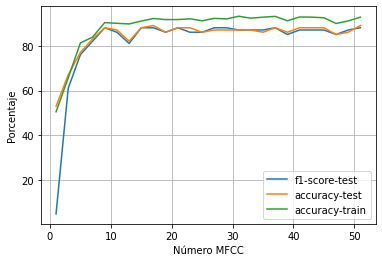

In [11]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score-test')
plt.plot(mfccNumbers,accuracys, label='accuracy-test', )
plt.plot(mfccNumbers,accuracystrain, label='accuracy-train', )
plt.xlabel('Número MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

In [12]:
#GUNSHOT DATA MFCC

mfccNumbers = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
f1Scores = [88.0,81.0,89.0,89.0,87.0,89.0,88.0,90.0,89.0,91.0,89.0,90.0,88.0,89.0,90.0,92.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,90.0,90.0]
accuracys = [87.0,81.0,88.0,89.0,86.0,89.0,87.0,90.0,89.0,91.0,89.0,89.0,88.0,89.0,89.0,92.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,90.0,90.0]
accuracystrain = [92.14,87.95,92.64,92.47,92.47,94.14,93.64,94.81,95.48,95.48,95.31,95.15,94.64,95.48,95.48,94.81,95.65,95.81,95.65,94.48,95.65,95.31,94.98,95.98,95.31,95.15]
print(len(mfccNumbers))
print(len(f1Scores))
print(len(accuracys))
print(len(accuracystrain))

26
26
26
26


In [13]:
accnp = np.array(accuracys)
accnp2 = np.array(accuracystrain)
abs(accnp-accnp2)
np.mean(abs(accnp-accnp2))

5.194615384615388

In [14]:
f1Sconp = np.array(f1Scores)
print(np.argmax(accnp+f1Sconp))
print(np.argmax(accnp))
print(np.argmax(f1Sconp))
print("NUMERO DE MFCCs MEJOR DESEMPEÑO EN AER CNN DISPAROS: ", mfccNumbers[np.argmax(accnp+f1Sconp)])
#(accnp+f1Sconp)

15
15
15
NUMERO DE MFCCs MEJOR DESEMPEÑO EN AER CNN DISPAROS:  31


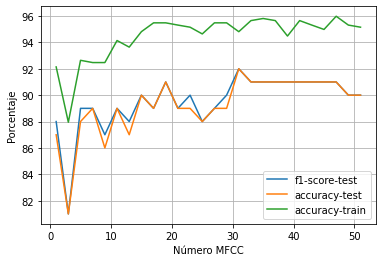

In [15]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score-test')
plt.plot(mfccNumbers,accuracys, label='accuracy-test', )
plt.plot(mfccNumbers,accuracystrain, label='accuracy-train', )
plt.xlabel('Número MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

In [16]:
#SCREAMS DATA MFCC
mfccNumbers = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
f1Scores = [83.0,91.0,86.0,85.0,88.0,87.0,90.0,92.0,91.0,94.0,91.0,90.0,88.0,92.0,91.0,79.0,83.0,93.0,92.0,61.0,86.0,92.0,79.0,88.0,94.0,83.0]
accuracys = [84.0,90.0,87.0,86.0,89.0,89.0,91.0,92.0,92.0,94.0,90.0,90.0,89.0,92.0,91.0,83.0,86.0,93.0,92.0,73.0,88.0,93.0,83.0,89.0,94.0,85.0]
accuracystrain = [86.55,87.99,85.60,86.08,90.24,88.48,91.51,91.68,91.36,93.44,91.03,90.88,91.36,92.15,90.88,85.11,84.64,92.64,92.64,68.95,85.92,93.12,83.20,88.95,93.59,85.92]
print(len(mfccNumbers))
print(len(f1Scores))
print(len(accuracys))
print(len(accuracystrain))

26
26
26
26


In [17]:
accnp = np.array(accuracys)
accnp2 = np.array(accuracystrain)
abs(accnp-accnp2)
np.mean(abs(accnp-accnp2))

1.0257692307692308

In [18]:
f1Sconp = np.array(f1Scores)
print(np.argmax(accnp+f1Sconp))
print(np.argmax(accnp))
print(np.argmax(f1Sconp))
print("NUMERO DE MFCCs MEJOR DESEMPEÑO EN AER CNN GRITOS: ", mfccNumbers[np.argmax(accnp+f1Sconp)])
#(accnp+f1Sconp)

9
9
9
NUMERO DE MFCCs MEJOR DESEMPEÑO EN AER CNN GRITOS:  19


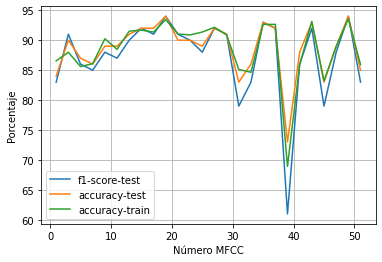

In [19]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score-test')
plt.plot(mfccNumbers,accuracys, label='accuracy-test', )
plt.plot(mfccNumbers,accuracystrain, label='accuracy-train', )
plt.xlabel('Número MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

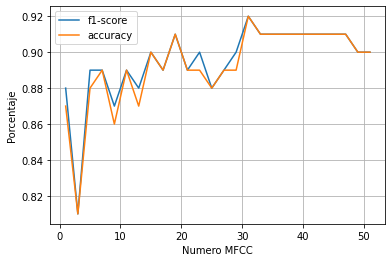

In [ ]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score')
plt.plot(mfccNumbers,accuracys, label='accuracy', )
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

In [ ]:
f1Scores = []
mfccNumbers = []
accuracys = []

N_MFCC = 1
for i in range(len(reports)):
  print(f'\n\nN_MFCC {N_MFCC}')
  print(f'Classification Report {i}: \n\n', reports[i])
  mfccNumbers.append(N_MFCC)
  f1Scores.append(float(reports[i].split()[7])*100)
  accuracys.append(float(reports[i].split()[15])*100)
  N_MFCC += 2



N_MFCC 1
Classification Report 0: 

               precision    recall  f1-score   support

           0       0.78      1.00      0.88        70
           1       1.00      0.75      0.86        80

    accuracy                           0.87       150
   macro avg       0.89      0.88      0.87       150
weighted avg       0.90      0.87      0.87       150



N_MFCC 3
Classification Report 1: 

               precision    recall  f1-score   support

           0       0.75      0.89      0.81        70
           1       0.88      0.74      0.80        80

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



N_MFCC 5
Classification Report 2: 

               precision    recall  f1-score   support

           0       0.80      1.00      0.89        70
           1       1.00      0.78      0.87        80

    accuracy                           0.88       150
   macro av

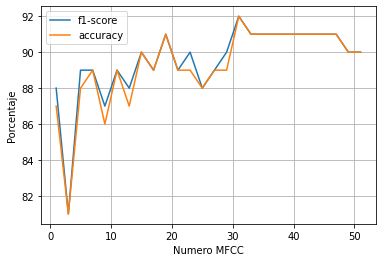

In [ ]:
# Plotting Accuracy and F1-Score of Models

plt.plot(mfccNumbers,f1Scores,  label='f1-score')
plt.plot(mfccNumbers,accuracys, label='accuracy', )
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

#Save the entire model as a SavedModel.

In [ ]:
#!mkdir -p saved_model

model.save('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/saved_gunshot')

#Reload a fresh Keras model from the saved model

In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
def predict(path):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.92):
      if(indexMax==0):
        classP = 'gun_shot'
      else:
        classP = 'non_gun_shot'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/gunshot_extended/saved_gunshot')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav')


1/1 [==============================] - 0s 135ms/step
[0.00588579 0.9941142 ]
1
Class predicted : non_gun_shot 




In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/102305-6-0-0.wav')

1/1 [==============================] - 0s 26ms/step
[0.9867156  0.01328445]
0
Class predicted : gun_shot 




In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-explosions/explosions/explosion_149.wav')

1/1 [==============================] - 0s 45ms/step
[0.02741109 0.97258884]
1
Class predicted : non_gun_shot 




#To record and save audio directly on colab

In [ ]:
#Se implementan funciones para grabar y guardar audio directamente desde el colab
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def recordAndSave(sec=3, path="audio.wav"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  with open(path,'wb') as f:
    f.write(b)
  return path  # or webm ?

In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio2 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba1.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio2)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.9985104  0.00148962]
0
Class predicted : gun_shot 




In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio3 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba2.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio3)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[3.7462482e-07 9.9999964e-01]
1
Class predicted : siren 


